In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    get_linear_schedule_with_warmup
)
from datasets import Dataset as HFDataset, load_dataset
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    classification_report, cohen_kappa_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
from typing import Dict, List, Tuple, Optional
import logging
from datetime import datetime

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
class RobertaDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_length: int = 512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
class RobertaTrainer:
    
    def __init__(self, model_name: str = "roberta-base", max_length: int = 512):
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = None
        self.sentiment_model = None
        self.emotion_model = None
        self.sentiment_label_encoder = LabelEncoder()
        self.emotion_label_encoder = LabelEncoder()
        
        # Set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")
        
        # Create output directories
        os.makedirs("./roberta_sentiment_model", exist_ok=True)
        os.makedirs("./roberta_emotion_model", exist_ok=True)
        os.makedirs("./plots/roberta", exist_ok=True)
        os.makedirs("./results/roberta", exist_ok=True)
    
    def setup_tokenizer(self):
        logger.info("Setting up RoBERTa tokenizer...")
        self.tokenizer = RobertaTokenizer.from_pretrained(self.model_name)
        
        # Add padding token if it doesn't exist
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        logger.info("✅ Tokenizer ready!")
    
    def load_reddit_data(self, file_path: str) -> pd.DataFrame:
        logger.info(f"Loading Reddit data from {file_path}...")
        
        try:
            df = pd.read_csv(file_path)
            logger.info(f"✅ Loaded {len(df)} samples from Reddit dataset")
            
            # Check for required columns
            required_cols = ['text_content', 'sentiment', 'emotion']
            missing_cols = [col for col in required_cols if col not in df.columns]
            if missing_cols:
                raise ValueError(f"Missing required columns: {missing_cols}")
            
            # Remove rows with missing values
            df = df.dropna(subset=required_cols)
            logger.info(f"After removing missing values: {len(df)} samples")
            
            return df
            
        except Exception as e:
            logger.error(f"Error loading Reddit data: {e}")
            raise
    
    def load_external_datasets(self) -> Tuple[Dict, Dict]:
        logger.info("Loading external datasets...")
        
        # Load SST-2 for sentiment
        try:
            sst2_dataset = load_dataset("sst2")
            sentiment_data = {
                'train': sst2_dataset['train'],
                'validation': sst2_dataset['validation']
            }
            logger.info("✅ SST-2 dataset loaded for sentiment classification")
        except Exception as e:
            logger.warning(f"Could not load SST-2: {e}. Using dummy data.")
            sentiment_data = self._create_dummy_sentiment_data()
        
        # Load GoEmotions for emotion
        try:
            emotions_dataset = load_dataset("go_emotions", "simplified")
            emotion_data = {
                'train': emotions_dataset['train'],
                'validation': emotions_dataset['validation']
            }
            logger.info("✅ GoEmotions dataset loaded for emotion classification")
        except Exception as e:
            logger.warning(f"Could not load GoEmotions: {e}. Using dummy data.")
            emotion_data = self._create_dummy_emotion_data()
        
        return sentiment_data, emotion_data
    
    def _create_dummy_sentiment_data(self) -> Dict:
        dummy_texts = [
            "I love this product!", "This is terrible", "It's okay",
            "Amazing quality", "Worst experience ever", "Not bad"
        ] * 100
        dummy_labels = [1, 0, 1, 1, 0, 1] * 100
        
        dummy_data = {
            'sentence': dummy_texts,
            'label': dummy_labels
        }
        
        dataset = HFDataset.from_dict(dummy_data)
        return {'train': dataset, 'validation': dataset.select(range(100))}
    
    def _create_dummy_emotion_data(self) -> Dict:
        """Create dummy emotion data for testing"""
        dummy_texts = [
            "I'm so happy!", "This is sad", "I'm angry", "That's scary",
            "What a surprise!", "Okay", "I admire you", "That's funny"
        ] * 100
        dummy_labels = [0, 1, 2, 3, 4, 5, 6, 7] * 100
        
        dummy_data = {
            'text': dummy_texts,
            'labels': dummy_labels
        }
        
        dataset = HFDataset.from_dict(dummy_data)
        return {'train': dataset, 'validation': dataset.select(range(100))}
    
    def preprocess_external_data(self, dataset: Dict, task: str) -> Dict:
        """Preprocess external datasets"""
        logger.info(f"Preprocessing external data for {task}...")

        # --- ADD THIS BLOCK FOR EMOTION TASK ---
        if task == 'emotion':
            # Only keep samples with label in [0, 1, 2, 3, 4, 5]
            def filter_first_6_classes(example):
                # Handle both single-label and multi-label
                if isinstance(example['labels'], list):
                    return example['labels'] and example['labels'][0] in range(6)
                else:
                    return example['labels'] in range(6)
            dataset['train'] = dataset['train'].filter(filter_first_6_classes)
            dataset['validation'] = dataset['validation'].filter(filter_first_6_classes)
        # --- END BLOCK ---

        def tokenize_function(examples):
            if task == 'sentiment':
                texts = examples['sentence']
                labels = examples['label']
            else:  # emotion
                texts = examples['text']
                # Handle multi-label to single-label conversion
                if isinstance(examples['labels'][0], list):
                    labels = [label_list[0] if label_list else 0 for label_list in examples['labels']]
                else:
                    labels = examples['labels']

            tokenized = self.tokenizer(
                texts,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors=None
            )

            tokenized['labels'] = labels
            return tokenized

        # Tokenize datasets
        tokenized_train = dataset['train'].map(tokenize_function, batched=True)
        tokenized_val = dataset['validation'].map(tokenize_function, batched=True)

        # Take subsets for faster training
        train_subset = tokenized_train.shuffle(seed=42).select(range(min(10000, len(tokenized_train))))
        val_subset = tokenized_val.shuffle(seed=42).select(range(min(2000, len(tokenized_val))))

        logger.info(f"✅ Preprocessed {task} data: {len(train_subset)} train, {len(val_subset)} val")

        return {'train': train_subset, 'validation': val_subset}
    
    def train_model(self, dataset: Dict, task: str, num_labels: int, 
                   learning_rate: float = 2e-5, num_epochs: int = 3,
                   batch_size: int = 16) -> Tuple[any, any]:
        """Train RoBERTa model for specific task"""
        logger.info(f"Training RoBERTa model for {task} classification...")
        
        # Initialize model
        model = RobertaForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
        
        # Training arguments
        output_dir = f"./roberta_{task}_model"
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir=f"./logs_{task}",
            logging_steps=100,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_accuracy",
            learning_rate=learning_rate,
            report_to=None,
            save_total_limit=2,
            dataloader_num_workers=0,  # Avoid multiprocessing issues
        )
        
        # Data collator
        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        
        # Compute metrics function
        def compute_metrics(eval_pred):
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
            
            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, predictions, average='macro', zero_division=0
            )
            accuracy = accuracy_score(labels, predictions)
            
            return {
                'accuracy': accuracy,
                'f1': f1,
                'precision': precision,
                'recall': recall
            }
        
        # Initialize trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset['train'],
            eval_dataset=dataset['validation'],
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        
        # Train
        logger.info(f"🚀 Starting {task} model training...")
        trainer.train()
        
        # Save model
        final_output_dir = f"./roberta_{task}_model_final"
        os.makedirs(final_output_dir, exist_ok=True)
        trainer.save_model(final_output_dir)
        
        logger.info(f"✅ {task.capitalize()} model training completed!")
        
        return model, trainer
    
    def prepare_reddit_data(self, df: pd.DataFrame, task: str) -> Tuple[List[str], List[int]]:
        texts = df['text_content'].tolist()
        
        if task == 'sentiment':
            labels = df['sentiment'].tolist()
            encoded_labels = self.sentiment_label_encoder.fit_transform(labels)
        else:  # emotion
            labels = df['emotion'].tolist()
            encoded_labels = self.emotion_label_encoder.fit_transform(labels)
        
        return texts, encoded_labels.tolist()
    
    def hyperparameter_tuning(self, dataset: Dict, task: str, num_labels: int) -> Dict:
        logger.info(f"Starting hyperparameter tuning for {task}...")
        
        # Define parameter grid
        param_grid = {
            'learning_rate': [1e-5, 2e-5, 3e-5, 5e-5],
            'batch_size': [8, 16, 32],
            'num_epochs': [2, 3, 4],
            'weight_decay': [0.01, 0.1]
        }
        
        best_score = 0
        best_params = {}
        results = []
        
        # Random search over parameters
        from itertools import product
        import random
        
        # Generate all combinations and sample randomly
        all_combinations = list(product(*param_grid.values()))
        random.shuffle(all_combinations)
        
        # Try up to 10 combinations
        for i, params in enumerate(all_combinations[:10]):
            param_dict = dict(zip(param_grid.keys(), params))
            logger.info(f"Trying parameters {i+1}/10: {param_dict}")
            
            try:
                # Train model with current parameters
                model, trainer = self.train_model(
                    dataset, task, num_labels,
                    learning_rate=param_dict['learning_rate'],
                    num_epochs=param_dict['num_epochs'],
                    batch_size=param_dict['batch_size']
                )
                
                # Evaluate on validation set
                eval_results = trainer.evaluate()
                score = eval_results['eval_accuracy']
                
                results.append({
                    'params': param_dict,
                    'score': score,
                    'eval_results': eval_results
                })
                
                if score > best_score:
                    best_score = score
                    best_params = param_dict
                    
                logger.info(f"Score: {score:.4f}")
                
            except Exception as e:
                logger.error(f"Error with parameters {param_dict}: {e}")
                continue
        
        logger.info(f"Best parameters for {task}: {best_params}")
        logger.info(f"Best score: {best_score:.4f}")
        
        return {
            'best_params': best_params,
            'best_score': best_score,
            'all_results': results
        }
    
    def save_results(self, results: Dict, task: str, filename: str = None):
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"results/roberta_{task}_results_{timestamp}.json"
        
        # Convert numpy arrays to lists for JSON serialization
        results_copy = results.copy()
        for key, value in results_copy.items():
            if isinstance(value, np.ndarray):
                results_copy[key] = value.tolist()
        
        with open(filename, 'w') as f:
            json.dump(results_copy, f, indent=2, default=str)
        
        logger.info(f"Results saved to {filename}")
    
    def create_learning_curves(self, trainer, task: str, save_path: str = None):
        """Create learning curves from training history"""
        # Get training history
        history = trainer.state.log_history
        
        train_losses = []
        eval_losses = []
        eval_accuracies = []
        
        for entry in history:
            if 'train_loss' in entry:
                train_losses.append(entry['train_loss'])
            if 'eval_loss' in entry:
                eval_losses.append(entry['eval_loss'])
            if 'eval_accuracy' in entry:
                eval_accuracies.append(entry['eval_accuracy'])
        
        # Create plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss curves
        epochs = range(1, len(eval_losses) + 1)
        ax1.plot(epochs, eval_losses, 'b-', label='Validation Loss')
        if len(train_losses) > 0:
            train_epochs = np.linspace(1, len(eval_losses), len(train_losses))
            ax1.plot(train_epochs, train_losses, 'r-', label='Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{task.capitalize()} - Learning Curves (Loss)')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy curve
        ax2.plot(epochs, eval_accuracies, 'g-', label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title(f'{task.capitalize()} - Learning Curves (Accuracy)')
        ax2.legend()
        ax2.grid(True)
        
        if save_path:
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Learning curves saved to {save_path}")
        
        plt.show()
    
    def run_complete_pipeline(self, reddit_data_path: str, 
                             perform_hyperparameter_tuning: bool = True):
        """Run the complete training and evaluation pipeline"""
        logger.info("🚀 Starting RoBERTa Complete Training Pipeline")
        logger.info("=" * 60)
        
        # Setup
        self.setup_tokenizer()
        
        # Load data
        reddit_df = self.load_reddit_data(reddit_data_path)
        sentiment_data, emotion_data = self.load_external_datasets()
        
        # Preprocess external data
        sentiment_processed = self.preprocess_external_data(sentiment_data, 'sentiment')
        emotion_processed = self.preprocess_external_data(emotion_data, 'emotion')
        
        # Prepare Reddit data
        sentiment_texts, sentiment_labels = self.prepare_reddit_data(reddit_df, 'sentiment')
        emotion_texts, emotion_labels = self.prepare_reddit_data(reddit_df, 'emotion')
        
        # Get number of classes
        n_sentiment_classes = len(self.sentiment_label_encoder.classes_)
        n_emotion_classes = len(self.emotion_label_encoder.classes_)
        
        logger.info(f"Sentiment classes: {n_sentiment_classes}")
        logger.info(f"Emotion classes: {n_emotion_classes}")
        
        results = {}
        
        # SENTIMENT TRAINING
        logger.info("\n🎯 SENTIMENT CLASSIFICATION PIPELINE")
        logger.info("=" * 50)
        
        # Pre-train on external data
        logger.info("Pre-training on SST-2 dataset...")
        sentiment_model, sentiment_trainer = self.train_model(
            sentiment_processed, 'sentiment', n_sentiment_classes
        )
        
        # Evaluate on Reddit data
        sentiment_results = self.evaluate_model(
            sentiment_model, sentiment_texts, sentiment_labels, 
            'sentiment', self.sentiment_label_encoder
        )
        
        # Create visualizations
        self.create_confusion_matrix(
            sentiment_results, 'sentiment', 
            'plots/sentiment_confusion_matrix.png'
        )
        self.create_roc_curves(
            sentiment_results, 'sentiment', 
            'plots/sentiment_roc_curves.png'
        )
        self.create_precision_recall_curves(
            sentiment_results, 'sentiment', 
            'plots/sentiment_pr_curves.png'
        )
        self.create_learning_curves(
            sentiment_trainer, 'sentiment', 
            'plots/sentiment_learning_curves.png'
        )
        
        # Hyperparameter tuning
        if perform_hyperparameter_tuning:
            logger.info("Performing hyperparameter tuning for sentiment...")
            sentiment_tuning_results = self.hyperparameter_tuning(
                sentiment_processed, 'sentiment', n_sentiment_classes
            )
            
            # Re-train with best parameters
            best_params = sentiment_tuning_results['best_params']
            logger.info(f"Re-training sentiment model with best parameters: {best_params}")
            
            sentiment_model_tuned, sentiment_trainer_tuned = self.train_model(
                sentiment_processed, 'sentiment', n_sentiment_classes, **best_params
            )
            
            # Evaluate tuned model
            sentiment_results_tuned = self.evaluate_model(
                sentiment_model_tuned, sentiment_texts, sentiment_labels,
                'sentiment', self.sentiment_label_encoder
            )
            
            results['sentiment_tuned'] = sentiment_results_tuned
            results['sentiment_tuning'] = sentiment_tuning_results
        
        results['sentiment'] = sentiment_results
        
        # EMOTION TRAINING
        logger.info("\n💭 EMOTION CLASSIFICATION PIPELINE")
        logger.info("=" * 50)
        
        # Pre-train on external data
        logger.info("Pre-training on GoEmotions dataset...")
        emotion_model, emotion_trainer = self.train_model(
            emotion_processed, 'emotion', n_emotion_classes
        )
        
        # Evaluate on Reddit data
        emotion_results = self.evaluate_model(
            emotion_model, emotion_texts, emotion_labels,
            'emotion', self.emotion_label_encoder
        )
        
        # Create visualizations
        self.create_confusion_matrix(
            emotion_results, 'emotion', 
            'plots/emotion_confusion_matrix.png'
        )
        self.create_roc_curves(
            emotion_results, 'emotion', 
            'plots/emotion_roc_curves.png'
        )
        self.create_precision_recall_curves(
            emotion_results, 'emotion', 
            'plots/emotion_pr_curves.png'
        )
        self.create_learning_curves(
            emotion_trainer, 'emotion', 
            'plots/emotion_learning_curves.png'
        )
        
        # Hyperparameter tuning
        if perform_hyperparameter_tuning:
            logger.info("Performing hyperparameter tuning for emotion...")
            emotion_tuning_results = self.hyperparameter_tuning(
                emotion_processed, 'emotion', n_emotion_classes
            )
            
            # Re-train with best parameters
            best_params = emotion_tuning_results['best_params']
            logger.info(f"Re-training emotion model with best parameters: {best_params}")
            
            emotion_model_tuned, emotion_trainer_tuned = self.train_model(
                emotion_processed, 'emotion', n_emotion_classes, **best_params
            )
            
            # Evaluate tuned model
            emotion_results_tuned = self.evaluate_model(
                emotion_model_tuned, emotion_texts, emotion_labels,
                'emotion', self.emotion_label_encoder
            )
            
            results['emotion_tuned'] = emotion_results_tuned
            results['emotion_tuning'] = emotion_tuning_results
        
        results['emotion'] = emotion_results
        
        # FINAL SUMMARY
        logger.info("\n📋 FINAL SUMMARY")
        logger.info("=" * 50)
        
        self.create_final_summary(results)
        
        # Save all results
        self.save_results(results, 'complete_pipeline')
        
        logger.info("\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        logger.info("📁 Output files:")
        logger.info("   - ./roberta_sentiment_model_final/ (sentiment model)")
        logger.info("   - ./roberta_emotion_model_final/ (emotion model)")
        logger.info("   - ./plots/ (all visualization plots)")
        logger.info("   - ./results/ (evaluation results)")
        
        return results
    
    def create_final_summary(self, results: Dict):
        """Create a comprehensive summary of all results"""
        summary_data = []
        
        for task in ['sentiment', 'emotion']:
            if task in results:
                res = results[task]
                summary_data.append({
                    'Task': task.capitalize(),
                    'Model': 'RoBERTa (Base)',
                    'Accuracy': f"{res['accuracy']:.4f}",
                    'Precision (Macro)': f"{res['precision_macro']:.4f}",
                    'Recall (Macro)': f"{res['recall_macro']:.4f}",
                    'F1-Score (Macro)': f"{res['f1_macro']:.4f}",
                    'F1-Score (Weighted)': f"{res['f1_weighted']:.4f}",
                    'Cohen\'s Kappa': f"{res['cohen_kappa']:.4f}"
                })
            
            # Add tuned results if available
            if f'{task}_tuned' in results:
                res = results[f'{task}_tuned']
                summary_data.append({
                    'Task': f"{task.capitalize()} (Tuned)",
                    'Model': 'RoBERTa (Tuned)',
                    'Accuracy': f"{res['accuracy']:.4f}",
                    'Precision (Macro)': f"{res['precision_macro']:.4f}",
                    'Recall (Macro)': f"{res['recall_macro']:.4f}",
                    'F1-Score (Macro)': f"{res['f1_macro']:.4f}",
                    'F1-Score (Weighted)': f"{res['f1_weighted']:.4f}",
                    'Cohen\'s Kappa': f"{res['cohen_kappa']:.4f}"
                })
        
        summary_df = pd.DataFrame(summary_data)
        print("\n" + "="*80)
        print("ROBERTA EVALUATION SUMMARY")
        print("="*80)
        print(summary_df.to_string(index=False))
        print("="*80)
        
        # Save summary
        summary_df.to_csv('results/roberta_evaluation_summary.csv', index=False)
        logger.info("Summary saved to: results/roberta_evaluation_summary.csv")


In [9]:
trainer = RobertaTrainer()
trainer.setup_tokenizer()

INFO:__main__:Using device: cuda
INFO:__main__:Setting up RoBERTa tokenizer...


INFO:__main__:✅ Tokenizer ready!


In [10]:
reddit_df = trainer.load_reddit_data('annotated_reddit_posts.csv')
reddit_df.head()

INFO:__main__:Loading Reddit data from annotated_reddit_posts.csv...
INFO:__main__:✅ Loaded 95 samples from Reddit dataset
INFO:__main__:After removing missing values: 95 samples


,id,text_content,original_text,type,score,subjectivity,sentiment,emotion
0,d8kzu3m,ya screw username really looking forward note ...,Ya this screws me over completely. I was reall...,comment,2,0.464167,Negative,Sadness
1,5jd0fx,username samsung galaxy note7 still more user ...,Cancelled Samsung Galaxy Note7 still has more ...,post,95,0.500000,Neutral,Surprise
2,dbfyq3r,traded note 7 s7 edge really hope samsung user...,I traded my Note 7 in for an S7 Edge. I reall...,comment,9,0.414286,Negative,Sadness
3,dbgcdgl,reading username report battery design failed ...,From reading the independent report of why its...,comment,2,0.406250,Positive,Sadness
4,dbftpbx,maybe phone unique username feature explode us...,Maybe the phone's unique exploding feature (or...,comment,-4,0.800000,Negative,Anger


In [16]:
sentiment_data, emotion_data = trainer.load_external_datasets()

INFO:__main__:Loading external datasets...
INFO:__main__:✅ SST-2 dataset loaded for sentiment classification
INFO:__main__:✅ GoEmotions dataset loaded for emotion classification


In [17]:
sentiment_processed = trainer.preprocess_external_data(sentiment_data, 'sentiment')
emotion_processed = trainer.preprocess_external_data(emotion_data, 'emotion')

INFO:__main__:Preprocessing external data for sentiment...
Map: 100%|██████████| 872/872 [00:00<00:00, 3665.91 examples/s]
INFO:__main__:✅ Preprocessed sentiment data: 10000 train, 872 val
INFO:__main__:Preprocessing external data for emotion...
Map: 100%|██████████| 1717/1717 [00:00<00:00, 4889.51 examples/s]
INFO:__main__:✅ Preprocessed emotion data: 10000 train, 1717 val


In [18]:
sentiment_texts, sentiment_labels = trainer.prepare_reddit_data(reddit_df, 'sentiment')
emotion_texts, emotion_labels = trainer.prepare_reddit_data(reddit_df, 'emotion')
n_sentiment_classes = len(trainer.sentiment_label_encoder.classes_)
n_emotion_classes = len(trainer.emotion_label_encoder.classes_)

##### Save label encoders

In [20]:
import joblib

# Save the label encoders
joblib.dump(trainer.sentiment_label_encoder, 'sentiment_label_encoder.pkl')
joblib.dump(trainer.emotion_label_encoder, 'emotion_label_encoder.pkl')

print("Label encoders saved!")
print("Sentiment classes:", trainer.sentiment_label_encoder.classes_)
print("Emotion classes:", trainer.emotion_label_encoder.classes_)

Label encoders saved!
Sentiment classes: ['Negative' 'Neutral' 'Positive']
Emotion classes: ['Anger' 'Fear' 'Joy' 'No Emotion' 'Sadness' 'Surprise']


### Prep for evaluation

In [3]:
import joblib

# Load the label encoder
sentiment_label_encoder = joblib.load('enc/sentiment_label_encoder.pkl')
emotion_label_encoder = joblib.load('enc/emotion_label_encoder.pkl')

In [11]:
# Extract texts and true labels
test_texts = reddit_df['text_content'].tolist()

# Encode true labels using the same encoders used during training
sentiment_true_labels = sentiment_label_encoder.transform(reddit_df['sentiment'].tolist())
emotion_true_labels = emotion_label_encoder.transform(reddit_df['emotion'].tolist())

print(f"Sentiment classes: {sentiment_label_encoder.classes_}")
print(f"Emotion classes: {emotion_label_encoder.classes_}")

Sentiment classes: ['Negative' 'Neutral' 'Positive']
Emotion classes: ['Anger' 'Fear' 'Joy' 'No Emotion' 'Sadness' 'Surprise']


In [29]:
import pandas as pd
import numpy as np
import torch
import joblib
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def evaluate_roberta_model(model_dir, label_encoder_path, csv_file, target_column, model_name):

    print(f"🚀 Starting evaluation of {model_name} model...")
    
    # 1. Load model, tokenizer, and label encoder
    print("📂 Loading model and tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained(model_dir)
    model = RobertaForSequenceClassification.from_pretrained(model_dir)
    label_encoder = joblib.load(label_encoder_path)
    
    # 2. Set device and move model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️ Using device: {device}")
    model = model.to(device)
    model.eval()
    
    # 3. Load and prepare data
    print("📊 Loading test data...")
    df = pd.read_csv(csv_file)
    test_texts = df['text_content'].tolist()
    true_labels_text = df[target_column].tolist()
    
    # Encode true labels
    true_labels_encoded = label_encoder.transform(true_labels_text)
    
    print(f"📋 Dataset info:")
    print(f"   - Total samples: {len(test_texts)}")
    print(f"   - Classes: {list(label_encoder.classes_)}")
    print(f"   - Class distribution:")
    for class_name in label_encoder.classes_:
        count = sum(1 for label in true_labels_text if label == class_name)
        print(f"     {class_name}: {count}")
    
    # 4. Run inference on all samples
    print("🔮 Running inference...")
    predicted_labels_encoded = []
    
    for text in tqdm(test_texts, desc="Predicting"):
        # Tokenize
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=512
        )
        
        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class_id = logits.argmax(dim=-1).item()
        
        predicted_labels_encoded.append(predicted_class_id)
    
    # 5. Calculate metrics
    print("📈 Calculating metrics...")
    
    # Accuracy
    accuracy = accuracy_score(true_labels_encoded, predicted_labels_encoded)
    
    # Precision, Recall, F1 (macro and weighted)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        true_labels_encoded, predicted_labels_encoded, average='macro'
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        true_labels_encoded, predicted_labels_encoded, average='weighted'
    )
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels_encoded, predicted_labels_encoded)
    
    # Convert predictions back to text labels for better readability
    predicted_labels_text = label_encoder.inverse_transform(predicted_labels_encoded)
    
    # 6. Prepare results
    results = {
        'model_name': model_name,
        'target_column': target_column,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'class_names': list(label_encoder.classes_),
        'true_labels': true_labels_text,
        'predicted_labels': predicted_labels_text,
        'classification_report': classification_report(
            true_labels_text, predicted_labels_text, 
            target_names=label_encoder.classes_
        )
    }
    
    # 7. Print results
    print(f"\n{model_name} Model Evaluation Results:")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"\nDetailed Classification Report:")
    print(results['classification_report'])
    
    return results

In [23]:
def plot_confusion_matrix(results, save_path=None):
    """
    Plot and optionally save confusion matrix from evaluation results.
    
    Args:
        results (dict): Results from evaluate_roberta_model function
        save_path (str, optional): Path to save the plot
    """
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(
        results['confusion_matrix'], 
        annot=True, 
        fmt='d',
        cmap='Blues',
        xticklabels=results['class_names'],
        yticklabels=results['class_names']
    )
    
    plt.title(f'{results["model_name"]} Model - Confusion Matrix', fontsize=16, pad=20)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Confusion matrix saved to: {save_path}")
    
    plt.show()

In [34]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

class RedditTextPreprocessor:
    """Same preprocessing class for inference"""
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        # Remove some emotion-related words from stopwords to preserve sentiment
        emotion_words = {
            'not', 'no', 'nor', 'but', 'however', 'although', 'though',
            'very', 'really', 'quite', 'too', 'so', 'more', 'most',
            'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
            'some', 'such', 'only', 'own', 'same', 'than', 'too', 'very'
        }
        self.stop_words = self.stop_words - emotion_words
    
    def remove_urls(self, text):
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        text = re.sub(r'/r/[A-Za-z0-9_]+', '', text)
        return text
    
    def remove_mentions_hashtags(self, text):
        text = re.sub(r'@[A-Za-z0-9_]+', '', text)
        text = re.sub(r'#([A-Za-z0-9_]+)', r'\1', text)
        return text
    
    def remove_html_tags(self, text):
        text = re.sub(r'<[^>]+>', '', text)
        return text
    
    def handle_reddit_formatting(self, text):
        text = re.sub(r'\[([^\]]+)\]\([^\)]+\)', r'\1', text)
        text = re.sub(r'u/[A-Za-z0-9_]+', '', text)
        text = re.sub(r'\*\*([^\*]+)\*\*', r'\1', text)
        text = re.sub(r'\*([^\*]+)\*', r'\1', text)
        text = re.sub(r'^>', '', text, flags=re.MULTILINE)
        return text
    
    def convert_emojis(self, text):
        try:
            import emoji
            text = emoji.demojize(text, delimiters=(" ", " "))
            text = re.sub(r':[a-zA-Z_]+:', lambda m: m.group().replace('_', ' ').replace(':', ''), text)
        except ImportError:
            pass
        return text
    
    def clean_special_characters(self, text):
        text = re.sub(r'!+', ' EXCLAMATION ', text)
        text = re.sub(r'\?+', ' QUESTION ', text)
        text = re.sub(r'[^\w\s\']', ' ', text)
        text = text.replace(' EXCLAMATION ', ' ! ')
        text = text.replace(' QUESTION ', ' ? ')
        text = re.sub(r"'", '', text)
        return text
    
    def normalize_whitespace(self, text):
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        return text
    
    def remove_stopwords(self, text):
        try:
            words = word_tokenize(text.lower())
            filtered_words = [word for word in words if word not in self.stop_words]
            return ' '.join(filtered_words)
        except:
            words = text.lower().split()
            filtered_words = [word for word in words if word not in self.stop_words]
            return ' '.join(filtered_words)
    
    def lemmatize_text(self, text):
        try:
            words = word_tokenize(text)
            lemmatized_words = [self.lemmatizer.lemmatize(word) for word in words]
            return ' '.join(lemmatized_words)
        except:
            words = text.split()
            lemmatized_words = [self.lemmatizer.lemmatize(word) for word in words]
            return ' '.join(lemmatized_words)
    
    def anonymize_identifiers(self, text):
        text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '[PHONE]', text)
        text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '[EMAIL]', text)
        text = re.sub(r'\b[A-Za-z0-9_]{8,}\b', '[USERNAME]', text)
        return text
    
    def preprocess_text(self, text):
        if not isinstance(text, str):
            return ""
        
        text = self.handle_reddit_formatting(text)
        text = self.remove_urls(text)
        text = self.remove_mentions_hashtags(text)
        text = self.remove_html_tags(text)
        text = self.convert_emojis(text)
        text = self.anonymize_identifiers(text)
        text = self.clean_special_characters(text)
        text = self.normalize_whitespace(text)
        text = text.lower()
        text = self.remove_stopwords(text)
        text = self.lemmatize_text(text)
        text = self.normalize_whitespace(text)
        
        return text

preprocessor = RedditTextPreprocessor()

### HP Tuning

In [4]:
import optuna
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import logging
import os
from datetime import datetime

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class RobertaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class HyperparameterTuner:
    def __init__(self, data_path, task_type='emotion', n_trials=50, cv_folds=3):
        self.data_path = data_path
        self.task_type = task_type
        self.n_trials = n_trials
        self.cv_folds = cv_folds
        
        # Load and prepare data
        self.df = pd.read_csv(data_path)
        self.texts = self.df['text_content'].tolist()
        self.labels_text = self.df[task_type].tolist()
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels_text)
        self.n_classes = len(self.label_encoder.classes_)
        
        logger.info(f"Loaded {len(self.texts)} samples for {task_type} task")
        logger.info(f"Classes: {list(self.label_encoder.classes_)}")
        logger.info(f"Number of classes: {self.n_classes}")
        
        # Initialize tokenizer
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        
        # Create output directory
        self.output_dir = f"hyperparameter_tuning_{task_type}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        os.makedirs(self.output_dir, exist_ok=True)
    
    def objective(self, trial):
        # Sample hyperparameters
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-4, log=True)
        batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        num_epochs = trial.suggest_int('num_epochs', 3, 8)
        warmup_ratio = trial.suggest_float('warmup_ratio', 0.05, 0.2)
        weight_decay = trial.suggest_float('weight_decay', 0.01, 0.3)
        
        logger.info(f"Trial {trial.number}: lr={learning_rate:.2e}, bs={batch_size}, "
                   f"dropout={dropout_rate:.3f}, epochs={num_epochs}")
        
        # Cross-validation scores
        cv_scores = []
        
        # Stratified K-Fold
        skf = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(self.texts, self.labels)):
            logger.info(f"  Fold {fold + 1}/{self.cv_folds}")
            
            # Split data
            train_texts = [self.texts[i] for i in train_idx]
            train_labels = [self.labels[i] for i in train_idx]
            val_texts = [self.texts[i] for i in val_idx]
            val_labels = [self.labels[i] for i in val_idx]
            
            # Create datasets
            train_dataset = RobertaDataset(train_texts, train_labels, self.tokenizer)
            val_dataset = RobertaDataset(val_texts, val_labels, self.tokenizer)
            
            # Initialize model with custom dropout
            model = RobertaForSequenceClassification.from_pretrained(
                'roberta-base',
                num_labels=self.n_classes,
                hidden_dropout_prob=dropout_rate,
                attention_probs_dropout_prob=dropout_rate
            )
            
            # Training arguments
            training_args = TrainingArguments(
                output_dir=f"{self.output_dir}/trial_{trial.number}_fold_{fold}",
                num_train_epochs=num_epochs,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                warmup_ratio=warmup_ratio,
                logging_dir=f"{self.output_dir}/logs",
                logging_steps=50,
                evaluation_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="eval_f1",
                greater_is_better=True,
                remove_unused_columns=False,
                dataloader_num_workers=0,
                report_to="none",  # Disable wandb/tensorboard
                save_total_limit=1,  # Only keep best checkpoint
            )
            
            # Custom compute metrics function
            def compute_metrics(eval_pred):
                predictions, labels = eval_pred
                predictions = np.argmax(predictions, axis=1)
                
                if self.task_type == 'emotion':
                    # Weighted F1 for emotion (imbalanced classes)
                    f1 = f1_score(labels, predictions, average='weighted')
                else:
                    # Macro F1 for sentiment
                    f1 = f1_score(labels, predictions, average='macro')
                
                return {'f1': f1}
            
            # Initialize trainer
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )
            
            # Train model
            try:
                trainer.train()
                
                # Evaluate
                eval_results = trainer.evaluate()
                fold_score = eval_results['eval_f1']
                cv_scores.append(fold_score)
                
                logger.info(f"    Fold {fold + 1} F1: {fold_score:.4f}")
                
            except Exception as e:
                logger.error(f"    Fold {fold + 1} failed: {str(e)}")
                cv_scores.append(0.0)  # Penalty for failed runs
            
            # Clean up to save memory
            del model, trainer
            torch.cuda.empty_cache()
        
        # Calculate mean CV score
        mean_score = np.mean(cv_scores)
        std_score = np.std(cv_scores)
        
        logger.info(f"Trial {trial.number} completed: Mean F1 = {mean_score:.4f} ± {std_score:.4f}")
        
        return mean_score
    
    def tune(self):
        logger.info(f"Starting hyperparameter tuning for {self.task_type} task")
        logger.info(f"Search space:")
        logger.info(f"  - Learning rate: [1e-5, 5e-4]")
        logger.info(f"  - Batch size: [8, 16, 32]")
        logger.info(f"  - Dropout rate: [0.1, 0.5]")
        logger.info(f"  - Epochs: [3, 8]")
        logger.info(f"  - Warmup ratio: [0.05, 0.2]")
        logger.info(f"  - Weight decay: [0.01, 0.3]")
        
        # Create study
        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=42),
            pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
        )
        
        # Optimize
        study.optimize(self.objective, n_trials=self.n_trials)
        
        # Save results
        self.save_results(study)
        
        return study
    
    def save_results(self, study):
        logger.info("Saving optimization results...")
        
        # Best parameters
        best_params = study.best_params
        best_score = study.best_value
        
        logger.info(f"Best score: {best_score:.4f}")
        logger.info(f"Best parameters: {best_params}")
        
        # Save to file
        results = {
            'task_type': self.task_type,
            'best_score': best_score,
            'best_params': best_params,
            'n_trials': len(study.trials),
            'cv_folds': self.cv_folds
        }
        
        import json
        with open(f"{self.output_dir}/best_hyperparameters.json", 'w') as f:
            json.dump(results, f, indent=2)
        
        # Save study
        import pickle
        with open(f"{self.output_dir}/optuna_study.pkl", 'wb') as f:
            pickle.dump(study, f)
        
        # Create trials dataframe
        trials_df = study.trials_dataframe()
        trials_df.to_csv(f"{self.output_dir}/all_trials.csv", index=False)
        
        logger.info(f"Results saved to {self.output_dir}/")
        
        return results

def train_final_model(best_params, data_path, task_type, output_dir):
    logger.info(f"Training final {task_type} model with best hyperparameters...")
    
    # Load data
    df = pd.read_csv(data_path)
    texts = df['text_content'].tolist()
    labels_text = df[task_type].tolist()
    
    # Encode labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_text)
    n_classes = len(label_encoder.classes_)
    
    # Save label encoder
    import joblib
    os.makedirs(f"{output_dir}/enc", exist_ok=True)
    joblib.dump(label_encoder, f"{output_dir}/enc/{task_type}_label_encoder.pkl")
    
    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    # Create dataset
    dataset = RobertaDataset(texts, labels, tokenizer)
    
    # Initialize model
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=n_classes,
        hidden_dropout_prob=best_params['dropout_rate'],
        attention_probs_dropout_prob=best_params['dropout_rate']
    )
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=best_params['num_epochs'],
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        learning_rate=best_params['learning_rate'],
        weight_decay=best_params['weight_decay'],
        warmup_ratio=best_params['warmup_ratio'],
        logging_dir=f"{output_dir}/logs",
        logging_steps=50,
        save_strategy="epoch",
        save_total_limit=2,
        dataloader_num_workers=0,
        report_to="none"
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        tokenizer=tokenizer
    )
    
    # Train
    trainer.train()
    
    # Save final model
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    
    logger.info(f"Final {task_type} model saved to {output_dir}")
    
    return model, tokenizer, label_encoder

c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train sentiment model

In [21]:
sentiment_model, sentiment_trainer = trainer.train_model(
    sentiment_processed, 'sentiment', n_sentiment_classes
)

INFO:__main__:Training RoBERTa model for sentiment classification...
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:__main__:🚀 Starting sentiment model training...
  5%|▌         | 100/1875 [26:14<6:55:36, 14.05s/it]

{'loss': 1.045, 'grad_norm': 5.94059419631958, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.16}


 11%|█         | 200/1875 [57:25<6:38:38, 14.28s/it] 

{'loss': 0.4976, 'grad_norm': 11.920705795288086, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.32}


 16%|█▌        | 300/1875 [1:25:55<22:36:17, 51.67s/it]

{'loss': 0.3364, 'grad_norm': 19.39594078063965, 'learning_rate': 1.2e-05, 'epoch': 0.48}


 21%|██▏       | 400/1875 [2:06:45<5:52:15, 14.33s/it] 

{'loss': 0.314, 'grad_norm': 12.545730590820312, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.64}


 27%|██▋       | 500/1875 [3:02:46<6:21:36, 16.65s/it] 

{'loss': 0.2932, 'grad_norm': 25.356975555419922, 'learning_rate': 2e-05, 'epoch': 0.8}


 32%|███▏      | 600/1875 [3:29:32<5:56:17, 16.77s/it]

{'loss': 0.357, 'grad_norm': 24.92654800415039, 'learning_rate': 1.8545454545454545e-05, 'epoch': 0.96}


                                                      
 33%|███▎      | 625/1875 [3:40:33<5:33:34, 16.01s/it]

{'eval_loss': 0.2112049013376236, 'eval_accuracy': 0.9208715596330275, 'eval_f1': 0.9208064662610118, 'eval_precision': 0.9211541197110749, 'eval_recall': 0.9206554685526649, 'eval_runtime': 253.6554, 'eval_samples_per_second': 3.438, 'eval_steps_per_second': 0.217, 'epoch': 1.0}


 37%|███▋      | 700/1875 [4:01:28<5:19:03, 16.29s/it] 

{'loss': 0.3117, 'grad_norm': 7.736201286315918, 'learning_rate': 1.7090909090909092e-05, 'epoch': 1.12}


 43%|████▎     | 800/1875 [4:29:41<5:04:21, 16.99s/it]

{'loss': 0.2296, 'grad_norm': 7.278459072113037, 'learning_rate': 1.563636363636364e-05, 'epoch': 1.28}


 48%|████▊     | 900/1875 [5:08:51<5:06:07, 18.84s/it] 

{'loss': 0.2398, 'grad_norm': 35.191184997558594, 'learning_rate': 1.4181818181818183e-05, 'epoch': 1.44}


 53%|█████▎    | 1000/1875 [5:46:55<3:38:18, 14.97s/it]

{'loss': 0.2564, 'grad_norm': 0.6027865409851074, 'learning_rate': 1.2727272727272728e-05, 'epoch': 1.6}


 59%|█████▊    | 1100/1875 [6:13:40<8:28:12, 39.35s/it]

{'loss': 0.2657, 'grad_norm': 7.3694844245910645, 'learning_rate': 1.1272727272727272e-05, 'epoch': 1.76}


 64%|██████▍   | 1200/1875 [7:27:55<2:40:34, 14.27s/it] 

{'loss': 0.1982, 'grad_norm': 41.40156173706055, 'learning_rate': 9.81818181818182e-06, 'epoch': 1.92}


                                                       
 67%|██████▋   | 1250/1875 [7:43:57<2:30:10, 14.42s/it]

{'eval_loss': 0.2743379771709442, 'eval_accuracy': 0.9243119266055045, 'eval_f1': 0.9241359310326646, 'eval_precision': 0.9261882078966868, 'eval_recall': 0.9237391597204682, 'eval_runtime': 228.1468, 'eval_samples_per_second': 3.822, 'eval_steps_per_second': 0.241, 'epoch': 2.0}


 69%|██████▉   | 1300/1875 [7:56:10<2:19:37, 14.57s/it] 

{'loss': 0.1565, 'grad_norm': 20.35262680053711, 'learning_rate': 8.363636363636365e-06, 'epoch': 2.08}


 75%|███████▍  | 1400/1875 [8:42:51<4:54:08, 37.15s/it]

{'loss': 0.1184, 'grad_norm': 0.07821206003427505, 'learning_rate': 6.90909090909091e-06, 'epoch': 2.24}


 80%|████████  | 1500/1875 [9:14:13<1:36:18, 15.41s/it]

{'loss': 0.1485, 'grad_norm': 58.94142532348633, 'learning_rate': 5.4545454545454545e-06, 'epoch': 2.4}


 85%|████████▌ | 1600/1875 [10:00:28<3:58:44, 52.09s/it]

{'loss': 0.1638, 'grad_norm': 65.2631607055664, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.56}


 91%|█████████ | 1700/1875 [10:36:12<2:03:56, 42.49s/it]

{'loss': 0.1566, 'grad_norm': 9.603964805603027, 'learning_rate': 2.5454545454545456e-06, 'epoch': 2.72}


 96%|█████████▌| 1800/1875 [11:13:27<19:36, 15.68s/it]  

{'loss': 0.1327, 'grad_norm': 43.211490631103516, 'learning_rate': 1.090909090909091e-06, 'epoch': 2.88}


                                                      
100%|██████████| 1875/1875 [11:36:35<00:00, 15.29s/it]

{'eval_loss': 0.31552377343177795, 'eval_accuracy': 0.9288990825688074, 'eval_f1': 0.9288451819407009, 'eval_precision': 0.9291403286978508, 'eval_recall': 0.9287067441273049, 'eval_runtime': 238.9574, 'eval_samples_per_second': 3.649, 'eval_steps_per_second': 0.23, 'epoch': 3.0}


100%|██████████| 1875/1875 [11:36:37<00:00, 22.29s/it]


{'train_runtime': 41797.1955, 'train_samples_per_second': 0.718, 'train_steps_per_second': 0.045, 'train_loss': 0.28538743743896483, 'epoch': 3.0}


INFO:__main__:✅ Sentiment model training completed!


In [ ]:
# Save model and tokenizer to a directory
save_directory = "./roberta_sentiment_model"
sentiment_model.save_pretrained(save_directory)
trainer.tokenizer.save_pretrained(save_directory) 

('./roberta_sentiment_model\\tokenizer_config.json',
 './roberta_sentiment_model\\special_tokens_map.json',
 './roberta_sentiment_model\\vocab.json',
 './roberta_sentiment_model\\merges.txt',
 './roberta_sentiment_model\\added_tokens.json')


### Load model

In [30]:
sentiment_model_dir = "./roberta_sentiment_model"
sentiment_tokenizer = RobertaTokenizer.from_pretrained(sentiment_model_dir)
sentiment_model = RobertaForSequenceClassification.from_pretrained(sentiment_model_dir)
sentiment_label_encoder = joblib.load('enc/sentiment_label_encoder.pkl')

# Set device and move models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

emotion_model = sentiment_model.to(device)
emotion_model.eval()

print("✅ Models moved to device and set to eval mode!")
print("Available sentiment classes:", sentiment_label_encoder.classes_)

Using device: cuda
✅ Models moved to device and set to eval mode!
Available sentiment classes: ['Negative' 'Neutral' 'Positive']


### Evaluate model

Evaluating Sentiment Model...
🚀 Starting evaluation of Sentiment model...
📂 Loading model and tokenizer...
🖥️ Using device: cuda
📊 Loading test data...
📋 Dataset info:
   - Total samples: 95
   - Classes: [np.str_('Negative'), np.str_('Neutral'), np.str_('Positive')]
   - Class distribution:
     Negative: 52
     Neutral: 21
     Positive: 22
🔮 Running inference...


Predicting: 100%|██████████| 95/95 [00:01<00:00, 58.42it/s]


📈 Calculating metrics...

Sentiment Model Evaluation Results:
Accuracy: 0.5579
Precision (Macro): 0.3323
Recall (Macro): 0.3681
F1-Score (Macro): 0.3095
F1-Score (Weighted): 0.4383

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.57      0.96      0.71        52
     Neutral       0.43      0.14      0.21        21
    Positive       0.00      0.00      0.00        22

    accuracy                           0.56        95
   macro avg       0.33      0.37      0.31        95
weighted avg       0.41      0.56      0.44        95

💾 Confusion matrix saved to: plots/roberta_sent/sentiment_confusion_matrix_eval.png


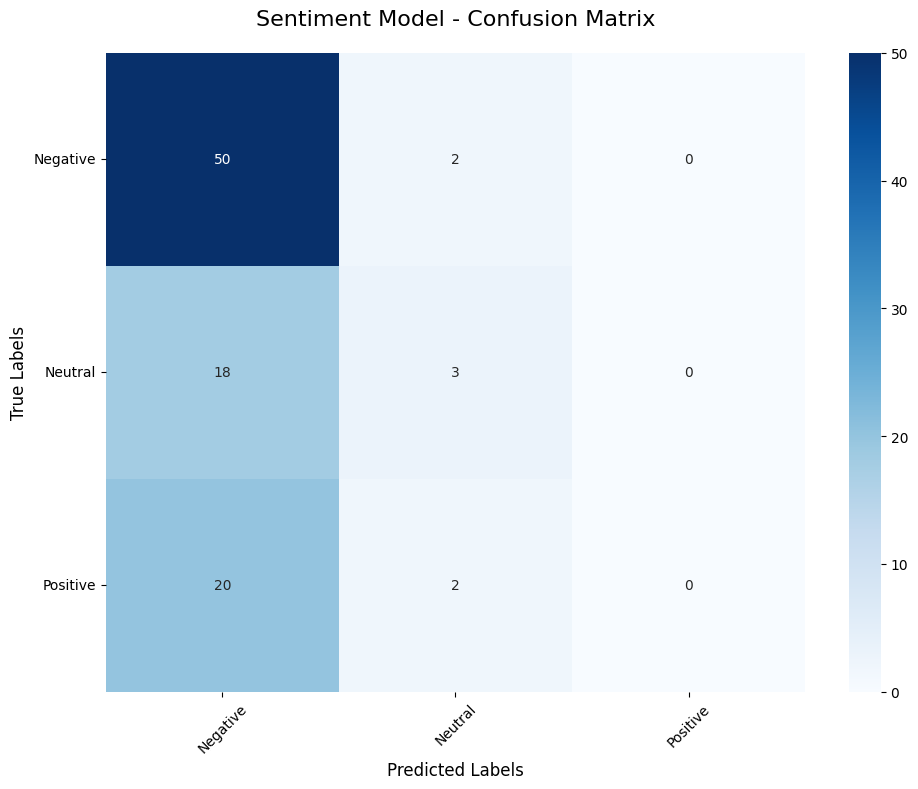

In [32]:
# Evaluate Sentiment Model
print("Evaluating Sentiment Model...")
sentiment_results = evaluate_roberta_model(
    model_dir="./roberta_sentiment_model",
    label_encoder_path="enc/sentiment_label_encoder.pkl",
    csv_file="annotated_reddit_posts.csv",
    target_column="sentiment",
    model_name="Sentiment"
)

# Plot confusion matrix for sentiment model
plot_confusion_matrix(sentiment_results, save_path="plots/roberta_sent/sentiment_confusion_matrix_eval.png")

#### Predict with sentiment

In [45]:
def predict_sentiment(text):

    # Preprocess the input text
    preprocessed_text = preprocessor.preprocess_text(text)
    
    # Handle empty text after preprocessing
    if not preprocessed_text or len(preprocessed_text.strip()) == 0:
        return {
            'predicted_label': 'Neutral',  # Default fallback
            'confidence': 0.0,
            'class_id': -1,
            'all_probabilities': [],
            'preprocessed_text': preprocessed_text,
            'error': 'Text became empty after preprocessing'
        }
    
    # Tokenize the preprocessed text
    inputs = sentiment_tokenizer(
        preprocessed_text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )
    
    # Move tensors to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Run inference
    with torch.no_grad():
        outputs = sentiment_model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predicted_class_id = logits.argmax(dim=-1).item()
    
    # Map back to original label
    predicted_label = sentiment_label_encoder.inverse_transform([predicted_class_id])[0]
    confidence = probabilities[0][predicted_class_id].item()
    
    return {
        'predicted_label': predicted_label,
        'confidence': confidence,
        'class_id': predicted_class_id,
        'all_probabilities': probabilities[0].cpu().numpy(),
        'preprocessed_text': preprocessed_text,
        'original_text': text
    }

test_cases = [
    "I absolutely love this product! 😍 It's amazing!",
    "This is terrible... I hate it so much 😠",
    "Check out https://example.com and @username for more info #awesome",
    "My phone just **exploded** while charging! WTF Samsung?!",
    "Meh, it's okay I guess. Nothing special.",
]

print("\n😊 SENTIMENT PREDICTIONS:")
print("="*60)
for text in test_cases:
    result = predict_sentiment(text)
    print(f"Original: {text}")
    print(f"Preprocessed: {result['preprocessed_text']}")
    print(f"Sentiment: {result['predicted_label']} (confidence: {result['confidence']:.4f})")
    print("-" * 40)


😊 SENTIMENT PREDICTIONS:
Original: I absolutely love this product! 😍 It's amazing!
Preprocessed: username love product ! username eye amazing !
Sentiment: Positive (confidence: 0.3398)
----------------------------------------
Original: This is terrible... I hate it so much 😠
Preprocessed: username hate so much username
Sentiment: Negative (confidence: 0.4460)
----------------------------------------
Original: Check out https://example.com and @username for more info #awesome
Preprocessed: check more info awesome
Sentiment: Negative (confidence: 0.3816)
----------------------------------------
Original: My phone just **exploded** while charging! WTF Samsung?!
Preprocessed: phone username username ! wtf samsung ? !
Sentiment: Negative (confidence: 0.4850)
----------------------------------------
Original: Meh, it's okay I guess. Nothing special.
Preprocessed: meh okay guess nothing special
Sentiment: Negative (confidence: 0.3695)
----------------------------------------


### HP Tuning

In [43]:
# 1. Create the tuner for the sentiment task
sentiment_tuner = HyperparameterTuner(
    data_path="annotated_reddit_posts.csv", 
    task_type="sentiment",                  
    n_trials=30,                           
    cv_folds=3                             
)

# 2. Run the hyperparameter search
sentiment_study = sentiment_tuner.tune()

INFO:__main__:Loaded 95 samples for sentiment task
INFO:__main__:Classes: [np.str_('Negative'), np.str_('Neutral'), np.str_('Positive')]
INFO:__main__:Number of classes: 3
INFO:__main__:Starting hyperparameter tuning for sentiment task
INFO:__main__:Search space:
INFO:__main__:  - Learning rate: [1e-5, 5e-4]
INFO:__main__:  - Batch size: [8, 16, 32]
INFO:__main__:  - Dropout rate: [0.1, 0.5]
INFO:__main__:  - Epochs: [3, 8]
INFO:__main__:  - Warmup ratio: [0.05, 0.2]
INFO:__main__:  - Weight decay: [0.01, 0.3]
[I 2025-07-09 12:31:25,551] A new study created in memory with name: no-name-3d802fcd-c6d8-4d63-a4cb-dd568b7c6182
INFO:__main__:Trial 0: lr=4.33e-05, bs=8, dropout=0.162, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN thi

{'eval_loss': 1.0000598430633545, 'eval_f1': 0.24, 'eval_runtime': 0.5308, 'eval_samples_per_second': 60.29, 'eval_steps_per_second': 7.536, 'epoch': 1.0}


                                               
 67%|██████▋   | 16/24 [00:09<00:03,  2.19it/s]

{'eval_loss': 0.9987433552742004, 'eval_f1': 0.24, 'eval_runtime': 0.5242, 'eval_samples_per_second': 61.051, 'eval_steps_per_second': 7.631, 'epoch': 2.0}


                                               
100%|██████████| 24/24 [00:15<00:00,  2.18it/s]

{'eval_loss': 0.9985719919204712, 'eval_f1': 0.24, 'eval_runtime': 0.4818, 'eval_samples_per_second': 66.415, 'eval_steps_per_second': 8.302, 'epoch': 3.0}


100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


{'train_runtime': 17.5897, 'train_samples_per_second': 10.745, 'train_steps_per_second': 1.364, 'train_loss': 1.035380522410075, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 10.37it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                              
 33%|███▎      | 8/24 [00:03<00:06,  2.41it/s]

{'eval_loss': 1.0138325691223145, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5418, 'eval_samples_per_second': 59.064, 'eval_steps_per_second': 7.383, 'epoch': 1.0}


                                               
 67%|██████▋   | 16/24 [00:08<00:03,  2.21it/s]

{'eval_loss': 1.0113047361373901, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5271, 'eval_samples_per_second': 60.712, 'eval_steps_per_second': 7.589, 'epoch': 2.0}


                                               
100%|██████████| 24/24 [00:15<00:00,  2.21it/s]

{'eval_loss': 1.0063668489456177, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.4883, 'eval_samples_per_second': 65.53, 'eval_steps_per_second': 8.191, 'epoch': 3.0}


100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


{'train_runtime': 16.9159, 'train_samples_per_second': 11.173, 'train_steps_per_second': 1.419, 'train_loss': 1.015676736831665, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 10.88it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 8/24 [00:03<00:06,  2.36it/s]

{'eval_loss': 0.9852269887924194, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5255, 'eval_samples_per_second': 58.996, 'eval_steps_per_second': 7.612, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:09<00:03,  2.13it/s]

{'eval_loss': 1.0119563341140747, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5069, 'eval_samples_per_second': 61.152, 'eval_steps_per_second': 7.891, 'epoch': 2.0}


100%|██████████| 24/24 [00:15<00:00,  2.10it/s]

{'eval_loss': 0.9965183138847351, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.4796, 'eval_samples_per_second': 64.643, 'eval_steps_per_second': 8.341, 'epoch': 3.0}


100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


{'train_runtime': 17.1297, 'train_samples_per_second': 11.209, 'train_steps_per_second': 1.401, 'train_loss': 1.032853364944458, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 11.27it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 0 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 12:32:23,444] Trial 0 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 4.3284502212938785e-05, 'batch_size': 8, 'dropout_rate': 0.1624074561769746, 'num_epochs': 3, 'warmup_ratio': 0.05871254182522992, 'weight_decay': 0.2611910822747312}. Best is trial 0 with value: 0.23580120937263796.
INFO:__main__:Trial 1: lr=1.05e-04, bs=32, dropout=0.433, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:51<02:23, 23.83s/it]

{'eval_loss': 1.0806697607040405, 'eval_f1': 0.24, 'eval_runtime': 5.0894, 'eval_samples_per_second': 6.288, 'eval_steps_per_second': 0.196, 'epoch': 1.0}


 50%|█████     | 4/8 [02:02<01:59, 29.76s/it]

{'eval_loss': 1.043809175491333, 'eval_f1': 0.24, 'eval_runtime': 9.2303, 'eval_samples_per_second': 3.467, 'eval_steps_per_second': 0.108, 'epoch': 2.0}


 75%|███████▌  | 6/8 [03:13<01:03, 31.96s/it]

{'eval_loss': 1.0275906324386597, 'eval_f1': 0.24, 'eval_runtime': 10.6044, 'eval_samples_per_second': 3.018, 'eval_steps_per_second': 0.094, 'epoch': 3.0}


 75%|███████▌  | 6/8 [03:14<01:04, 32.48s/it]


{'train_runtime': 194.7602, 'train_samples_per_second': 1.294, 'train_steps_per_second': 0.041, 'train_loss': 1.0847134590148926, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 499.98it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:40<01:59, 19.93s/it]

{'eval_loss': 1.0841974020004272, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.6472, 'eval_samples_per_second': 49.445, 'eval_steps_per_second': 1.545, 'epoch': 1.0}


 50%|█████     | 4/8 [01:31<01:29, 22.47s/it]

{'eval_loss': 1.0491873025894165, 'eval_f1': 0.23129251700680273, 'eval_runtime': 4.3091, 'eval_samples_per_second': 7.426, 'eval_steps_per_second': 0.232, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:17<00:44, 22.38s/it]

{'eval_loss': 1.034413456916809, 'eval_f1': 0.23129251700680273, 'eval_runtime': 4.0277, 'eval_samples_per_second': 7.945, 'eval_steps_per_second': 0.248, 'epoch': 3.0}


 75%|███████▌  | 6/8 [02:19<00:46, 23.17s/it]


{'train_runtime': 138.9226, 'train_samples_per_second': 1.814, 'train_steps_per_second': 0.058, 'train_loss': 1.0935217539469402, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:42<01:57, 19.54s/it]

{'eval_loss': 1.0830589532852173, 'eval_f1': 0.23611111111111113, 'eval_runtime': 3.7714, 'eval_samples_per_second': 8.22, 'eval_steps_per_second': 0.265, 'epoch': 1.0}


 50%|█████     | 4/8 [01:29<01:28, 22.14s/it]

{'eval_loss': 1.0492017269134521, 'eval_f1': 0.23611111111111113, 'eval_runtime': 3.8035, 'eval_samples_per_second': 8.15, 'eval_steps_per_second': 0.263, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:18<00:46, 23.15s/it]

{'eval_loss': 1.031311273574829, 'eval_f1': 0.23611111111111113, 'eval_runtime': 3.8263, 'eval_samples_per_second': 8.102, 'eval_steps_per_second': 0.261, 'epoch': 3.0}


 75%|███████▌  | 6/8 [02:20<00:46, 23.42s/it]


{'train_runtime': 140.3984, 'train_samples_per_second': 1.823, 'train_steps_per_second': 0.057, 'train_loss': 1.0778040885925293, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 499.14it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 1 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 12:40:39,869] Trial 1 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 0.00010502105436744271, 'batch_size': 32, 'dropout_rate': 0.4329770563201687, 'num_epochs': 4, 'warmup_ratio': 0.0772737450810651, 'weight_decay': 0.06318730785749581}. Best is trial 0 with value: 0.23580120937263796.
INFO:__main__:Trial 2: lr=3.29e-05, bs=8, dropout=0.345, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 8/24 [00:03<00:06,  2.44it/s]

{'eval_loss': 1.0650198459625244, 'eval_f1': 0.24, 'eval_runtime': 0.5304, 'eval_samples_per_second': 60.337, 'eval_steps_per_second': 7.542, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:08<00:03,  2.24it/s]

{'eval_loss': 1.0351066589355469, 'eval_f1': 0.24, 'eval_runtime': 0.5251, 'eval_samples_per_second': 60.936, 'eval_steps_per_second': 7.617, 'epoch': 2.0}


100%|██████████| 24/24 [00:15<00:00,  2.21it/s]

{'eval_loss': 1.027646541595459, 'eval_f1': 0.24, 'eval_runtime': 0.4776, 'eval_samples_per_second': 66.997, 'eval_steps_per_second': 8.375, 'epoch': 3.0}


100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


{'train_runtime': 16.7231, 'train_samples_per_second': 11.302, 'train_steps_per_second': 1.435, 'train_loss': 1.0732710361480713, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 11.21it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 8/24 [00:03<00:06,  2.45it/s]

{'eval_loss': 1.0714747905731201, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5306, 'eval_samples_per_second': 60.304, 'eval_steps_per_second': 7.538, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:08<00:03,  2.23it/s]

{'eval_loss': 1.0513241291046143, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5246, 'eval_samples_per_second': 60.993, 'eval_steps_per_second': 7.624, 'epoch': 2.0}


100%|██████████| 24/24 [00:15<00:00,  2.21it/s]

{'eval_loss': 1.0445959568023682, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.4874, 'eval_samples_per_second': 65.656, 'eval_steps_per_second': 8.207, 'epoch': 3.0}


100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


{'train_runtime': 16.8521, 'train_samples_per_second': 11.215, 'train_steps_per_second': 1.424, 'train_loss': 1.052251895268758, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 10.78it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 8/24 [00:03<00:06,  2.32it/s]

{'eval_loss': 1.0731264352798462, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5097, 'eval_samples_per_second': 60.825, 'eval_steps_per_second': 7.848, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:08<00:03,  2.14it/s]

{'eval_loss': 1.0469162464141846, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5127, 'eval_samples_per_second': 60.468, 'eval_steps_per_second': 7.802, 'epoch': 2.0}


100%|██████████| 24/24 [00:15<00:00,  2.14it/s]

{'eval_loss': 1.0394798517227173, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.4689, 'eval_samples_per_second': 66.105, 'eval_steps_per_second': 8.53, 'epoch': 3.0}


100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


{'train_runtime': 16.9973, 'train_samples_per_second': 11.296, 'train_steps_per_second': 1.412, 'train_loss': 1.0796754360198975, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 11.64it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 2 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 12:41:36,343] Trial 2 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 3.2877474139911175e-05, 'batch_size': 8, 'dropout_rate': 0.34474115788895177, 'num_epochs': 3, 'warmup_ratio': 0.09382169728028272, 'weight_decay': 0.11624493455517058}. Best is trial 0 with value: 0.23580120937263796.
INFO:__main__:Trial 3: lr=5.95e-05, bs=8, dropout=0.337, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 8/24 [00:03<00:06,  2.44it/s]

{'eval_loss': 1.0396502017974854, 'eval_f1': 0.24, 'eval_runtime': 0.5278, 'eval_samples_per_second': 60.633, 'eval_steps_per_second': 7.579, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:08<00:03,  2.22it/s]

{'eval_loss': 1.0008502006530762, 'eval_f1': 0.24, 'eval_runtime': 0.5208, 'eval_samples_per_second': 61.448, 'eval_steps_per_second': 7.681, 'epoch': 2.0}


100%|██████████| 24/24 [00:15<00:00,  2.20it/s]

{'eval_loss': 0.9981622099876404, 'eval_f1': 0.24, 'eval_runtime': 0.4959, 'eval_samples_per_second': 64.526, 'eval_steps_per_second': 8.066, 'epoch': 3.0}


100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


{'train_runtime': 17.014, 'train_samples_per_second': 11.108, 'train_steps_per_second': 1.411, 'train_loss': 1.0611637433369954, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 11.07it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 8/24 [00:03<00:06,  2.41it/s]

{'eval_loss': 1.0454403162002563, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5388, 'eval_samples_per_second': 59.396, 'eval_steps_per_second': 7.425, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:09<00:03,  2.21it/s]

{'eval_loss': 1.0147943496704102, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5207, 'eval_samples_per_second': 61.456, 'eval_steps_per_second': 7.682, 'epoch': 2.0}


100%|██████████| 24/24 [00:15<00:00,  2.19it/s]

{'eval_loss': 1.0117746591567993, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5013, 'eval_samples_per_second': 63.828, 'eval_steps_per_second': 7.978, 'epoch': 3.0}


100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


{'train_runtime': 17.0204, 'train_samples_per_second': 11.104, 'train_steps_per_second': 1.41, 'train_loss': 1.029527982076009, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 11.25it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 8/24 [00:03<00:06,  2.34it/s]

{'eval_loss': 1.045434832572937, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5083, 'eval_samples_per_second': 60.985, 'eval_steps_per_second': 7.869, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:09<00:03,  2.15it/s]

{'eval_loss': 1.0069648027420044, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5295, 'eval_samples_per_second': 58.546, 'eval_steps_per_second': 7.554, 'epoch': 2.0}


100%|██████████| 24/24 [00:15<00:00,  2.12it/s]

{'eval_loss': 0.9975491166114807, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.4698, 'eval_samples_per_second': 65.981, 'eval_steps_per_second': 8.514, 'epoch': 3.0}


100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


{'train_runtime': 17.2736, 'train_samples_per_second': 11.115, 'train_steps_per_second': 1.389, 'train_loss': 1.0678232510884602, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 11.49it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 3 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 12:42:32,671] Trial 3 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 5.954553793888986e-05, 'batch_size': 8, 'dropout_rate': 0.33696582754481696, 'num_epochs': 3, 'warmup_ratio': 0.14113172778521577, 'weight_decay': 0.059451995869314544}. Best is trial 0 with value: 0.23580120937263796.
INFO:__main__:Trial 4: lr=1.29e-05, bs=16, dropout=0.222, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 4/12 [00:03<00:06,  1.30it/s]

{'eval_loss': 1.0883769989013672, 'eval_f1': 0.40686274509803927, 'eval_runtime': 0.5258, 'eval_samples_per_second': 60.855, 'eval_steps_per_second': 3.803, 'epoch': 1.0}


 67%|██████▋   | 8/12 [00:08<00:03,  1.04it/s]

{'eval_loss': 1.0685346126556396, 'eval_f1': 0.24, 'eval_runtime': 0.5214, 'eval_samples_per_second': 61.378, 'eval_steps_per_second': 3.836, 'epoch': 2.0}


100%|██████████| 12/12 [00:14<00:00,  1.01it/s]

{'eval_loss': 1.0611026287078857, 'eval_f1': 0.24, 'eval_runtime': 0.4935, 'eval_samples_per_second': 64.843, 'eval_steps_per_second': 4.053, 'epoch': 3.0}


100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


{'train_runtime': 16.1822, 'train_samples_per_second': 11.679, 'train_steps_per_second': 0.742, 'train_loss': 1.0777307351430256, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]
INFO:__main__:    Fold 1 F1: 0.4069
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 4/12 [00:03<00:06,  1.29it/s]

{'eval_loss': 1.091771125793457, 'eval_f1': 0.23703703703703705, 'eval_runtime': 0.5398, 'eval_samples_per_second': 59.284, 'eval_steps_per_second': 3.705, 'epoch': 1.0}


 67%|██████▋   | 8/12 [00:08<00:03,  1.04it/s]

{'eval_loss': 1.0771713256835938, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.516, 'eval_samples_per_second': 62.01, 'eval_steps_per_second': 3.876, 'epoch': 2.0}


100%|██████████| 12/12 [00:14<00:00,  1.01it/s]

{'eval_loss': 1.070712924003601, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.4846, 'eval_samples_per_second': 66.037, 'eval_steps_per_second': 4.127, 'epoch': 3.0}


100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


{'train_runtime': 16.447, 'train_samples_per_second': 11.491, 'train_steps_per_second': 0.73, 'train_loss': 1.0828844706217449, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]
INFO:__main__:    Fold 2 F1: 0.2370
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 4/12 [00:03<00:06,  1.26it/s]

{'eval_loss': 1.0912178754806519, 'eval_f1': 0.40781440781440786, 'eval_runtime': 0.5056, 'eval_samples_per_second': 61.311, 'eval_steps_per_second': 3.956, 'epoch': 1.0}


 67%|██████▋   | 8/12 [00:08<00:03,  1.02it/s]

{'eval_loss': 1.0707913637161255, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5145, 'eval_samples_per_second': 60.256, 'eval_steps_per_second': 3.887, 'epoch': 2.0}


100%|██████████| 12/12 [00:14<00:00,  1.01s/it]

{'eval_loss': 1.062393069267273, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.4836, 'eval_samples_per_second': 64.107, 'eval_steps_per_second': 4.136, 'epoch': 3.0}


100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


{'train_runtime': 16.285, 'train_samples_per_second': 11.79, 'train_steps_per_second': 0.737, 'train_loss': 1.0903544425964355, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.99it/s]
INFO:__main__:    Fold 3 F1: 0.4078
INFO:__main__:Trial 4 completed: Mean F1 = 0.3506 ± 0.0803
[I 2025-07-09 12:43:26,990] Trial 4 finished with value: 0.35057139664982806 and parameters: {'learning_rate': 1.289795048085554e-05, 'batch_size': 16, 'dropout_rate': 0.2218455076693483, 'num_epochs': 3, 'warmup_ratio': 0.15263495397682356, 'weight_decay': 0.13764422318448438}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 5: lr=1.61e-05, bs=32, dropout=0.204, epochs=6
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 2/12 [00:31<02:38, 15.81s/it]

{'eval_loss': 1.1041672229766846, 'eval_f1': 0.11965811965811966, 'eval_runtime': 0.5279, 'eval_samples_per_second': 60.623, 'eval_steps_per_second': 1.894, 'epoch': 1.0}


 33%|███▎      | 4/12 [01:12<02:20, 17.55s/it]

{'eval_loss': 1.0820919275283813, 'eval_f1': 0.24, 'eval_runtime': 3.7305, 'eval_samples_per_second': 8.578, 'eval_steps_per_second': 0.268, 'epoch': 2.0}


 50%|█████     | 6/12 [01:51<01:50, 18.38s/it]

{'eval_loss': 1.0647944211959839, 'eval_f1': 0.24, 'eval_runtime': 3.7289, 'eval_samples_per_second': 8.582, 'eval_steps_per_second': 0.268, 'epoch': 3.0}


 67%|██████▋   | 8/12 [02:30<01:14, 18.66s/it]

{'eval_loss': 1.051498293876648, 'eval_f1': 0.24, 'eval_runtime': 3.7565, 'eval_samples_per_second': 8.518, 'eval_steps_per_second': 0.266, 'epoch': 4.0}


 67%|██████▋   | 8/12 [02:31<01:15, 19.00s/it]


{'train_runtime': 151.8714, 'train_samples_per_second': 2.489, 'train_steps_per_second': 0.079, 'train_loss': 1.0835695266723633, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 2/12 [00:41<03:12, 19.23s/it]

{'eval_loss': 1.1075588464736938, 'eval_f1': 0.13333333333333333, 'eval_runtime': 3.8675, 'eval_samples_per_second': 8.274, 'eval_steps_per_second': 0.259, 'epoch': 1.0}


 33%|███▎      | 4/12 [01:34<02:58, 22.33s/it]

{'eval_loss': 1.0861679315567017, 'eval_f1': 0.23129251700680273, 'eval_runtime': 7.2488, 'eval_samples_per_second': 4.415, 'eval_steps_per_second': 0.138, 'epoch': 2.0}


 50%|█████     | 6/12 [02:23<02:18, 23.15s/it]

{'eval_loss': 1.0706654787063599, 'eval_f1': 0.23129251700680273, 'eval_runtime': 7.0025, 'eval_samples_per_second': 4.57, 'eval_steps_per_second': 0.143, 'epoch': 3.0}


 67%|██████▋   | 8/12 [03:13<01:34, 23.67s/it]

{'eval_loss': 1.0580480098724365, 'eval_f1': 0.23129251700680273, 'eval_runtime': 7.3336, 'eval_samples_per_second': 4.363, 'eval_steps_per_second': 0.136, 'epoch': 4.0}


 67%|██████▋   | 8/12 [03:15<01:37, 24.42s/it]


{'train_runtime': 195.2667, 'train_samples_per_second': 1.936, 'train_steps_per_second': 0.061, 'train_loss': 1.0922915935516357, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 499.92it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 2/12 [00:30<02:29, 14.98s/it]

{'eval_loss': 1.104290246963501, 'eval_f1': 0.12280701754385964, 'eval_runtime': 0.5355, 'eval_samples_per_second': 57.888, 'eval_steps_per_second': 1.867, 'epoch': 1.0}


 33%|███▎      | 4/12 [01:05<02:14, 16.78s/it]

{'eval_loss': 1.0776840448379517, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5328, 'eval_samples_per_second': 58.184, 'eval_steps_per_second': 1.877, 'epoch': 2.0}


 50%|█████     | 6/12 [01:59<01:59, 19.89s/it]

{'eval_loss': 1.05462646484375, 'eval_f1': 0.23611111111111113, 'eval_runtime': 9.5638, 'eval_samples_per_second': 3.241, 'eval_steps_per_second': 0.105, 'epoch': 3.0}


 67%|██████▋   | 8/12 [03:21<02:02, 30.73s/it]

{'eval_loss': 1.0366613864898682, 'eval_f1': 0.23611111111111113, 'eval_runtime': 9.8953, 'eval_samples_per_second': 3.133, 'eval_steps_per_second': 0.101, 'epoch': 4.0}


 67%|██████▋   | 8/12 [03:23<02:02, 30.73s/it]

{'train_runtime': 203.9411, 'train_samples_per_second': 1.883, 'train_steps_per_second': 0.059, 'train_loss': 1.0828230381011963, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 399.19it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 5 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 12:53:04,030] Trial 5 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 1.6119044727609182e-05, 'batch_size': 32, 'dropout_rate': 0.20351199264000677, 'num_epochs': 6, 'warmup_ratio': 0.09675666141341166, 'weight_decay': 0.16081972614156514}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 6: lr=8.49e-05, bs=16, dropout=0.476, epochs=8
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 12%|█▎        | 4/32 [00:14<01:13,  2.61s/it]

{'eval_loss': 1.0900393724441528, 'eval_f1': 0.24, 'eval_runtime': 4.0085, 'eval_samples_per_second': 7.983, 'eval_steps_per_second': 0.499, 'epoch': 1.0}


 25%|██▌       | 8/32 [00:31<01:19,  3.31s/it]

{'eval_loss': 1.0430896282196045, 'eval_f1': 0.24, 'eval_runtime': 4.0163, 'eval_samples_per_second': 7.968, 'eval_steps_per_second': 0.498, 'epoch': 2.0}


 38%|███▊      | 12/32 [00:47<01:08,  3.45s/it]

{'eval_loss': 1.0186957120895386, 'eval_f1': 0.24, 'eval_runtime': 4.0368, 'eval_samples_per_second': 7.927, 'eval_steps_per_second': 0.495, 'epoch': 3.0}


 38%|███▊      | 12/32 [00:50<01:24,  4.21s/it]


{'train_runtime': 50.3391, 'train_samples_per_second': 10.012, 'train_steps_per_second': 0.636, 'train_loss': 1.0994383494059246, 'epoch': 3.0}


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 12%|█▎        | 4/32 [00:05<00:38,  1.37s/it]

{'eval_loss': 1.0900399684906006, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5298, 'eval_samples_per_second': 60.397, 'eval_steps_per_second': 3.775, 'epoch': 1.0}


 25%|██▌       | 8/32 [00:14<00:44,  1.87s/it]

{'eval_loss': 1.0488567352294922, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5375, 'eval_samples_per_second': 59.534, 'eval_steps_per_second': 3.721, 'epoch': 2.0}


 38%|███▊      | 12/32 [00:23<00:39,  1.97s/it]

{'eval_loss': 1.0271503925323486, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.539, 'eval_samples_per_second': 59.366, 'eval_steps_per_second': 3.71, 'epoch': 3.0}


 38%|███▊      | 12/32 [00:26<00:43,  2.19s/it]


{'train_runtime': 26.1573, 'train_samples_per_second': 19.268, 'train_steps_per_second': 1.223, 'train_loss': 1.0923579533894856, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.22it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 12%|█▎        | 4/32 [00:05<00:40,  1.44s/it]

{'eval_loss': 1.0963057279586792, 'eval_f1': 0.26348364279398767, 'eval_runtime': 0.532, 'eval_samples_per_second': 58.27, 'eval_steps_per_second': 3.759, 'epoch': 1.0}


 25%|██▌       | 8/32 [00:14<00:46,  1.93s/it]

{'eval_loss': 1.0520143508911133, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5306, 'eval_samples_per_second': 58.426, 'eval_steps_per_second': 3.769, 'epoch': 2.0}


 38%|███▊      | 12/32 [00:24<00:40,  2.02s/it]

{'eval_loss': 1.0218008756637573, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5308, 'eval_samples_per_second': 58.403, 'eval_steps_per_second': 3.768, 'epoch': 3.0}


 38%|███▊      | 12/32 [00:26<00:40,  2.02s/it]

{'train_runtime': 26.3958, 'train_samples_per_second': 19.397, 'train_steps_per_second': 1.212, 'train_loss': 1.094204584757487, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.65it/s]
INFO:__main__:    Fold 3 F1: 0.2635
INFO:__main__:Trial 6 completed: Mean F1 = 0.2449 ± 0.0136
[I 2025-07-09 12:54:57,137] Trial 6 finished with value: 0.2449253866002635 and parameters: {'learning_rate': 8.488762161408708e-05, 'batch_size': 16, 'dropout_rate': 0.4757995766256756, 'num_epochs': 8, 'warmup_ratio': 0.1396849968216628, 'weight_decay': 0.2773435281567039}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 7: lr=1.41e-05, bs=32, dropout=0.255, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:34<01:43, 17.19s/it]

{'eval_loss': 1.1051727533340454, 'eval_f1': 0.11965811965811966, 'eval_runtime': 0.52, 'eval_samples_per_second': 61.544, 'eval_steps_per_second': 1.923, 'epoch': 1.0}


 50%|█████     | 4/8 [01:18<01:16, 19.19s/it]

{'eval_loss': 1.0886318683624268, 'eval_f1': 0.38730158730158726, 'eval_runtime': 3.7617, 'eval_samples_per_second': 8.507, 'eval_steps_per_second': 0.266, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:01<00:40, 20.11s/it]

{'eval_loss': 1.078704833984375, 'eval_f1': 0.24, 'eval_runtime': 3.8444, 'eval_samples_per_second': 8.324, 'eval_steps_per_second': 0.26, 'epoch': 3.0}


100%|██████████| 8/8 [02:46<00:00, 20.51s/it]

{'eval_loss': 1.0746643543243408, 'eval_f1': 0.24, 'eval_runtime': 3.6676, 'eval_samples_per_second': 8.725, 'eval_steps_per_second': 0.273, 'epoch': 4.0}


100%|██████████| 8/8 [02:49<00:00, 21.20s/it]

{'train_runtime': 169.3904, 'train_samples_per_second': 1.488, 'train_steps_per_second': 0.047, 'train_loss': 1.097962737083435, 'epoch': 4.0}



100%|██████████| 1/1 [00:00<00:00, 284.24it/s]
INFO:__main__:    Fold 1 F1: 0.3873
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:54<02:31, 25.24s/it]

{'eval_loss': 1.1091049909591675, 'eval_f1': 0.13333333333333333, 'eval_runtime': 5.0332, 'eval_samples_per_second': 6.358, 'eval_steps_per_second': 0.199, 'epoch': 1.0}


 50%|█████     | 4/8 [02:06<02:01, 30.37s/it]

{'eval_loss': 1.0935019254684448, 'eval_f1': 0.2779973649538867, 'eval_runtime': 9.4617, 'eval_samples_per_second': 3.382, 'eval_steps_per_second': 0.106, 'epoch': 2.0}


 75%|███████▌  | 6/8 [03:16<01:04, 32.40s/it]

{'eval_loss': 1.0845736265182495, 'eval_f1': 0.23129251700680273, 'eval_runtime': 9.4229, 'eval_samples_per_second': 3.396, 'eval_steps_per_second': 0.106, 'epoch': 3.0}


100%|██████████| 8/8 [04:29<00:00, 33.52s/it]

{'eval_loss': 1.0809072256088257, 'eval_f1': 0.23129251700680273, 'eval_runtime': 9.0882, 'eval_samples_per_second': 3.521, 'eval_steps_per_second': 0.11, 'epoch': 4.0}


100%|██████████| 8/8 [04:31<00:00, 33.52s/it]

{'train_runtime': 271.5987, 'train_samples_per_second': 0.928, 'train_steps_per_second': 0.029, 'train_loss': 1.1017626523971558, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 293.95it/s]
INFO:__main__:    Fold 2 F1: 0.2780
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:39<01:58, 19.82s/it]

{'eval_loss': 1.1078077554702759, 'eval_f1': 0.12280701754385964, 'eval_runtime': 0.6085, 'eval_samples_per_second': 50.943, 'eval_steps_per_second': 1.643, 'epoch': 1.0}


 50%|█████     | 4/8 [01:40<01:41, 25.36s/it]

{'eval_loss': 1.0911128520965576, 'eval_f1': 0.32323232323232326, 'eval_runtime': 5.019, 'eval_samples_per_second': 6.177, 'eval_steps_per_second': 0.199, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:47<00:59, 29.80s/it]

{'eval_loss': 1.0798982381820679, 'eval_f1': 0.23611111111111113, 'eval_runtime': 5.0699, 'eval_samples_per_second': 6.115, 'eval_steps_per_second': 0.197, 'epoch': 3.0}


100%|██████████| 8/8 [03:58<00:00, 32.09s/it]

{'eval_loss': 1.075063943862915, 'eval_f1': 0.23611111111111113, 'eval_runtime': 5.0828, 'eval_samples_per_second': 6.099, 'eval_steps_per_second': 0.197, 'epoch': 4.0}


100%|██████████| 8/8 [04:00<00:00, 32.09s/it]

{'train_runtime': 240.6668, 'train_samples_per_second': 1.064, 'train_steps_per_second': 0.033, 'train_loss': 1.0989304780960083, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 398.51it/s]
INFO:__main__:    Fold 3 F1: 0.3232
INFO:__main__:Trial 7 completed: Mean F1 = 0.3295 ± 0.0448
[I 2025-07-09 13:06:43,481] Trial 7 finished with value: 0.3295104251625991 and parameters: {'learning_rate': 1.4136637008121852e-05, 'batch_size': 32, 'dropout_rate': 0.25547091587579285, 'num_epochs': 4, 'warmup_ratio': 0.17431062637278943, 'weight_decay': 0.11345846474114088}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 8: lr=3.00e-05, bs=32, dropout=0.130, epochs=8
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 12%|█▎        | 2/16 [00:44<04:44, 20.31s/it]

{'eval_loss': 1.1040560007095337, 'eval_f1': 0.11965811965811966, 'eval_runtime': 4.0379, 'eval_samples_per_second': 7.925, 'eval_steps_per_second': 0.248, 'epoch': 1.0}


 25%|██▌       | 4/16 [01:45<05:02, 25.17s/it]

{'eval_loss': 1.0503764152526855, 'eval_f1': 0.24, 'eval_runtime': 8.1612, 'eval_samples_per_second': 3.921, 'eval_steps_per_second': 0.123, 'epoch': 2.0}


 38%|███▊      | 6/16 [02:44<04:31, 27.18s/it]

{'eval_loss': 0.995417058467865, 'eval_f1': 0.24, 'eval_runtime': 8.0721, 'eval_samples_per_second': 3.964, 'eval_steps_per_second': 0.124, 'epoch': 3.0}


 50%|█████     | 8/16 [04:05<04:22, 32.86s/it]

{'eval_loss': 0.9742207527160645, 'eval_f1': 0.24, 'eval_runtime': 10.7872, 'eval_samples_per_second': 2.966, 'eval_steps_per_second': 0.093, 'epoch': 4.0}


 50%|█████     | 8/16 [04:07<04:22, 32.86s/it]

{'train_runtime': 247.5444, 'train_samples_per_second': 2.036, 'train_steps_per_second': 0.065, 'train_loss': 1.0499812364578247, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 249.25it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 12%|█▎        | 2/16 [01:04<07:04, 30.29s/it]

{'eval_loss': 1.1035234928131104, 'eval_f1': 0.13333333333333333, 'eval_runtime': 5.3682, 'eval_samples_per_second': 5.961, 'eval_steps_per_second': 0.186, 'epoch': 1.0}


 25%|██▌       | 4/16 [02:20<06:38, 33.19s/it]

{'eval_loss': 1.0557914972305298, 'eval_f1': 0.23129251700680273, 'eval_runtime': 10.0784, 'eval_samples_per_second': 3.175, 'eval_steps_per_second': 0.099, 'epoch': 2.0}


 38%|███▊      | 6/16 [03:35<05:49, 34.96s/it]

{'eval_loss': 1.0137889385223389, 'eval_f1': 0.23129251700680273, 'eval_runtime': 9.597, 'eval_samples_per_second': 3.334, 'eval_steps_per_second': 0.104, 'epoch': 3.0}


 50%|█████     | 8/16 [04:33<04:13, 31.68s/it]

{'eval_loss': 1.0431382656097412, 'eval_f1': 0.23129251700680273, 'eval_runtime': 7.9244, 'eval_samples_per_second': 4.038, 'eval_steps_per_second': 0.126, 'epoch': 4.0}


 50%|█████     | 8/16 [04:36<04:13, 31.68s/it]

{'train_runtime': 276.0042, 'train_samples_per_second': 1.826, 'train_steps_per_second': 0.058, 'train_loss': 1.062148928642273, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 333.28it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 12%|█▎        | 2/16 [00:43<04:40, 20.02s/it]

{'eval_loss': 1.1009443998336792, 'eval_f1': 0.12280701754385964, 'eval_runtime': 4.0521, 'eval_samples_per_second': 7.65, 'eval_steps_per_second': 0.247, 'epoch': 1.0}


 25%|██▌       | 4/16 [01:32<04:31, 22.63s/it]

{'eval_loss': 1.0448874235153198, 'eval_f1': 0.23611111111111113, 'eval_runtime': 4.1893, 'eval_samples_per_second': 7.4, 'eval_steps_per_second': 0.239, 'epoch': 2.0}


 38%|███▊      | 6/16 [02:31<04:24, 26.49s/it]

{'eval_loss': 0.9917625784873962, 'eval_f1': 0.23611111111111113, 'eval_runtime': 5.0709, 'eval_samples_per_second': 6.113, 'eval_steps_per_second': 0.197, 'epoch': 3.0}


 50%|█████     | 8/16 [03:38<03:59, 29.98s/it]

{'eval_loss': 0.9890352487564087, 'eval_f1': 0.23611111111111113, 'eval_runtime': 5.4117, 'eval_samples_per_second': 5.728, 'eval_steps_per_second': 0.185, 'epoch': 4.0}


 50%|█████     | 8/16 [03:40<03:59, 29.98s/it]

{'train_runtime': 220.4733, 'train_samples_per_second': 2.322, 'train_steps_per_second': 0.073, 'train_loss': 1.0647130012512207, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 323.98it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 8 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 13:19:37,347] Trial 8 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 3.001230180898045e-05, 'batch_size': 32, 'dropout_rate': 0.12982025747190834, 'num_epochs': 8, 'warmup_ratio': 0.16583671539449862, 'weight_decay': 0.06762754764491}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 9: lr=1.02e-05, bs=8, dropout=0.409, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 8/24 [00:07<00:08,  1.82it/s]

{'eval_loss': 1.1022990942001343, 'eval_f1': 0.11965811965811966, 'eval_runtime': 0.5273, 'eval_samples_per_second': 60.686, 'eval_steps_per_second': 7.586, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:12<00:03,  2.09it/s]

{'eval_loss': 1.0929043292999268, 'eval_f1': 0.2448979591836735, 'eval_runtime': 0.5414, 'eval_samples_per_second': 59.105, 'eval_steps_per_second': 7.388, 'epoch': 2.0}


100%|██████████| 24/24 [00:20<00:00,  2.08it/s]

{'eval_loss': 1.0899115800857544, 'eval_f1': 0.24, 'eval_runtime': 0.6325, 'eval_samples_per_second': 50.592, 'eval_steps_per_second': 6.324, 'epoch': 3.0}


100%|██████████| 24/24 [00:22<00:00,  2.08it/s]

{'train_runtime': 22.7106, 'train_samples_per_second': 8.322, 'train_steps_per_second': 1.057, 'train_loss': 1.1102083524068196, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00,  9.94it/s]
INFO:__main__:    Fold 1 F1: 0.2449
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 8/24 [00:04<00:06,  2.37it/s]

{'eval_loss': 1.0982526540756226, 'eval_f1': 0.11965811965811966, 'eval_runtime': 0.548, 'eval_samples_per_second': 58.39, 'eval_steps_per_second': 7.299, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:09<00:03,  2.10it/s]

{'eval_loss': 1.0911743640899658, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5381, 'eval_samples_per_second': 59.471, 'eval_steps_per_second': 7.434, 'epoch': 2.0}


100%|██████████| 24/24 [00:17<00:00,  2.08it/s]

{'eval_loss': 1.0883221626281738, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5647, 'eval_samples_per_second': 56.666, 'eval_steps_per_second': 7.083, 'epoch': 3.0}


100%|██████████| 24/24 [00:19<00:00,  2.08it/s]

{'train_runtime': 19.8512, 'train_samples_per_second': 9.521, 'train_steps_per_second': 1.209, 'train_loss': 1.0903310775756836, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 10.99it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 8/24 [00:04<00:07,  2.28it/s]

{'eval_loss': 1.0987555980682373, 'eval_f1': 0.24242424242424243, 'eval_runtime': 0.5348, 'eval_samples_per_second': 57.964, 'eval_steps_per_second': 7.479, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:09<00:03,  2.01it/s]

{'eval_loss': 1.0909231901168823, 'eval_f1': 0.324468085106383, 'eval_runtime': 0.5397, 'eval_samples_per_second': 57.44, 'eval_steps_per_second': 7.412, 'epoch': 2.0}


100%|██████████| 24/24 [00:18<00:00,  1.96it/s]

{'eval_loss': 1.0884054899215698, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.6163, 'eval_samples_per_second': 50.301, 'eval_steps_per_second': 6.49, 'epoch': 3.0}


100%|██████████| 24/24 [00:20<00:00,  1.96it/s]

{'train_runtime': 20.587, 'train_samples_per_second': 9.326, 'train_steps_per_second': 1.166, 'train_loss': 1.107792615890503, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 11.25it/s]
INFO:__main__:    Fold 3 F1: 0.3245
INFO:__main__:Trial 9 completed: Mean F1 = 0.2669 ± 0.0411
[I 2025-07-09 13:20:47,624] Trial 9 finished with value: 0.26688618709895306 and parameters: {'learning_rate': 1.0218376758008082e-05, 'batch_size': 8, 'dropout_rate': 0.4085081386743783, 'num_epochs': 3, 'warmup_ratio': 0.1037698592816409, 'weight_decay': 0.04360202726228762}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 10: lr=4.03e-04, bs=16, dropout=0.252, epochs=6
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 4/24 [00:03<00:16,  1.22it/s]

{'eval_loss': 0.9794375896453857, 'eval_f1': 0.24, 'eval_runtime': 0.5438, 'eval_samples_per_second': 58.85, 'eval_steps_per_second': 3.678, 'epoch': 1.0}


 33%|███▎      | 8/24 [00:09<00:18,  1.13s/it]

{'eval_loss': 1.0009629726409912, 'eval_f1': 0.24, 'eval_runtime': 0.522, 'eval_samples_per_second': 61.3, 'eval_steps_per_second': 3.831, 'epoch': 2.0}


 50%|█████     | 12/24 [00:15<00:14,  1.20s/it]

{'eval_loss': 0.9918445348739624, 'eval_f1': 0.24, 'eval_runtime': 0.522, 'eval_samples_per_second': 61.299, 'eval_steps_per_second': 3.831, 'epoch': 3.0}


 50%|█████     | 12/24 [00:18<00:14,  1.20s/it]

{'train_runtime': 18.4489, 'train_samples_per_second': 20.489, 'train_steps_per_second': 1.301, 'train_loss': 1.0921978155771892, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.10it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 4/24 [00:04<00:17,  1.11it/s]

{'eval_loss': 1.0090299844741821, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5368, 'eval_samples_per_second': 59.614, 'eval_steps_per_second': 3.726, 'epoch': 1.0}


 33%|███▎      | 8/24 [00:09<00:18,  1.13s/it]

{'eval_loss': 1.0181909799575806, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5456, 'eval_samples_per_second': 58.65, 'eval_steps_per_second': 3.666, 'epoch': 2.0}


 50%|█████     | 12/24 [00:15<00:14,  1.19s/it]

{'eval_loss': 1.0719949007034302, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5395, 'eval_samples_per_second': 59.319, 'eval_steps_per_second': 3.707, 'epoch': 3.0}


 50%|█████     | 12/24 [00:18<00:14,  1.19s/it]

{'train_runtime': 18.13, 'train_samples_per_second': 20.849, 'train_steps_per_second': 1.324, 'train_loss': 1.064202070236206, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 4/24 [00:04<00:17,  1.13it/s]

{'eval_loss': 0.989769458770752, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5223, 'eval_samples_per_second': 59.351, 'eval_steps_per_second': 3.829, 'epoch': 1.0}


 33%|███▎      | 8/24 [00:10<00:19,  1.19s/it]

{'eval_loss': 1.0079902410507202, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.527, 'eval_samples_per_second': 58.829, 'eval_steps_per_second': 3.795, 'epoch': 2.0}


 50%|█████     | 12/24 [00:25<00:29,  2.49s/it]

{'eval_loss': 1.018377423286438, 'eval_f1': 0.23611111111111113, 'eval_runtime': 3.8379, 'eval_samples_per_second': 8.077, 'eval_steps_per_second': 0.521, 'epoch': 3.0}


 50%|█████     | 12/24 [00:27<00:29,  2.49s/it]

{'train_runtime': 27.9349, 'train_samples_per_second': 13.746, 'train_steps_per_second': 0.859, 'train_loss': 1.0859042008717854, 'epoch': 3.0}


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 10 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 13:22:02,728] Trial 10 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 0.00040342112732689046, 'batch_size': 16, 'dropout_rate': 0.2520369802245104, 'num_epochs': 6, 'warmup_ratio': 0.19587832639769528, 'weight_decay': 0.2101716513350521}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 11: lr=1.52e-05, bs=16, dropout=0.250, epochs=5
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 4/20 [00:03<00:13,  1.18it/s]

{'eval_loss': 1.0958218574523926, 'eval_f1': 0.21212121212121213, 'eval_runtime': 0.552, 'eval_samples_per_second': 57.976, 'eval_steps_per_second': 3.623, 'epoch': 1.0}


 40%|████      | 8/20 [00:11<00:15,  1.28s/it]

{'eval_loss': 1.069576382637024, 'eval_f1': 0.24, 'eval_runtime': 0.5406, 'eval_samples_per_second': 59.197, 'eval_steps_per_second': 3.7, 'epoch': 2.0}


 60%|██████    | 12/20 [00:18<00:10,  1.33s/it]

{'eval_loss': 1.0520620346069336, 'eval_f1': 0.24, 'eval_runtime': 0.5114, 'eval_samples_per_second': 62.572, 'eval_steps_per_second': 3.911, 'epoch': 3.0}


 80%|████████  | 16/20 [00:24<00:05,  1.29s/it]

{'eval_loss': 1.0409586429595947, 'eval_f1': 0.24, 'eval_runtime': 0.5031, 'eval_samples_per_second': 63.606, 'eval_steps_per_second': 3.975, 'epoch': 4.0}


 80%|████████  | 16/20 [00:27<00:05,  1.29s/it]

{'train_runtime': 27.9358, 'train_samples_per_second': 11.276, 'train_steps_per_second': 0.716, 'train_loss': 1.0686471462249756, 'epoch': 4.0}


100%|██████████| 2/2 [00:00<00:00,  8.22it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 4/20 [00:03<00:13,  1.20it/s]

{'eval_loss': 1.100337028503418, 'eval_f1': 0.10526315789473684, 'eval_runtime': 0.5475, 'eval_samples_per_second': 58.447, 'eval_steps_per_second': 3.653, 'epoch': 1.0}


 40%|████      | 8/20 [00:10<00:14,  1.24s/it]

{'eval_loss': 1.0738754272460938, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5255, 'eval_samples_per_second': 60.89, 'eval_steps_per_second': 3.806, 'epoch': 2.0}


 60%|██████    | 12/20 [00:17<00:09,  1.23s/it]

{'eval_loss': 1.0529978275299072, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5282, 'eval_samples_per_second': 60.585, 'eval_steps_per_second': 3.787, 'epoch': 3.0}


 80%|████████  | 16/20 [00:23<00:05,  1.25s/it]

{'eval_loss': 1.0390582084655762, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5252, 'eval_samples_per_second': 60.929, 'eval_steps_per_second': 3.808, 'epoch': 4.0}


 80%|████████  | 16/20 [00:25<00:05,  1.25s/it]

{'train_runtime': 25.8357, 'train_samples_per_second': 12.192, 'train_steps_per_second': 0.774, 'train_loss': 1.069008708000183, 'epoch': 4.0}


100%|██████████| 2/2 [00:00<00:00,  8.08it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 4/20 [00:03<00:14,  1.13it/s]

{'eval_loss': 1.097154974937439, 'eval_f1': 0.16316316316316318, 'eval_runtime': 0.518, 'eval_samples_per_second': 59.848, 'eval_steps_per_second': 3.861, 'epoch': 1.0}


 40%|████      | 8/20 [00:10<00:14,  1.19s/it]

{'eval_loss': 1.0606211423873901, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5134, 'eval_samples_per_second': 60.382, 'eval_steps_per_second': 3.896, 'epoch': 2.0}


 60%|██████    | 12/20 [00:16<00:10,  1.26s/it]

{'eval_loss': 1.0339187383651733, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5229, 'eval_samples_per_second': 59.284, 'eval_steps_per_second': 3.825, 'epoch': 3.0}


 80%|████████  | 16/20 [00:32<00:10,  2.61s/it]

{'eval_loss': 1.0185160636901855, 'eval_f1': 0.23611111111111113, 'eval_runtime': 3.8608, 'eval_samples_per_second': 8.029, 'eval_steps_per_second': 0.518, 'epoch': 4.0}


 80%|████████  | 16/20 [00:34<00:08,  2.16s/it]


{'train_runtime': 34.4438, 'train_samples_per_second': 9.29, 'train_steps_per_second': 0.581, 'train_loss': 1.0787357091903687, 'epoch': 4.0}


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 11 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 13:23:40,982] Trial 11 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 1.517549748501359e-05, 'batch_size': 16, 'dropout_rate': 0.25002827715006903, 'num_epochs': 5, 'warmup_ratio': 0.1758133578956696, 'weight_decay': 0.13758526931320197}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 12: lr=1.90e-05, bs=32, dropout=0.281, epochs=5
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:34<02:19, 17.41s/it]

{'eval_loss': 1.108337640762329, 'eval_f1': 0.11965811965811966, 'eval_runtime': 0.5463, 'eval_samples_per_second': 58.578, 'eval_steps_per_second': 1.831, 'epoch': 1.0}


 40%|████      | 4/10 [01:20<01:57, 19.61s/it]

{'eval_loss': 1.0845065116882324, 'eval_f1': 0.24, 'eval_runtime': 3.793, 'eval_samples_per_second': 8.437, 'eval_steps_per_second': 0.264, 'epoch': 2.0}


 60%|██████    | 6/10 [02:03<01:21, 20.35s/it]

{'eval_loss': 1.0684230327606201, 'eval_f1': 0.24, 'eval_runtime': 3.7873, 'eval_samples_per_second': 8.449, 'eval_steps_per_second': 0.264, 'epoch': 3.0}


 80%|████████  | 8/10 [02:47<00:41, 20.90s/it]

{'eval_loss': 1.0583089590072632, 'eval_f1': 0.24, 'eval_runtime': 3.682, 'eval_samples_per_second': 8.691, 'eval_steps_per_second': 0.272, 'epoch': 4.0}


 80%|████████  | 8/10 [02:49<00:41, 20.90s/it]

{'train_runtime': 169.8722, 'train_samples_per_second': 1.854, 'train_steps_per_second': 0.059, 'train_loss': 1.0795024633407593, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 249.94it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:44<02:44, 20.57s/it]

{'eval_loss': 1.1082892417907715, 'eval_f1': 0.13333333333333333, 'eval_runtime': 3.9934, 'eval_samples_per_second': 8.013, 'eval_steps_per_second': 0.25, 'epoch': 1.0}


 40%|████      | 4/10 [01:41<02:23, 23.90s/it]

{'eval_loss': 1.088969349861145, 'eval_f1': 0.23129251700680273, 'eval_runtime': 7.9168, 'eval_samples_per_second': 4.042, 'eval_steps_per_second': 0.126, 'epoch': 2.0}


 60%|██████    | 6/10 [02:35<01:40, 25.19s/it]

{'eval_loss': 1.0756663084030151, 'eval_f1': 0.23129251700680273, 'eval_runtime': 7.3435, 'eval_samples_per_second': 4.358, 'eval_steps_per_second': 0.136, 'epoch': 3.0}


 80%|████████  | 8/10 [03:29<00:51, 25.82s/it]

{'eval_loss': 1.0678375959396362, 'eval_f1': 0.23129251700680273, 'eval_runtime': 7.418, 'eval_samples_per_second': 4.314, 'eval_steps_per_second': 0.135, 'epoch': 4.0}


 80%|████████  | 8/10 [03:32<00:51, 25.82s/it]

{'train_runtime': 212.1819, 'train_samples_per_second': 1.485, 'train_steps_per_second': 0.047, 'train_loss': 1.0971065759658813, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 499.44it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:32<02:08, 16.12s/it]

{'eval_loss': 1.1068483591079712, 'eval_f1': 0.12280701754385964, 'eval_runtime': 0.5256, 'eval_samples_per_second': 58.984, 'eval_steps_per_second': 1.903, 'epoch': 1.0}


 40%|████      | 4/10 [01:11<01:49, 18.17s/it]

{'eval_loss': 1.0853344202041626, 'eval_f1': 0.24113475177304966, 'eval_runtime': 0.5052, 'eval_samples_per_second': 61.357, 'eval_steps_per_second': 1.979, 'epoch': 2.0}


 60%|██████    | 6/10 [01:47<01:11, 17.95s/it]

{'eval_loss': 1.0678164958953857, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.515, 'eval_samples_per_second': 60.196, 'eval_steps_per_second': 1.942, 'epoch': 3.0}


 80%|████████  | 8/10 [02:23<00:36, 18.01s/it]

{'eval_loss': 1.058530569076538, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5007, 'eval_samples_per_second': 61.91, 'eval_steps_per_second': 1.997, 'epoch': 4.0}


 80%|████████  | 8/10 [02:26<00:36, 18.01s/it]

{'train_runtime': 146.2743, 'train_samples_per_second': 2.188, 'train_steps_per_second': 0.068, 'train_loss': 1.0940710306167603, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 198.90it/s]
INFO:__main__:    Fold 3 F1: 0.2411
INFO:__main__:Trial 12 completed: Mean F1 = 0.2375 ± 0.0044
[I 2025-07-09 13:32:47,237] Trial 12 finished with value: 0.2374757562599508 and parameters: {'learning_rate': 1.9024231207842015e-05, 'batch_size': 32, 'dropout_rate': 0.2813653367119828, 'num_epochs': 5, 'warmup_ratio': 0.16298646460208197, 'weight_decay': 0.1815882544197173}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 13: lr=1.47e-04, bs=16, dropout=0.207, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 4/16 [00:03<00:09,  1.29it/s]

{'eval_loss': 0.9833939075469971, 'eval_f1': 0.24, 'eval_runtime': 0.5159, 'eval_samples_per_second': 62.032, 'eval_steps_per_second': 3.877, 'epoch': 1.0}


 50%|█████     | 8/16 [00:09<00:08,  1.08s/it]

{'eval_loss': 0.9942120313644409, 'eval_f1': 0.24, 'eval_runtime': 0.5356, 'eval_samples_per_second': 59.743, 'eval_steps_per_second': 3.734, 'epoch': 2.0}


 75%|███████▌  | 12/16 [00:15<00:04,  1.13s/it]

{'eval_loss': 0.9852039813995361, 'eval_f1': 0.24, 'eval_runtime': 0.4906, 'eval_samples_per_second': 65.227, 'eval_steps_per_second': 4.077, 'epoch': 3.0}


 75%|███████▌  | 12/16 [00:18<00:06,  1.52s/it]


{'train_runtime': 18.1013, 'train_samples_per_second': 13.922, 'train_steps_per_second': 0.884, 'train_loss': 1.0762120087941487, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 4/16 [00:03<00:09,  1.29it/s]

{'eval_loss': 1.024312973022461, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5362, 'eval_samples_per_second': 59.683, 'eval_steps_per_second': 3.73, 'epoch': 1.0}


 50%|█████     | 8/16 [00:10<00:09,  1.21s/it]

{'eval_loss': 1.033922553062439, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5127, 'eval_samples_per_second': 62.411, 'eval_steps_per_second': 3.901, 'epoch': 2.0}


 75%|███████▌  | 12/16 [00:16<00:04,  1.19s/it]

{'eval_loss': 1.0833684206008911, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5177, 'eval_samples_per_second': 61.817, 'eval_steps_per_second': 3.864, 'epoch': 3.0}


 75%|███████▌  | 12/16 [00:19<00:06,  1.62s/it]


{'train_runtime': 19.2762, 'train_samples_per_second': 13.073, 'train_steps_per_second': 0.83, 'train_loss': 1.0542141596476238, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 4/16 [00:03<00:09,  1.26it/s]

{'eval_loss': 0.9966686367988586, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5277, 'eval_samples_per_second': 58.742, 'eval_steps_per_second': 3.79, 'epoch': 1.0}


 50%|█████     | 8/16 [00:10<00:09,  1.15s/it]

{'eval_loss': 1.0148565769195557, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5071, 'eval_samples_per_second': 61.132, 'eval_steps_per_second': 3.944, 'epoch': 2.0}


 75%|███████▌  | 12/16 [00:16<00:04,  1.17s/it]

{'eval_loss': 1.0237972736358643, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5027, 'eval_samples_per_second': 61.671, 'eval_steps_per_second': 3.979, 'epoch': 3.0}


 75%|███████▌  | 12/16 [00:18<00:04,  1.17s/it]

{'train_runtime': 18.4845, 'train_samples_per_second': 13.849, 'train_steps_per_second': 0.866, 'train_loss': 1.0651870568593342, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 13 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 13:33:50,126] Trial 13 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 0.00014741154427654193, 'batch_size': 16, 'dropout_rate': 0.2069749736231566, 'num_epochs': 4, 'warmup_ratio': 0.1992153074655754, 'weight_decay': 0.11248488011481858}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 14: lr=1.11e-05, bs=32, dropout=0.107, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:31<01:36, 16.03s/it]

{'eval_loss': 1.1044520139694214, 'eval_f1': 0.11965811965811966, 'eval_runtime': 0.5727, 'eval_samples_per_second': 55.876, 'eval_steps_per_second': 1.746, 'epoch': 1.0}


 50%|█████     | 4/8 [01:14<01:12, 18.10s/it]

{'eval_loss': 1.0846974849700928, 'eval_f1': 0.30780141843971637, 'eval_runtime': 3.8281, 'eval_samples_per_second': 8.359, 'eval_steps_per_second': 0.261, 'epoch': 2.0}


 75%|███████▌  | 6/8 [01:56<00:38, 19.31s/it]

{'eval_loss': 1.0717402696609497, 'eval_f1': 0.24, 'eval_runtime': 3.9725, 'eval_samples_per_second': 8.055, 'eval_steps_per_second': 0.252, 'epoch': 3.0}


100%|██████████| 8/8 [02:38<00:00, 19.61s/it]

{'eval_loss': 1.065617322921753, 'eval_f1': 0.24, 'eval_runtime': 3.4746, 'eval_samples_per_second': 9.21, 'eval_steps_per_second': 0.288, 'epoch': 4.0}


100%|██████████| 8/8 [02:39<00:00, 19.97s/it]


{'train_runtime': 159.6352, 'train_samples_per_second': 1.579, 'train_steps_per_second': 0.05, 'train_loss': 1.0798115730285645, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 502.97it/s]
INFO:__main__:    Fold 1 F1: 0.3078
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:41<01:55, 19.31s/it]

{'eval_loss': 1.1078635454177856, 'eval_f1': 0.13333333333333333, 'eval_runtime': 3.8998, 'eval_samples_per_second': 8.206, 'eval_steps_per_second': 0.256, 'epoch': 1.0}


 50%|█████     | 4/8 [01:33<01:29, 22.45s/it]

{'eval_loss': 1.0877134799957275, 'eval_f1': 0.23129251700680273, 'eval_runtime': 6.6733, 'eval_samples_per_second': 4.795, 'eval_steps_per_second': 0.15, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:24<00:47, 23.56s/it]

{'eval_loss': 1.0748796463012695, 'eval_f1': 0.23129251700680273, 'eval_runtime': 6.5148, 'eval_samples_per_second': 4.912, 'eval_steps_per_second': 0.153, 'epoch': 3.0}


100%|██████████| 8/8 [03:15<00:00, 23.72s/it]

{'eval_loss': 1.0688409805297852, 'eval_f1': 0.23129251700680273, 'eval_runtime': 6.8165, 'eval_samples_per_second': 4.694, 'eval_steps_per_second': 0.147, 'epoch': 4.0}


100%|██████████| 8/8 [03:18<00:00, 23.72s/it]

{'train_runtime': 198.3569, 'train_samples_per_second': 1.27, 'train_steps_per_second': 0.04, 'train_loss': 1.086935043334961, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 250.42it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:31<01:34, 15.73s/it]

{'eval_loss': 1.1052708625793457, 'eval_f1': 0.12280701754385964, 'eval_runtime': 0.5508, 'eval_samples_per_second': 56.277, 'eval_steps_per_second': 1.815, 'epoch': 1.0}


 50%|█████     | 4/8 [01:08<01:10, 17.63s/it]

{'eval_loss': 1.0806574821472168, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5403, 'eval_samples_per_second': 57.377, 'eval_steps_per_second': 1.851, 'epoch': 2.0}


 75%|███████▌  | 6/8 [01:50<00:37, 18.54s/it]

{'eval_loss': 1.0630723237991333, 'eval_f1': 0.23611111111111113, 'eval_runtime': 3.6676, 'eval_samples_per_second': 8.452, 'eval_steps_per_second': 0.273, 'epoch': 3.0}


100%|██████████| 8/8 [02:44<00:00, 21.57s/it]

{'eval_loss': 1.0552446842193604, 'eval_f1': 0.23611111111111113, 'eval_runtime': 3.6735, 'eval_samples_per_second': 8.439, 'eval_steps_per_second': 0.272, 'epoch': 4.0}


100%|██████████| 8/8 [02:48<00:00, 21.57s/it]

{'train_runtime': 168.6539, 'train_samples_per_second': 1.518, 'train_steps_per_second': 0.047, 'train_loss': 1.0864629745483398, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 333.73it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 14 completed: Mean F1 = 0.2584 ± 0.0350
[I 2025-07-09 13:42:57,351] Trial 14 finished with value: 0.2584016821858767 and parameters: {'learning_rate': 1.1132800171807956e-05, 'batch_size': 32, 'dropout_rate': 0.10723433134912999, 'num_epochs': 4, 'warmup_ratio': 0.12713343847597836, 'weight_decay': 0.013828713443765392}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 15: lr=2.36e-05, bs=16, dropout=0.333, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 4/16 [00:03<00:10,  1.20it/s]

{'eval_loss': 1.0920777320861816, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.498, 'eval_samples_per_second': 64.254, 'eval_steps_per_second': 4.016, 'epoch': 1.0}


 50%|█████     | 8/16 [00:09<00:08,  1.12s/it]

{'eval_loss': 1.0685770511627197, 'eval_f1': 0.24, 'eval_runtime': 0.5144, 'eval_samples_per_second': 62.212, 'eval_steps_per_second': 3.888, 'epoch': 2.0}


 75%|███████▌  | 12/16 [00:15<00:04,  1.17s/it]

{'eval_loss': 1.0571025609970093, 'eval_f1': 0.24, 'eval_runtime': 0.5282, 'eval_samples_per_second': 60.586, 'eval_steps_per_second': 3.787, 'epoch': 3.0}


100%|██████████| 16/16 [00:24<00:00,  1.21s/it]

{'eval_loss': 1.0530412197113037, 'eval_f1': 0.24, 'eval_runtime': 0.6259, 'eval_samples_per_second': 51.13, 'eval_steps_per_second': 3.196, 'epoch': 4.0}


100%|██████████| 16/16 [00:26<00:00,  1.21s/it]

{'train_runtime': 26.4944, 'train_samples_per_second': 9.511, 'train_steps_per_second': 0.604, 'train_loss': 1.0642982721328735, 'epoch': 4.0}


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 4/16 [00:03<00:09,  1.21it/s]

{'eval_loss': 1.097367525100708, 'eval_f1': 0.2250712250712251, 'eval_runtime': 0.5173, 'eval_samples_per_second': 61.859, 'eval_steps_per_second': 3.866, 'epoch': 1.0}


 50%|█████     | 8/16 [00:10<00:09,  1.14s/it]

{'eval_loss': 1.0799355506896973, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5203, 'eval_samples_per_second': 61.503, 'eval_steps_per_second': 3.844, 'epoch': 2.0}


 75%|███████▌  | 12/16 [00:15<00:04,  1.16s/it]

{'eval_loss': 1.0706684589385986, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5125, 'eval_samples_per_second': 62.443, 'eval_steps_per_second': 3.903, 'epoch': 3.0}


100%|██████████| 16/16 [00:25<00:00,  1.32s/it]

{'eval_loss': 1.0670915842056274, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.6167, 'eval_samples_per_second': 51.89, 'eval_steps_per_second': 3.243, 'epoch': 4.0}


100%|██████████| 16/16 [00:28<00:00,  1.32s/it]

{'train_runtime': 28.9015, 'train_samples_per_second': 8.719, 'train_steps_per_second': 0.554, 'train_loss': 1.0797921419143677, 'epoch': 4.0}


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 4/16 [00:03<00:10,  1.18it/s]

{'eval_loss': 1.0942846536636353, 'eval_f1': 0.29333333333333333, 'eval_runtime': 0.5068, 'eval_samples_per_second': 61.173, 'eval_steps_per_second': 3.947, 'epoch': 1.0}


 50%|█████     | 8/16 [00:10<00:09,  1.18s/it]

{'eval_loss': 1.0632309913635254, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.499, 'eval_samples_per_second': 62.125, 'eval_steps_per_second': 4.008, 'epoch': 2.0}


 75%|███████▌  | 12/16 [00:16<00:04,  1.20s/it]

{'eval_loss': 1.0443904399871826, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5179, 'eval_samples_per_second': 59.853, 'eval_steps_per_second': 3.862, 'epoch': 3.0}


 75%|███████▌  | 12/16 [00:19<00:04,  1.20s/it]

{'train_runtime': 19.0659, 'train_samples_per_second': 13.427, 'train_steps_per_second': 0.839, 'train_loss': 1.076233943303426, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]
INFO:__main__:    Fold 3 F1: 0.2933
INFO:__main__:Trial 15 completed: Mean F1 = 0.2549 ± 0.0274
[I 2025-07-09 13:44:19,339] Trial 15 finished with value: 0.254875283446712 and parameters: {'learning_rate': 2.355047016172011e-05, 'batch_size': 16, 'dropout_rate': 0.33329086158653104, 'num_epochs': 4, 'warmup_ratio': 0.15323442679252994, 'weight_decay': 0.20879633635739092}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 16: lr=2.53e-04, bs=32, dropout=0.202, epochs=5
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:30<02:01, 15.20s/it]

{'eval_loss': 1.036405086517334, 'eval_f1': 0.24, 'eval_runtime': 0.53, 'eval_samples_per_second': 60.382, 'eval_steps_per_second': 1.887, 'epoch': 1.0}


 40%|████      | 4/10 [01:10<01:42, 17.09s/it]

{'eval_loss': 0.9891637563705444, 'eval_f1': 0.24, 'eval_runtime': 3.5458, 'eval_samples_per_second': 9.025, 'eval_steps_per_second': 0.282, 'epoch': 2.0}


 60%|██████    | 6/10 [01:48<01:11, 17.90s/it]

{'eval_loss': 0.9881997108459473, 'eval_f1': 0.24, 'eval_runtime': 3.4027, 'eval_samples_per_second': 9.404, 'eval_steps_per_second': 0.294, 'epoch': 3.0}


 60%|██████    | 6/10 [01:51<01:11, 17.90s/it]

{'train_runtime': 111.2356, 'train_samples_per_second': 2.832, 'train_steps_per_second': 0.09, 'train_loss': 1.0547831058502197, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 249.96it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:40<02:27, 18.41s/it]

{'eval_loss': 1.0452687740325928, 'eval_f1': 0.23129251700680273, 'eval_runtime': 3.7704, 'eval_samples_per_second': 8.487, 'eval_steps_per_second': 0.265, 'epoch': 1.0}


 40%|████      | 4/10 [01:29<02:07, 21.18s/it]

{'eval_loss': 1.08732271194458, 'eval_f1': 0.23129251700680273, 'eval_runtime': 6.3341, 'eval_samples_per_second': 5.052, 'eval_steps_per_second': 0.158, 'epoch': 2.0}


 60%|██████    | 6/10 [02:17<01:29, 22.26s/it]

{'eval_loss': 1.0312325954437256, 'eval_f1': 0.23129251700680273, 'eval_runtime': 6.5535, 'eval_samples_per_second': 4.883, 'eval_steps_per_second': 0.153, 'epoch': 3.0}


 60%|██████    | 6/10 [02:20<01:29, 22.26s/it]

{'train_runtime': 140.21, 'train_samples_per_second': 2.247, 'train_steps_per_second': 0.071, 'train_loss': 1.0591921011606853, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 333.20it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:29<02:00, 15.01s/it]

{'eval_loss': 1.0244886875152588, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5089, 'eval_samples_per_second': 60.911, 'eval_steps_per_second': 1.965, 'epoch': 1.0}


 40%|████      | 4/10 [01:07<01:44, 17.47s/it]

{'eval_loss': 1.0084940195083618, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5121, 'eval_samples_per_second': 60.538, 'eval_steps_per_second': 1.953, 'epoch': 2.0}


 60%|██████    | 6/10 [01:42<01:09, 17.37s/it]

{'eval_loss': 1.004427433013916, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.4963, 'eval_samples_per_second': 62.457, 'eval_steps_per_second': 2.015, 'epoch': 3.0}


 60%|██████    | 6/10 [01:44<01:09, 17.45s/it]


{'train_runtime': 104.5803, 'train_samples_per_second': 3.06, 'train_steps_per_second': 0.096, 'train_loss': 1.0778155326843262, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 500.10it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 16 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 13:50:32,043] Trial 16 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 0.00025343379080148453, 'batch_size': 32, 'dropout_rate': 0.20167044213479585, 'num_epochs': 5, 'warmup_ratio': 0.18702692270966248, 'weight_decay': 0.09900603754159482}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 17: lr=4.77e-05, bs=16, dropout=0.289, epochs=7
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 14%|█▍        | 4/28 [00:06<00:18,  1.26it/s]

{'eval_loss': 1.080296516418457, 'eval_f1': 0.24, 'eval_runtime': 3.6657, 'eval_samples_per_second': 8.729, 'eval_steps_per_second': 0.546, 'epoch': 1.0}


 29%|██▊       | 8/28 [00:21<00:52,  2.64s/it]

{'eval_loss': 1.0321406126022339, 'eval_f1': 0.24, 'eval_runtime': 3.928, 'eval_samples_per_second': 8.147, 'eval_steps_per_second': 0.509, 'epoch': 2.0}


 43%|████▎     | 12/28 [00:37<00:49,  3.10s/it]

{'eval_loss': 1.008337140083313, 'eval_f1': 0.24, 'eval_runtime': 4.0816, 'eval_samples_per_second': 7.84, 'eval_steps_per_second': 0.49, 'epoch': 3.0}


 43%|████▎     | 12/28 [00:39<00:49,  3.10s/it]

{'train_runtime': 39.8921, 'train_samples_per_second': 11.055, 'train_steps_per_second': 0.702, 'train_loss': 1.061824639638265, 'epoch': 3.0}


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 14%|█▍        | 4/28 [00:10<00:46,  1.94s/it]

{'eval_loss': 1.083094835281372, 'eval_f1': 0.23129251700680273, 'eval_runtime': 3.9382, 'eval_samples_per_second': 8.125, 'eval_steps_per_second': 0.508, 'epoch': 1.0}


 29%|██▊       | 8/28 [00:27<01:02,  3.14s/it]

{'eval_loss': 1.030854344367981, 'eval_f1': 0.23129251700680273, 'eval_runtime': 3.736, 'eval_samples_per_second': 8.565, 'eval_steps_per_second': 0.535, 'epoch': 2.0}


 43%|████▎     | 12/28 [00:43<00:53,  3.34s/it]

{'eval_loss': 1.010339617729187, 'eval_f1': 0.23129251700680273, 'eval_runtime': 3.9161, 'eval_samples_per_second': 8.171, 'eval_steps_per_second': 0.511, 'epoch': 3.0}


 43%|████▎     | 12/28 [00:46<01:01,  3.87s/it]

{'train_runtime': 46.2299, 'train_samples_per_second': 9.539, 'train_steps_per_second': 0.606, 'train_loss': 1.0548899968465169, 'epoch': 3.0}



100%|██████████| 2/2 [00:01<00:00,  1.06it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 14%|█▍        | 4/28 [00:04<00:29,  1.22s/it]

{'eval_loss': 1.0807334184646606, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5423, 'eval_samples_per_second': 57.16, 'eval_steps_per_second': 3.688, 'epoch': 1.0}


 29%|██▊       | 8/28 [00:13<00:34,  1.72s/it]

{'eval_loss': 1.0189217329025269, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5436, 'eval_samples_per_second': 57.024, 'eval_steps_per_second': 3.679, 'epoch': 2.0}


 43%|████▎     | 12/28 [00:21<00:28,  1.75s/it]

{'eval_loss': 0.988641619682312, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5496, 'eval_samples_per_second': 56.405, 'eval_steps_per_second': 3.639, 'epoch': 3.0}


 43%|████▎     | 12/28 [00:24<00:32,  2.04s/it]

{'train_runtime': 24.3018, 'train_samples_per_second': 18.435, 'train_steps_per_second': 1.152, 'train_loss': 1.0750339031219482, 'epoch': 3.0}



100%|██████████| 2/2 [00:00<00:00,  8.80it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 17 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 13:52:35,585] Trial 17 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 4.772177739610757e-05, 'batch_size': 16, 'dropout_rate': 0.2889287846668807, 'num_epochs': 7, 'warmup_ratio': 0.12331299023121603, 'weight_decay': 0.1389799218173992}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 18: lr=2.58e-05, bs=16, dropout=0.165, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 4/16 [00:04<00:14,  1.20s/it]

{'eval_loss': 1.0718774795532227, 'eval_f1': 0.24, 'eval_runtime': 0.513, 'eval_samples_per_second': 62.384, 'eval_steps_per_second': 3.899, 'epoch': 1.0}


 50%|█████     | 8/16 [00:23<00:24,  3.10s/it]

{'eval_loss': 1.0160987377166748, 'eval_f1': 0.24, 'eval_runtime': 3.9158, 'eval_samples_per_second': 8.172, 'eval_steps_per_second': 0.511, 'epoch': 2.0}


 75%|███████▌  | 12/16 [00:42<00:15,  3.78s/it]

{'eval_loss': 0.9858539700508118, 'eval_f1': 0.24, 'eval_runtime': 3.8793, 'eval_samples_per_second': 8.249, 'eval_steps_per_second': 0.516, 'epoch': 3.0}


 75%|███████▌  | 12/16 [00:45<00:15,  3.78s/it]

{'train_runtime': 45.2614, 'train_samples_per_second': 5.568, 'train_steps_per_second': 0.354, 'train_loss': 1.0442345937093098, 'epoch': 3.0}


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 4/16 [00:05<00:16,  1.36s/it]

{'eval_loss': 1.0731823444366455, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5385, 'eval_samples_per_second': 59.424, 'eval_steps_per_second': 3.714, 'epoch': 1.0}


 50%|█████     | 8/16 [00:14<00:14,  1.76s/it]

{'eval_loss': 1.0228971242904663, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5314, 'eval_samples_per_second': 60.219, 'eval_steps_per_second': 3.764, 'epoch': 2.0}


 75%|███████▌  | 12/16 [00:22<00:07,  1.81s/it]

{'eval_loss': 1.0079678297042847, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.569, 'eval_samples_per_second': 56.243, 'eval_steps_per_second': 3.515, 'epoch': 3.0}


 75%|███████▌  | 12/16 [00:27<00:07,  1.81s/it]

{'train_runtime': 27.247, 'train_samples_per_second': 9.249, 'train_steps_per_second': 0.587, 'train_loss': 1.0469220479329426, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  7.99it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 4/16 [00:05<00:15,  1.32s/it]

{'eval_loss': 1.074981451034546, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5168, 'eval_samples_per_second': 59.981, 'eval_steps_per_second': 3.87, 'epoch': 1.0}


 50%|█████     | 8/16 [00:14<00:14,  1.82s/it]

{'eval_loss': 1.014775276184082, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5242, 'eval_samples_per_second': 59.134, 'eval_steps_per_second': 3.815, 'epoch': 2.0}


 75%|███████▌  | 12/16 [00:23<00:07,  1.90s/it]

{'eval_loss': 0.9837241768836975, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5053, 'eval_samples_per_second': 61.348, 'eval_steps_per_second': 3.958, 'epoch': 3.0}


 75%|███████▌  | 12/16 [00:25<00:07,  1.90s/it]

{'train_runtime': 25.5617, 'train_samples_per_second': 10.015, 'train_steps_per_second': 0.626, 'train_loss': 1.0622623761494954, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.95it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 18 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 13:54:24,026] Trial 18 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 2.5829840597945857e-05, 'batch_size': 16, 'dropout_rate': 0.1646746443356957, 'num_epochs': 4, 'warmup_ratio': 0.1763660808601355, 'weight_decay': 0.18385553309450667}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 19: lr=1.45e-05, bs=32, dropout=0.238, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 2/6 [00:48<01:29, 22.42s/it]

{'eval_loss': 1.0999811887741089, 'eval_f1': 0.11965811965811966, 'eval_runtime': 4.7765, 'eval_samples_per_second': 6.699, 'eval_steps_per_second': 0.209, 'epoch': 1.0}


 67%|██████▋   | 4/6 [01:53<00:54, 27.36s/it]

{'eval_loss': 1.0859918594360352, 'eval_f1': 0.3909191583610188, 'eval_runtime': 8.456, 'eval_samples_per_second': 3.784, 'eval_steps_per_second': 0.118, 'epoch': 2.0}


100%|██████████| 6/6 [02:59<00:00, 29.38s/it]

{'eval_loss': 1.0800915956497192, 'eval_f1': 0.24, 'eval_runtime': 8.4624, 'eval_samples_per_second': 3.781, 'eval_steps_per_second': 0.118, 'epoch': 3.0}


100%|██████████| 6/6 [03:02<00:00, 29.38s/it]

{'train_runtime': 182.8358, 'train_samples_per_second': 1.034, 'train_steps_per_second': 0.033, 'train_loss': 1.0993297100067139, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 333.33it/s]
INFO:__main__:    Fold 1 F1: 0.3909
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 2/6 [00:49<01:33, 23.29s/it]

{'eval_loss': 1.0992430448532104, 'eval_f1': 0.15984405458089668, 'eval_runtime': 4.9554, 'eval_samples_per_second': 6.458, 'eval_steps_per_second': 0.202, 'epoch': 1.0}


 67%|██████▋   | 4/6 [01:54<00:54, 27.08s/it]

{'eval_loss': 1.0874882936477661, 'eval_f1': 0.23129251700680273, 'eval_runtime': 10.2706, 'eval_samples_per_second': 3.116, 'eval_steps_per_second': 0.097, 'epoch': 2.0}


100%|██████████| 6/6 [03:08<00:00, 30.86s/it]

{'eval_loss': 1.0830063819885254, 'eval_f1': 0.23129251700680273, 'eval_runtime': 12.0075, 'eval_samples_per_second': 2.665, 'eval_steps_per_second': 0.083, 'epoch': 3.0}


100%|██████████| 6/6 [03:11<00:00, 30.86s/it]

{'train_runtime': 191.7893, 'train_samples_per_second': 0.985, 'train_steps_per_second': 0.031, 'train_loss': 1.1029804547627766, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 332.56it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 2/6 [00:42<01:17, 19.47s/it]

{'eval_loss': 1.0989480018615723, 'eval_f1': 0.21288515406162464, 'eval_runtime': 3.6716, 'eval_samples_per_second': 8.443, 'eval_steps_per_second': 0.272, 'epoch': 1.0}


 67%|██████▋   | 4/6 [01:41<00:51, 25.64s/it]

{'eval_loss': 1.085227370262146, 'eval_f1': 0.23611111111111113, 'eval_runtime': 5.2891, 'eval_samples_per_second': 5.861, 'eval_steps_per_second': 0.189, 'epoch': 2.0}


100%|██████████| 6/6 [02:43<00:00, 27.58s/it]

{'eval_loss': 1.0793989896774292, 'eval_f1': 0.23611111111111113, 'eval_runtime': 6.4592, 'eval_samples_per_second': 4.799, 'eval_steps_per_second': 0.155, 'epoch': 3.0}


100%|██████████| 6/6 [02:46<00:00, 27.58s/it]

{'train_runtime': 166.2759, 'train_samples_per_second': 1.155, 'train_steps_per_second': 0.036, 'train_loss': 1.091744025548299, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 497.90it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 19 completed: Mean F1 = 0.2861 ± 0.0741
[I 2025-07-09 14:03:56,018] Trial 19 finished with value: 0.28610759549297754 and parameters: {'learning_rate': 1.4499591711054928e-05, 'batch_size': 32, 'dropout_rate': 0.23815147881236534, 'num_epochs': 3, 'warmup_ratio': 0.14908988687426877, 'weight_decay': 0.08841995419615317}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 20: lr=1.00e-05, bs=32, dropout=0.367, epochs=5
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:55<03:23, 25.43s/it]

{'eval_loss': 1.1079695224761963, 'eval_f1': 0.11965811965811966, 'eval_runtime': 4.8786, 'eval_samples_per_second': 6.559, 'eval_steps_per_second': 0.205, 'epoch': 1.0}


 40%|████      | 4/10 [02:02<02:53, 28.94s/it]

{'eval_loss': 1.1008195877075195, 'eval_f1': 0.11965811965811966, 'eval_runtime': 9.2014, 'eval_samples_per_second': 3.478, 'eval_steps_per_second': 0.109, 'epoch': 2.0}


 60%|██████    | 6/10 [03:23<02:13, 33.41s/it]

{'eval_loss': 1.0962408781051636, 'eval_f1': 0.21212121212121213, 'eval_runtime': 15.7258, 'eval_samples_per_second': 2.035, 'eval_steps_per_second': 0.064, 'epoch': 3.0}


 80%|████████  | 8/10 [05:01<01:21, 40.91s/it]

{'eval_loss': 1.0935111045837402, 'eval_f1': 0.2733333333333334, 'eval_runtime': 12.6941, 'eval_samples_per_second': 2.521, 'eval_steps_per_second': 0.079, 'epoch': 4.0}


100%|██████████| 10/10 [06:01<00:00, 35.99s/it]

{'eval_loss': 1.0923964977264404, 'eval_f1': 0.3859649122807018, 'eval_runtime': 3.6817, 'eval_samples_per_second': 8.692, 'eval_steps_per_second': 0.272, 'epoch': 5.0}


100%|██████████| 10/10 [06:04<00:00, 35.99s/it]

{'train_runtime': 364.1596, 'train_samples_per_second': 0.865, 'train_steps_per_second': 0.027, 'train_loss': 1.1109760284423829, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 337.95it/s]
INFO:__main__:    Fold 1 F1: 0.3860
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:42<02:36, 19.59s/it]

{'eval_loss': 1.1047064065933228, 'eval_f1': 0.13333333333333333, 'eval_runtime': 3.9306, 'eval_samples_per_second': 8.141, 'eval_steps_per_second': 0.254, 'epoch': 1.0}


 40%|████      | 4/10 [01:40<02:24, 24.07s/it]

{'eval_loss': 1.0982123613357544, 'eval_f1': 0.13333333333333333, 'eval_runtime': 7.2193, 'eval_samples_per_second': 4.433, 'eval_steps_per_second': 0.139, 'epoch': 2.0}


 60%|██████    | 6/10 [02:31<01:37, 24.34s/it]

{'eval_loss': 1.0937743186950684, 'eval_f1': 0.13333333333333333, 'eval_runtime': 6.8981, 'eval_samples_per_second': 4.639, 'eval_steps_per_second': 0.145, 'epoch': 3.0}


 60%|██████    | 6/10 [02:33<01:37, 24.34s/it]

{'train_runtime': 153.9884, 'train_samples_per_second': 2.046, 'train_steps_per_second': 0.065, 'train_loss': 1.110923210779826, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 499.20it/s]
INFO:__main__:    Fold 2 F1: 0.1333
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:30<02:01, 15.24s/it]

{'eval_loss': 1.1076788902282715, 'eval_f1': 0.12280701754385964, 'eval_runtime': 0.5135, 'eval_samples_per_second': 60.364, 'eval_steps_per_second': 1.947, 'epoch': 1.0}


 40%|████      | 4/10 [01:10<01:48, 18.11s/it]

{'eval_loss': 1.100277304649353, 'eval_f1': 0.18095238095238098, 'eval_runtime': 0.5738, 'eval_samples_per_second': 54.028, 'eval_steps_per_second': 1.743, 'epoch': 2.0}


 60%|██████    | 6/10 [01:48<01:13, 18.41s/it]

{'eval_loss': 1.0951459407806396, 'eval_f1': 0.28444444444444444, 'eval_runtime': 0.5457, 'eval_samples_per_second': 56.807, 'eval_steps_per_second': 1.832, 'epoch': 3.0}


 80%|████████  | 8/10 [02:26<00:37, 18.56s/it]

{'eval_loss': 1.0922120809555054, 'eval_f1': 0.35917312661498707, 'eval_runtime': 0.5689, 'eval_samples_per_second': 54.495, 'eval_steps_per_second': 1.758, 'epoch': 4.0}


100%|██████████| 10/10 [03:15<00:00, 20.62s/it]

{'eval_loss': 1.0910985469818115, 'eval_f1': 0.32045088566827695, 'eval_runtime': 3.5813, 'eval_samples_per_second': 8.656, 'eval_steps_per_second': 0.279, 'epoch': 5.0}


100%|██████████| 10/10 [03:18<00:00, 19.81s/it]


{'train_runtime': 198.0205, 'train_samples_per_second': 1.616, 'train_steps_per_second': 0.05, 'train_loss': 1.1078226089477539, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 499.38it/s]
INFO:__main__:    Fold 3 F1: 0.3592
INFO:__main__:Trial 20 completed: Mean F1 = 0.2928 ± 0.1133
[I 2025-07-09 14:16:14,152] Trial 20 finished with value: 0.2928237907430074 and parameters: {'learning_rate': 1.0034851480567507e-05, 'batch_size': 32, 'dropout_rate': 0.3666142557230876, 'num_epochs': 5, 'warmup_ratio': 0.1235985850652159, 'weight_decay': 0.23603854011491582}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 21: lr=1.14e-05, bs=32, dropout=0.391, epochs=5
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:41<02:32, 19.02s/it]

{'eval_loss': 1.106100082397461, 'eval_f1': 0.11965811965811966, 'eval_runtime': 3.8336, 'eval_samples_per_second': 8.347, 'eval_steps_per_second': 0.261, 'epoch': 1.0}


 40%|████      | 4/10 [01:32<02:12, 22.06s/it]

{'eval_loss': 1.098197340965271, 'eval_f1': 0.11965811965811966, 'eval_runtime': 6.9505, 'eval_samples_per_second': 4.604, 'eval_steps_per_second': 0.144, 'epoch': 2.0}


 60%|██████    | 6/10 [02:22<01:32, 23.21s/it]

{'eval_loss': 1.0932281017303467, 'eval_f1': 0.11965811965811966, 'eval_runtime': 6.8524, 'eval_samples_per_second': 4.67, 'eval_steps_per_second': 0.146, 'epoch': 3.0}


 60%|██████    | 6/10 [02:23<01:35, 23.99s/it]


{'train_runtime': 143.8462, 'train_samples_per_second': 2.19, 'train_steps_per_second': 0.07, 'train_loss': 1.1031311353047688, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 446.63it/s]
INFO:__main__:    Fold 1 F1: 0.1197
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:30<02:03, 15.39s/it]

{'eval_loss': 1.1065335273742676, 'eval_f1': 0.11965811965811966, 'eval_runtime': 0.5483, 'eval_samples_per_second': 58.364, 'eval_steps_per_second': 1.824, 'epoch': 1.0}


 40%|████      | 4/10 [01:10<01:42, 17.06s/it]

{'eval_loss': 1.1000949144363403, 'eval_f1': 0.11965811965811966, 'eval_runtime': 3.5124, 'eval_samples_per_second': 9.11, 'eval_steps_per_second': 0.285, 'epoch': 2.0}


 60%|██████    | 6/10 [01:48<01:12, 18.04s/it]

{'eval_loss': 1.0957698822021484, 'eval_f1': 0.26153846153846155, 'eval_runtime': 3.6487, 'eval_samples_per_second': 8.77, 'eval_steps_per_second': 0.274, 'epoch': 3.0}


 80%|████████  | 8/10 [02:27<00:36, 18.48s/it]

{'eval_loss': 1.0931717157363892, 'eval_f1': 0.28571428571428575, 'eval_runtime': 3.5105, 'eval_samples_per_second': 9.115, 'eval_steps_per_second': 0.285, 'epoch': 4.0}


100%|██████████| 10/10 [03:11<00:00, 18.78s/it]

{'eval_loss': 1.0921580791473389, 'eval_f1': 0.2222222222222222, 'eval_runtime': 6.7838, 'eval_samples_per_second': 4.717, 'eval_steps_per_second': 0.147, 'epoch': 5.0}


100%|██████████| 10/10 [03:13<00:00, 19.39s/it]


{'train_runtime': 193.7645, 'train_samples_per_second': 1.626, 'train_steps_per_second': 0.052, 'train_loss': 1.1195371627807618, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 500.45it/s]
INFO:__main__:    Fold 2 F1: 0.2857
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:43<02:40, 20.12s/it]

{'eval_loss': 1.1045352220535278, 'eval_f1': 0.12280701754385964, 'eval_runtime': 4.0705, 'eval_samples_per_second': 7.616, 'eval_steps_per_second': 0.246, 'epoch': 1.0}


 40%|████      | 4/10 [01:32<02:15, 22.62s/it]

{'eval_loss': 1.09640634059906, 'eval_f1': 0.12280701754385964, 'eval_runtime': 4.0341, 'eval_samples_per_second': 7.684, 'eval_steps_per_second': 0.248, 'epoch': 2.0}


 60%|██████    | 6/10 [02:26<01:41, 25.25s/it]

{'eval_loss': 1.0908427238464355, 'eval_f1': 0.16471734892787523, 'eval_runtime': 3.9134, 'eval_samples_per_second': 7.922, 'eval_steps_per_second': 0.256, 'epoch': 3.0}


 80%|████████  | 8/10 [03:14<00:48, 24.11s/it]

{'eval_loss': 1.0875451564788818, 'eval_f1': 0.33510167992926615, 'eval_runtime': 3.8016, 'eval_samples_per_second': 8.154, 'eval_steps_per_second': 0.263, 'epoch': 4.0}


100%|██████████| 10/10 [04:02<00:00, 23.42s/it]

{'eval_loss': 1.0863420963287354, 'eval_f1': 0.3434343434343434, 'eval_runtime': 3.7386, 'eval_samples_per_second': 8.292, 'eval_steps_per_second': 0.267, 'epoch': 5.0}


100%|██████████| 10/10 [04:06<00:00, 23.42s/it]

{'train_runtime': 246.8711, 'train_samples_per_second': 1.296, 'train_steps_per_second': 0.041, 'train_loss': 1.1126435279846192, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 333.25it/s]
INFO:__main__:    Fold 3 F1: 0.3434
INFO:__main__:Trial 21 completed: Mean F1 = 0.2496 ± 0.0949
[I 2025-07-09 14:26:22,218] Trial 21 finished with value: 0.24960224960224964 and parameters: {'learning_rate': 1.1389669011258847e-05, 'batch_size': 32, 'dropout_rate': 0.3905338701627259, 'num_epochs': 5, 'warmup_ratio': 0.11237015049726654, 'weight_decay': 0.24225688762541328}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 22: lr=1.95e-05, bs=32, dropout=0.360, epochs=6
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 2/12 [00:29<02:27, 14.79s/it]

{'eval_loss': 1.1043766736984253, 'eval_f1': 0.11965811965811966, 'eval_runtime': 0.5585, 'eval_samples_per_second': 57.296, 'eval_steps_per_second': 1.79, 'epoch': 1.0}


 33%|███▎      | 4/12 [01:13<02:26, 18.30s/it]

{'eval_loss': 1.0886822938919067, 'eval_f1': 0.29241261722080136, 'eval_runtime': 3.6892, 'eval_samples_per_second': 8.674, 'eval_steps_per_second': 0.271, 'epoch': 2.0}


 50%|█████     | 6/12 [02:12<02:13, 22.20s/it]

{'eval_loss': 1.078069806098938, 'eval_f1': 0.24, 'eval_runtime': 12.0229, 'eval_samples_per_second': 2.662, 'eval_steps_per_second': 0.083, 'epoch': 3.0}


 67%|██████▋   | 8/12 [03:29<01:52, 28.22s/it]

{'eval_loss': 1.0708750486373901, 'eval_f1': 0.24, 'eval_runtime': 20.1437, 'eval_samples_per_second': 1.589, 'eval_steps_per_second': 0.05, 'epoch': 4.0}


 67%|██████▋   | 8/12 [03:32<01:52, 28.22s/it]

{'train_runtime': 212.2642, 'train_samples_per_second': 1.781, 'train_steps_per_second': 0.057, 'train_loss': 1.087039589881897, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 321.23it/s]
INFO:__main__:    Fold 1 F1: 0.2924
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 2/12 [01:08<05:16, 31.69s/it]

{'eval_loss': 1.1103137731552124, 'eval_f1': 0.13333333333333333, 'eval_runtime': 5.89, 'eval_samples_per_second': 5.433, 'eval_steps_per_second': 0.17, 'epoch': 1.0}


 33%|███▎      | 4/12 [02:30<04:43, 35.40s/it]

{'eval_loss': 1.0970011949539185, 'eval_f1': 0.22474747474747478, 'eval_runtime': 10.6358, 'eval_samples_per_second': 3.009, 'eval_steps_per_second': 0.094, 'epoch': 2.0}


 50%|█████     | 6/12 [03:52<03:50, 38.38s/it]

{'eval_loss': 1.0876537561416626, 'eval_f1': 0.23129251700680273, 'eval_runtime': 9.909, 'eval_samples_per_second': 3.229, 'eval_steps_per_second': 0.101, 'epoch': 3.0}


 67%|██████▋   | 8/12 [05:19<02:40, 40.17s/it]

{'eval_loss': 1.0811662673950195, 'eval_f1': 0.23129251700680273, 'eval_runtime': 12.5604, 'eval_samples_per_second': 2.548, 'eval_steps_per_second': 0.08, 'epoch': 4.0}


 83%|████████▎ | 10/12 [06:35<01:17, 38.87s/it]

{'eval_loss': 1.0779467821121216, 'eval_f1': 0.23129251700680273, 'eval_runtime': 9.623, 'eval_samples_per_second': 3.325, 'eval_steps_per_second': 0.104, 'epoch': 5.0}


 83%|████████▎ | 10/12 [06:38<01:19, 39.89s/it]


{'train_runtime': 398.6765, 'train_samples_per_second': 0.948, 'train_steps_per_second': 0.03, 'train_loss': 1.0952350616455078, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 333.36it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 17%|█▋        | 2/12 [01:22<05:58, 35.84s/it]

{'eval_loss': 1.1020855903625488, 'eval_f1': 0.12280701754385964, 'eval_runtime': 12.2151, 'eval_samples_per_second': 2.538, 'eval_steps_per_second': 0.082, 'epoch': 1.0}


 33%|███▎      | 4/12 [02:48<05:24, 40.61s/it]

{'eval_loss': 1.0862096548080444, 'eval_f1': 0.33510167992926615, 'eval_runtime': 9.4166, 'eval_samples_per_second': 3.292, 'eval_steps_per_second': 0.106, 'epoch': 2.0}


 50%|█████     | 6/12 [03:49<03:29, 34.88s/it]

{'eval_loss': 1.0753750801086426, 'eval_f1': 0.23611111111111113, 'eval_runtime': 7.3137, 'eval_samples_per_second': 4.239, 'eval_steps_per_second': 0.137, 'epoch': 3.0}


 67%|██████▋   | 8/12 [04:49<02:06, 31.66s/it]

{'eval_loss': 1.0683872699737549, 'eval_f1': 0.23611111111111113, 'eval_runtime': 7.3125, 'eval_samples_per_second': 4.239, 'eval_steps_per_second': 0.137, 'epoch': 4.0}


 67%|██████▋   | 8/12 [04:51<02:25, 36.38s/it]


{'train_runtime': 290.8962, 'train_samples_per_second': 1.32, 'train_steps_per_second': 0.041, 'train_loss': 1.0964847803115845, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 499.92it/s]
INFO:__main__:    Fold 3 F1: 0.3351
INFO:__main__:Trial 22 completed: Mean F1 = 0.2863 ± 0.0426
[I 2025-07-09 14:42:07,564] Trial 22 finished with value: 0.2862689380522901 and parameters: {'learning_rate': 1.953488685148294e-05, 'batch_size': 32, 'dropout_rate': 0.3604477320677315, 'num_epochs': 6, 'warmup_ratio': 0.1285676942572842, 'weight_decay': 0.22638010984381768}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 23: lr=1.03e-05, bs=32, dropout=0.301, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:33<01:31, 15.29s/it]

{'eval_loss': 1.1117018461227417, 'eval_f1': 0.11965811965811966, 'eval_runtime': 3.6639, 'eval_samples_per_second': 8.734, 'eval_steps_per_second': 0.273, 'epoch': 1.0}


 50%|█████     | 4/8 [01:20<01:16, 19.22s/it]

{'eval_loss': 1.0995715856552124, 'eval_f1': 0.17489177489177488, 'eval_runtime': 6.8664, 'eval_samples_per_second': 4.66, 'eval_steps_per_second': 0.146, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:13<00:44, 22.37s/it]

{'eval_loss': 1.0926017761230469, 'eval_f1': 0.28017718715393136, 'eval_runtime': 9.1678, 'eval_samples_per_second': 3.49, 'eval_steps_per_second': 0.109, 'epoch': 3.0}


100%|██████████| 8/8 [03:31<00:00, 30.20s/it]

{'eval_loss': 1.0897976160049438, 'eval_f1': 0.2448979591836735, 'eval_runtime': 9.6462, 'eval_samples_per_second': 3.317, 'eval_steps_per_second': 0.104, 'epoch': 4.0}


100%|██████████| 8/8 [03:34<00:00, 30.20s/it]

{'train_runtime': 214.2664, 'train_samples_per_second': 1.176, 'train_steps_per_second': 0.037, 'train_loss': 1.0902318954467773, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 325.95it/s]
INFO:__main__:    Fold 1 F1: 0.2802
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:43<02:10, 21.77s/it]

{'eval_loss': 1.1111851930618286, 'eval_f1': 0.13333333333333333, 'eval_runtime': 0.8002, 'eval_samples_per_second': 39.99, 'eval_steps_per_second': 1.25, 'epoch': 1.0}


 50%|█████     | 4/8 [01:31<01:28, 22.12s/it]

{'eval_loss': 1.1017266511917114, 'eval_f1': 0.13333333333333333, 'eval_runtime': 4.2019, 'eval_samples_per_second': 7.616, 'eval_steps_per_second': 0.238, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:21<00:46, 23.48s/it]

{'eval_loss': 1.0961413383483887, 'eval_f1': 0.24684684684684685, 'eval_runtime': 4.0467, 'eval_samples_per_second': 7.908, 'eval_steps_per_second': 0.247, 'epoch': 3.0}


100%|██████████| 8/8 [03:34<00:00, 27.85s/it]

{'eval_loss': 1.0938849449157715, 'eval_f1': 0.26296296296296295, 'eval_runtime': 11.0945, 'eval_samples_per_second': 2.884, 'eval_steps_per_second': 0.09, 'epoch': 4.0}


100%|██████████| 8/8 [03:36<00:00, 27.85s/it]

{'train_runtime': 216.4543, 'train_samples_per_second': 1.164, 'train_steps_per_second': 0.037, 'train_loss': 1.1079034805297852, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 249.05it/s]
INFO:__main__:    Fold 2 F1: 0.2630
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [01:02<02:57, 29.64s/it]

{'eval_loss': 1.1095459461212158, 'eval_f1': 0.12280701754385964, 'eval_runtime': 5.0913, 'eval_samples_per_second': 6.089, 'eval_steps_per_second': 0.196, 'epoch': 1.0}


 50%|█████     | 4/8 [02:06<02:03, 30.93s/it]

{'eval_loss': 1.0988600254058838, 'eval_f1': 0.12280701754385964, 'eval_runtime': 5.1034, 'eval_samples_per_second': 6.074, 'eval_steps_per_second': 0.196, 'epoch': 2.0}


 75%|███████▌  | 6/8 [03:10<01:02, 31.11s/it]

{'eval_loss': 1.0914016962051392, 'eval_f1': 0.3428571428571428, 'eval_runtime': 5.049, 'eval_samples_per_second': 6.14, 'eval_steps_per_second': 0.198, 'epoch': 3.0}


100%|██████████| 8/8 [04:05<00:00, 28.45s/it]

{'eval_loss': 1.0882610082626343, 'eval_f1': 0.2318840579710145, 'eval_runtime': 4.1948, 'eval_samples_per_second': 7.39, 'eval_steps_per_second': 0.238, 'epoch': 4.0}


100%|██████████| 8/8 [04:10<00:00, 28.45s/it]

{'train_runtime': 250.8604, 'train_samples_per_second': 1.02, 'train_steps_per_second': 0.032, 'train_loss': 1.1128618717193604, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 334.18it/s]
INFO:__main__:    Fold 3 F1: 0.3429
INFO:__main__:Trial 23 completed: Mean F1 = 0.2953 ± 0.0343
[I 2025-07-09 14:53:59,873] Trial 23 finished with value: 0.2953324309913457 and parameters: {'learning_rate': 1.0258115785695406e-05, 'batch_size': 32, 'dropout_rate': 0.3007872358918981, 'num_epochs': 4, 'warmup_ratio': 0.15677151396630284, 'weight_decay': 0.15918634621555144}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 24: lr=3.31e-05, bs=32, dropout=0.309, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:34<01:43, 17.24s/it]

{'eval_loss': 1.1049706935882568, 'eval_f1': 0.11965811965811966, 'eval_runtime': 0.5801, 'eval_samples_per_second': 55.163, 'eval_steps_per_second': 1.724, 'epoch': 1.0}


 50%|█████     | 4/8 [01:19<01:16, 19.21s/it]

{'eval_loss': 1.0680426359176636, 'eval_f1': 0.24, 'eval_runtime': 3.8942, 'eval_samples_per_second': 8.217, 'eval_steps_per_second': 0.257, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:02<00:40, 20.32s/it]

{'eval_loss': 1.0461970567703247, 'eval_f1': 0.24, 'eval_runtime': 3.8352, 'eval_samples_per_second': 8.344, 'eval_steps_per_second': 0.261, 'epoch': 3.0}


100%|██████████| 8/8 [02:47<00:00, 20.66s/it]

{'eval_loss': 1.0379557609558105, 'eval_f1': 0.24, 'eval_runtime': 3.8848, 'eval_samples_per_second': 8.237, 'eval_steps_per_second': 0.257, 'epoch': 4.0}


100%|██████████| 8/8 [02:50<00:00, 20.66s/it]

{'train_runtime': 170.885, 'train_samples_per_second': 1.475, 'train_steps_per_second': 0.047, 'train_loss': 1.0696648359298706, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 497.84it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:40<01:52, 18.72s/it]

{'eval_loss': 1.1055262088775635, 'eval_f1': 0.13333333333333333, 'eval_runtime': 3.7836, 'eval_samples_per_second': 8.458, 'eval_steps_per_second': 0.264, 'epoch': 1.0}


 50%|█████     | 4/8 [01:31<01:26, 21.67s/it]

{'eval_loss': 1.0788445472717285, 'eval_f1': 0.23129251700680273, 'eval_runtime': 6.9756, 'eval_samples_per_second': 4.587, 'eval_steps_per_second': 0.143, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:20<00:45, 22.80s/it]

{'eval_loss': 1.0638303756713867, 'eval_f1': 0.23129251700680273, 'eval_runtime': 6.6591, 'eval_samples_per_second': 4.805, 'eval_steps_per_second': 0.15, 'epoch': 3.0}


100%|██████████| 8/8 [03:11<00:00, 23.00s/it]

{'eval_loss': 1.0575973987579346, 'eval_f1': 0.23129251700680273, 'eval_runtime': 6.802, 'eval_samples_per_second': 4.705, 'eval_steps_per_second': 0.147, 'epoch': 4.0}


100%|██████████| 8/8 [03:13<00:00, 24.24s/it]


{'train_runtime': 193.714, 'train_samples_per_second': 1.301, 'train_steps_per_second': 0.041, 'train_loss': 1.0908013582229614, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 333.20it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:29<01:28, 14.76s/it]

{'eval_loss': 1.1027381420135498, 'eval_f1': 0.12280701754385964, 'eval_runtime': 0.5224, 'eval_samples_per_second': 59.342, 'eval_steps_per_second': 1.914, 'epoch': 1.0}


 50%|█████     | 4/8 [01:04<01:06, 16.54s/it]

{'eval_loss': 1.069137454032898, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.52, 'eval_samples_per_second': 59.611, 'eval_steps_per_second': 1.923, 'epoch': 2.0}


 75%|███████▌  | 6/8 [01:41<00:34, 17.29s/it]

{'eval_loss': 1.04838228225708, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5291, 'eval_samples_per_second': 58.585, 'eval_steps_per_second': 1.89, 'epoch': 3.0}


100%|██████████| 8/8 [02:19<00:00, 17.52s/it]

{'eval_loss': 1.039903998374939, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5938, 'eval_samples_per_second': 52.207, 'eval_steps_per_second': 1.684, 'epoch': 4.0}


100%|██████████| 8/8 [02:21<00:00, 17.52s/it]

{'train_runtime': 141.5557, 'train_samples_per_second': 1.808, 'train_steps_per_second': 0.057, 'train_loss': 1.0818983316421509, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 333.52it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 24 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 15:02:44,899] Trial 24 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 3.3128859838203024e-05, 'batch_size': 32, 'dropout_rate': 0.3087466085616468, 'num_epochs': 4, 'warmup_ratio': 0.16319064074427636, 'weight_decay': 0.15744751466036896}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 25: lr=1.40e-05, bs=16, dropout=0.267, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 4/12 [00:03<00:06,  1.28it/s]

{'eval_loss': 1.0963237285614014, 'eval_f1': 0.2941666666666667, 'eval_runtime': 0.5091, 'eval_samples_per_second': 62.862, 'eval_steps_per_second': 3.929, 'epoch': 1.0}


 67%|██████▋   | 8/12 [00:09<00:04,  1.04s/it]

{'eval_loss': 1.0763219594955444, 'eval_f1': 0.24, 'eval_runtime': 0.5091, 'eval_samples_per_second': 62.861, 'eval_steps_per_second': 3.929, 'epoch': 2.0}


100%|██████████| 12/12 [00:19<00:00,  1.08s/it]

{'eval_loss': 1.0698997974395752, 'eval_f1': 0.24, 'eval_runtime': 0.7502, 'eval_samples_per_second': 42.656, 'eval_steps_per_second': 2.666, 'epoch': 3.0}


100%|██████████| 12/12 [00:22<00:00,  1.08s/it]

{'train_runtime': 22.9715, 'train_samples_per_second': 8.228, 'train_steps_per_second': 0.522, 'train_loss': 1.0893429120381672, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]
INFO:__main__:    Fold 1 F1: 0.2942
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 4/12 [00:03<00:06,  1.28it/s]

{'eval_loss': 1.0966849327087402, 'eval_f1': 0.2573561703996487, 'eval_runtime': 0.528, 'eval_samples_per_second': 60.605, 'eval_steps_per_second': 3.788, 'epoch': 1.0}


 67%|██████▋   | 8/12 [00:09<00:04,  1.11s/it]

{'eval_loss': 1.082598328590393, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5462, 'eval_samples_per_second': 58.582, 'eval_steps_per_second': 3.661, 'epoch': 2.0}


100%|██████████| 12/12 [00:20<00:00,  1.20s/it]

{'eval_loss': 1.0769482851028442, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.6661, 'eval_samples_per_second': 48.042, 'eval_steps_per_second': 3.003, 'epoch': 3.0}


100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


{'train_runtime': 23.5152, 'train_samples_per_second': 8.037, 'train_steps_per_second': 0.51, 'train_loss': 1.089194615681966, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]
INFO:__main__:    Fold 2 F1: 0.2574
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 4/12 [00:03<00:06,  1.27it/s]

{'eval_loss': 1.096272349357605, 'eval_f1': 0.28444444444444444, 'eval_runtime': 0.5177, 'eval_samples_per_second': 59.882, 'eval_steps_per_second': 3.863, 'epoch': 1.0}


 67%|██████▋   | 8/12 [00:09<00:04,  1.06s/it]

{'eval_loss': 1.076720118522644, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5173, 'eval_samples_per_second': 59.931, 'eval_steps_per_second': 3.867, 'epoch': 2.0}


100%|██████████| 12/12 [00:18<00:00,  1.11s/it]

{'eval_loss': 1.0695406198501587, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.6821, 'eval_samples_per_second': 45.448, 'eval_steps_per_second': 2.932, 'epoch': 3.0}


100%|██████████| 12/12 [00:21<00:00,  1.76s/it]


{'train_runtime': 20.9242, 'train_samples_per_second': 9.176, 'train_steps_per_second': 0.573, 'train_loss': 1.1008179187774658, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.95it/s]
INFO:__main__:    Fold 3 F1: 0.2844
INFO:__main__:Trial 25 completed: Mean F1 = 0.2787 ± 0.0156
[I 2025-07-09 15:03:59,503] Trial 25 finished with value: 0.27865576050358665 and parameters: {'learning_rate': 1.3965843809448209e-05, 'batch_size': 16, 'dropout_rate': 0.2674884625737328, 'num_epochs': 3, 'warmup_ratio': 0.1777800831093461, 'weight_decay': 0.1286103106103939}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 26: lr=2.15e-05, bs=32, dropout=0.309, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:29<01:29, 14.93s/it]

{'eval_loss': 1.1048246622085571, 'eval_f1': 0.11965811965811966, 'eval_runtime': 0.5503, 'eval_samples_per_second': 58.148, 'eval_steps_per_second': 1.817, 'epoch': 1.0}


 50%|█████     | 4/8 [01:09<01:07, 16.97s/it]

{'eval_loss': 1.0860450267791748, 'eval_f1': 0.32823129251700683, 'eval_runtime': 3.4055, 'eval_samples_per_second': 9.397, 'eval_steps_per_second': 0.294, 'epoch': 2.0}


 75%|███████▌  | 6/8 [01:47<00:35, 17.76s/it]

{'eval_loss': 1.0753406286239624, 'eval_f1': 0.24, 'eval_runtime': 3.5674, 'eval_samples_per_second': 8.97, 'eval_steps_per_second': 0.28, 'epoch': 3.0}


100%|██████████| 8/8 [02:27<00:00, 18.28s/it]

{'eval_loss': 1.0711042881011963, 'eval_f1': 0.24, 'eval_runtime': 3.3692, 'eval_samples_per_second': 9.498, 'eval_steps_per_second': 0.297, 'epoch': 4.0}


100%|██████████| 8/8 [02:30<00:00, 18.85s/it]


{'train_runtime': 150.6417, 'train_samples_per_second': 1.673, 'train_steps_per_second': 0.053, 'train_loss': 1.1002699136734009, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 250.02it/s]
INFO:__main__:    Fold 1 F1: 0.3282
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:40<01:50, 18.45s/it]

{'eval_loss': 1.1084790229797363, 'eval_f1': 0.13333333333333333, 'eval_runtime': 3.8708, 'eval_samples_per_second': 8.267, 'eval_steps_per_second': 0.258, 'epoch': 1.0}


 50%|█████     | 4/8 [01:31<01:26, 21.67s/it]

{'eval_loss': 1.0897880792617798, 'eval_f1': 0.23129251700680273, 'eval_runtime': 6.9687, 'eval_samples_per_second': 4.592, 'eval_steps_per_second': 0.143, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:23<00:47, 23.68s/it]

{'eval_loss': 1.0791475772857666, 'eval_f1': 0.23129251700680273, 'eval_runtime': 7.4298, 'eval_samples_per_second': 4.307, 'eval_steps_per_second': 0.135, 'epoch': 3.0}


100%|██████████| 8/8 [03:27<00:00, 26.63s/it]

{'eval_loss': 1.0747990608215332, 'eval_f1': 0.23129251700680273, 'eval_runtime': 8.6298, 'eval_samples_per_second': 3.708, 'eval_steps_per_second': 0.116, 'epoch': 4.0}


100%|██████████| 8/8 [03:30<00:00, 26.63s/it]

{'train_runtime': 210.5287, 'train_samples_per_second': 1.197, 'train_steps_per_second': 0.038, 'train_loss': 1.098446249961853, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 249.96it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 2/8 [00:53<02:26, 24.41s/it]

{'eval_loss': 1.106079339981079, 'eval_f1': 0.12280701754385964, 'eval_runtime': 6.0066, 'eval_samples_per_second': 5.161, 'eval_steps_per_second': 0.166, 'epoch': 1.0}


 50%|█████     | 4/8 [01:55<01:54, 28.57s/it]

{'eval_loss': 1.0836102962493896, 'eval_f1': 0.23611111111111113, 'eval_runtime': 5.3014, 'eval_samples_per_second': 5.848, 'eval_steps_per_second': 0.189, 'epoch': 2.0}


 75%|███████▌  | 6/8 [03:10<01:05, 32.79s/it]

{'eval_loss': 1.069156289100647, 'eval_f1': 0.23611111111111113, 'eval_runtime': 6.5766, 'eval_samples_per_second': 4.714, 'eval_steps_per_second': 0.152, 'epoch': 3.0}


100%|██████████| 8/8 [04:56<00:00, 41.05s/it]

{'eval_loss': 1.0635581016540527, 'eval_f1': 0.23611111111111113, 'eval_runtime': 12.5527, 'eval_samples_per_second': 2.47, 'eval_steps_per_second': 0.08, 'epoch': 4.0}


100%|██████████| 8/8 [04:58<00:00, 37.28s/it]


{'train_runtime': 298.1585, 'train_samples_per_second': 0.859, 'train_steps_per_second': 0.027, 'train_loss': 1.0926475524902344, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 469.16it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 26 completed: Mean F1 = 0.2652 ± 0.0446
[I 2025-07-09 15:15:32,779] Trial 26 finished with value: 0.26521164021164023 and parameters: {'learning_rate': 2.151164810788564e-05, 'batch_size': 32, 'dropout_rate': 0.3089672455267019, 'num_epochs': 4, 'warmup_ratio': 0.15269172368655531, 'weight_decay': 0.1749569050033764}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 27: lr=1.44e-05, bs=32, dropout=0.224, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 2/6 [01:00<01:52, 28.04s/it]

{'eval_loss': 1.1087629795074463, 'eval_f1': 0.11965811965811966, 'eval_runtime': 6.4977, 'eval_samples_per_second': 4.925, 'eval_steps_per_second': 0.154, 'epoch': 1.0}


 67%|██████▋   | 4/6 [02:25<01:10, 35.45s/it]

{'eval_loss': 1.0872374773025513, 'eval_f1': 0.2448979591836735, 'eval_runtime': 10.7085, 'eval_samples_per_second': 2.988, 'eval_steps_per_second': 0.093, 'epoch': 2.0}


100%|██████████| 6/6 [03:49<00:00, 37.78s/it]

{'eval_loss': 1.078622579574585, 'eval_f1': 0.24, 'eval_runtime': 11.7829, 'eval_samples_per_second': 2.716, 'eval_steps_per_second': 0.085, 'epoch': 3.0}


100%|██████████| 6/6 [03:52<00:00, 37.78s/it]

{'train_runtime': 232.7484, 'train_samples_per_second': 0.812, 'train_steps_per_second': 0.026, 'train_loss': 1.0943336486816406, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 249.93it/s]
INFO:__main__:    Fold 1 F1: 0.2449
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 2/6 [01:03<01:58, 29.72s/it]

{'eval_loss': 1.1036152839660645, 'eval_f1': 0.11965811965811966, 'eval_runtime': 5.9577, 'eval_samples_per_second': 5.371, 'eval_steps_per_second': 0.168, 'epoch': 1.0}


 67%|██████▋   | 4/6 [02:27<01:11, 35.70s/it]

{'eval_loss': 1.0889077186584473, 'eval_f1': 0.23129251700680273, 'eval_runtime': 10.435, 'eval_samples_per_second': 3.067, 'eval_steps_per_second': 0.096, 'epoch': 2.0}


100%|██████████| 6/6 [03:45<00:00, 36.06s/it]

{'eval_loss': 1.0832406282424927, 'eval_f1': 0.23129251700680273, 'eval_runtime': 10.45, 'eval_samples_per_second': 3.062, 'eval_steps_per_second': 0.096, 'epoch': 3.0}


100%|██████████| 6/6 [03:48<00:00, 36.06s/it]

{'train_runtime': 228.0848, 'train_samples_per_second': 0.829, 'train_steps_per_second': 0.026, 'train_loss': 1.106860081354777, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 199.97it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 2/6 [00:48<01:29, 22.31s/it]

{'eval_loss': 1.1040350198745728, 'eval_f1': 0.12280701754385964, 'eval_runtime': 4.0082, 'eval_samples_per_second': 7.734, 'eval_steps_per_second': 0.249, 'epoch': 1.0}


 67%|██████▋   | 4/6 [01:43<00:51, 25.51s/it]

{'eval_loss': 1.0858423709869385, 'eval_f1': 0.23611111111111113, 'eval_runtime': 4.0118, 'eval_samples_per_second': 7.727, 'eval_steps_per_second': 0.249, 'epoch': 2.0}


100%|██████████| 6/6 [02:37<00:00, 25.51s/it]

{'eval_loss': 1.078202486038208, 'eval_f1': 0.23611111111111113, 'eval_runtime': 4.0424, 'eval_samples_per_second': 7.669, 'eval_steps_per_second': 0.247, 'epoch': 3.0}


100%|██████████| 6/6 [02:39<00:00, 26.60s/it]


{'train_runtime': 159.4445, 'train_samples_per_second': 1.204, 'train_steps_per_second': 0.038, 'train_loss': 1.0937342643737793, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 333.28it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 27 completed: Mean F1 = 0.2374 ± 0.0056
[I 2025-07-09 15:26:26,566] Trial 27 finished with value: 0.23743386243386244 and parameters: {'learning_rate': 1.4391737148263269e-05, 'batch_size': 32, 'dropout_rate': 0.2238194089912321, 'num_epochs': 3, 'warmup_ratio': 0.16963384752735627, 'weight_decay': 0.09935607952061848}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 28: lr=4.33e-05, bs=8, dropout=0.165, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 8/32 [00:04<00:10,  2.34it/s]

{'eval_loss': 1.01308274269104, 'eval_f1': 0.24, 'eval_runtime': 0.5532, 'eval_samples_per_second': 57.847, 'eval_steps_per_second': 7.231, 'epoch': 1.0}


 50%|█████     | 16/32 [00:09<00:07,  2.13it/s]

{'eval_loss': 0.9822933077812195, 'eval_f1': 0.24, 'eval_runtime': 0.5522, 'eval_samples_per_second': 57.953, 'eval_steps_per_second': 7.244, 'epoch': 2.0}


 75%|███████▌  | 24/32 [00:14<00:03,  2.13it/s]

{'eval_loss': 0.9813898205757141, 'eval_f1': 0.24, 'eval_runtime': 0.5426, 'eval_samples_per_second': 58.975, 'eval_steps_per_second': 7.372, 'epoch': 3.0}


 75%|███████▌  | 24/32 [00:16<00:05,  1.43it/s]


{'train_runtime': 16.624, 'train_samples_per_second': 15.159, 'train_steps_per_second': 1.925, 'train_loss': 1.0539193153381348, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00,  9.93it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 8/32 [00:04<00:10,  2.35it/s]

{'eval_loss': 1.024348258972168, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5387, 'eval_samples_per_second': 59.404, 'eval_steps_per_second': 7.426, 'epoch': 1.0}


 50%|█████     | 16/32 [00:09<00:07,  2.13it/s]

{'eval_loss': 1.0238560438156128, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5534, 'eval_samples_per_second': 57.827, 'eval_steps_per_second': 7.228, 'epoch': 2.0}


 75%|███████▌  | 24/32 [00:14<00:03,  2.12it/s]

{'eval_loss': 1.0038517713546753, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5528, 'eval_samples_per_second': 57.883, 'eval_steps_per_second': 7.235, 'epoch': 3.0}


 75%|███████▌  | 24/32 [00:17<00:03,  2.12it/s]

{'train_runtime': 17.5257, 'train_samples_per_second': 14.379, 'train_steps_per_second': 1.826, 'train_loss': 1.0283336639404297, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 10.14it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 8/32 [00:04<00:10,  2.27it/s]

{'eval_loss': 0.993435263633728, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5221, 'eval_samples_per_second': 59.371, 'eval_steps_per_second': 7.661, 'epoch': 1.0}


 50%|█████     | 16/32 [00:11<00:08,  1.90it/s]

{'eval_loss': 1.0028133392333984, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5371, 'eval_samples_per_second': 57.719, 'eval_steps_per_second': 7.448, 'epoch': 2.0}


 75%|███████▌  | 24/32 [00:20<00:04,  1.66it/s]

{'eval_loss': 0.9958947896957397, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5339, 'eval_samples_per_second': 58.068, 'eval_steps_per_second': 7.493, 'epoch': 3.0}


 75%|███████▌  | 24/32 [00:24<00:08,  1.02s/it]


{'train_runtime': 24.2702, 'train_samples_per_second': 10.548, 'train_steps_per_second': 1.318, 'train_loss': 1.041910171508789, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 11.00it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 28 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 15:27:31,206] Trial 28 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 4.331916406273457e-05, 'batch_size': 8, 'dropout_rate': 0.164827411789459, 'num_epochs': 4, 'warmup_ratio': 0.1852295291046187, 'weight_decay': 0.14613748066393006}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Trial 29: lr=1.55e-04, bs=16, dropout=0.272, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 4/12 [00:05<00:10,  1.26s/it]

{'eval_loss': 1.0060081481933594, 'eval_f1': 0.24, 'eval_runtime': 0.5551, 'eval_samples_per_second': 57.65, 'eval_steps_per_second': 3.603, 'epoch': 1.0}


 67%|██████▋   | 8/12 [00:13<00:07,  1.75s/it]

{'eval_loss': 0.9929280281066895, 'eval_f1': 0.24, 'eval_runtime': 0.5152, 'eval_samples_per_second': 62.115, 'eval_steps_per_second': 3.882, 'epoch': 2.0}


100%|██████████| 12/12 [00:29<00:00,  1.72s/it]

{'eval_loss': 0.9937958717346191, 'eval_f1': 0.24, 'eval_runtime': 0.6969, 'eval_samples_per_second': 45.918, 'eval_steps_per_second': 2.87, 'epoch': 3.0}


100%|██████████| 12/12 [00:34<00:00,  2.86s/it]


{'train_runtime': 34.2251, 'train_samples_per_second': 5.522, 'train_steps_per_second': 0.351, 'train_loss': 1.0605545043945312, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]
INFO:__main__:    Fold 1 F1: 0.2400
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 4/12 [00:03<00:06,  1.18it/s]

{'eval_loss': 1.0079602003097534, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.541, 'eval_samples_per_second': 59.151, 'eval_steps_per_second': 3.697, 'epoch': 1.0}


 67%|██████▋   | 8/12 [00:09<00:04,  1.09s/it]

{'eval_loss': 1.0227638483047485, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.5621, 'eval_samples_per_second': 56.929, 'eval_steps_per_second': 3.558, 'epoch': 2.0}


100%|██████████| 12/12 [00:17<00:00,  1.14s/it]

{'eval_loss': 1.0177109241485596, 'eval_f1': 0.23129251700680273, 'eval_runtime': 0.6025, 'eval_samples_per_second': 53.112, 'eval_steps_per_second': 3.32, 'epoch': 3.0}


100%|██████████| 12/12 [00:19<00:00,  1.14s/it]

{'train_runtime': 19.6972, 'train_samples_per_second': 9.595, 'train_steps_per_second': 0.609, 'train_loss': 1.0612718264261882, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.13it/s]
INFO:__main__:    Fold 2 F1: 0.2313
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 4/12 [00:04<00:07,  1.09it/s]

{'eval_loss': 0.9928338527679443, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5242, 'eval_samples_per_second': 59.138, 'eval_steps_per_second': 3.815, 'epoch': 1.0}


 67%|██████▋   | 8/12 [00:09<00:04,  1.16s/it]

{'eval_loss': 1.0124129056930542, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.5243, 'eval_samples_per_second': 59.125, 'eval_steps_per_second': 3.815, 'epoch': 2.0}


100%|██████████| 12/12 [00:25<00:00,  1.18s/it]

{'eval_loss': 0.9979338645935059, 'eval_f1': 0.23611111111111113, 'eval_runtime': 0.7114, 'eval_samples_per_second': 43.579, 'eval_steps_per_second': 2.812, 'epoch': 3.0}


100%|██████████| 12/12 [00:29<00:00,  1.18s/it]

{'train_runtime': 29.8524, 'train_samples_per_second': 6.432, 'train_steps_per_second': 0.402, 'train_loss': 1.0628913243611653, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.81it/s]
INFO:__main__:    Fold 3 F1: 0.2361
INFO:__main__:Trial 29 completed: Mean F1 = 0.2358 ± 0.0036
[I 2025-07-09 15:29:02,763] Trial 29 finished with value: 0.23580120937263796 and parameters: {'learning_rate': 0.0001550017201595809, 'batch_size': 16, 'dropout_rate': 0.2716771675719538, 'num_epochs': 3, 'warmup_ratio': 0.13980717802070614, 'weight_decay': 0.19358119823733788}. Best is trial 4 with value: 0.35057139664982806.
INFO:__main__:Saving optimization results...
INFO:__main__:Best score: 0.3506
INFO:__main__:Best parameters: {'learning_rate': 1.289795048085554e-05, 'batch_size': 16, 'dropout_rate': 0.2218455076693483, 'num_epochs': 3, 'warmup_ratio': 0.15263495397682356, 'weight_decay': 0.13764422318448438}
INFO:__main__:Results saved to hyperparameter_tuning_sentiment_20250709_123125/


In [44]:
# Train final sentiment model
sentiment_best_params = sentiment_study.best_params
sentiment_model, sentiment_tokenizer, sentiment_encoder = train_final_model(
    sentiment_best_params,
    "annotated_reddit_posts.csv", 
    "sentiment",
    "./roberta_sentiment_model_optimized"
)

INFO:__main__:Training final sentiment model with best hyperparameters...
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 18/18 [00:23<00:00,  1.32s/it]


{'train_runtime': 23.7921, 'train_samples_per_second': 11.979, 'train_steps_per_second': 0.757, 'train_loss': 1.0695559183756511, 'epoch': 3.0}


INFO:__main__:Final sentiment model saved to ./roberta_sentiment_model_optimized


In [47]:
print(sentiment_best_params)

{'learning_rate': 1.289795048085554e-05, 'batch_size': 16, 'dropout_rate': 0.2218455076693483, 'num_epochs': 3, 'warmup_ratio': 0.15263495397682356, 'weight_decay': 0.13764422318448438}


Evaluating Sentiment Model...
🚀 Starting evaluation of Sentiment model...
📂 Loading model and tokenizer...
🖥️ Using device: cuda
📊 Loading test data...
📋 Dataset info:
   - Total samples: 95
   - Classes: [np.str_('Negative'), np.str_('Neutral'), np.str_('Positive')]
   - Class distribution:
     Negative: 52
     Neutral: 21
     Positive: 22
🔮 Running inference...


Predicting: 100%|██████████| 95/95 [00:28<00:00,  3.36it/s]


📈 Calculating metrics...

Sentiment Model Evaluation Results:
Accuracy: 0.5474
Precision (Macro): 0.1825
Recall (Macro): 0.3333
F1-Score (Macro): 0.2358
F1-Score (Weighted): 0.3873

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.55      1.00      0.71        52
     Neutral       0.00      0.00      0.00        21
    Positive       0.00      0.00      0.00        22

    accuracy                           0.55        95
   macro avg       0.18      0.33      0.24        95
weighted avg       0.30      0.55      0.39        95

💾 Confusion matrix saved to: plots/roberta_sent/sentiment_confusion_matrix_eval2.png


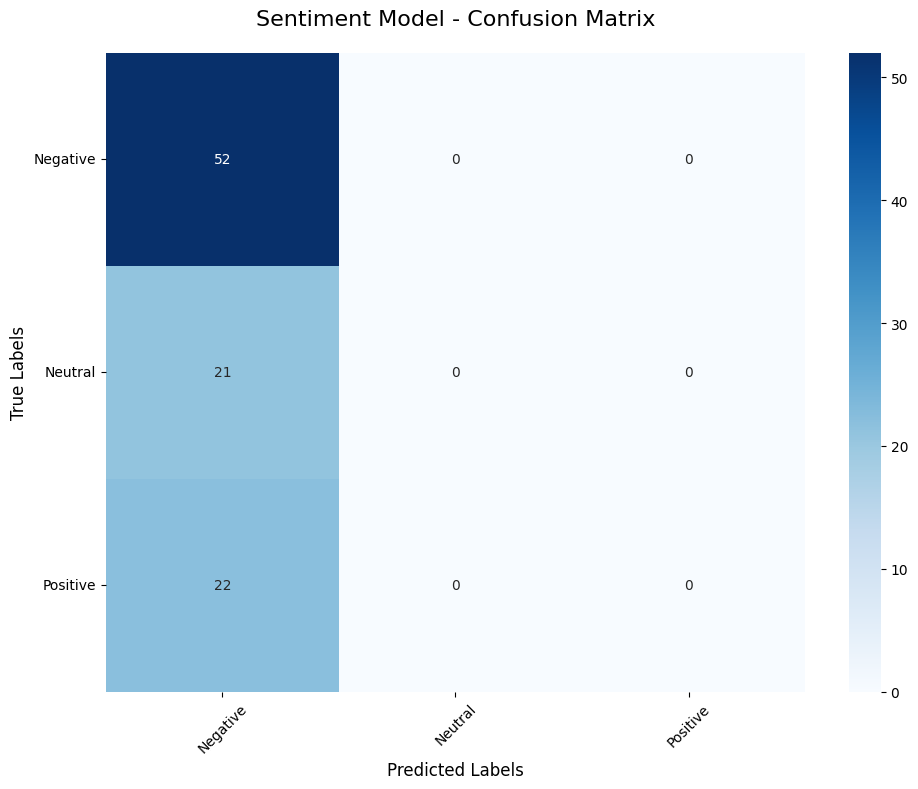

In [46]:
# Evaluate Sentiment Model
print("Evaluating Sentiment Model...")
sentiment_results = evaluate_roberta_model(
    model_dir="./roberta_sentiment_model_optimized",
    label_encoder_path="enc/sentiment_label_encoder.pkl",
    csv_file="annotated_reddit_posts.csv",
    target_column="sentiment",
    model_name="Sentiment"
)

# Plot confusion matrix for sentiment model
plot_confusion_matrix(sentiment_results, save_path="plots/roberta_sent/sentiment_confusion_matrix_eval2.png")

# Train emotion model

In [9]:
n_emotion_classes = len(set(emotion_labels))
emotion_model, emotion_trainer = trainer.train_model(
    emotion_processed, 'emotion', n_emotion_classes
)

INFO:__main__:Training RoBERTa model for emotion classification...
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:__main__:🚀 Starting emotion model training...
  5%|▌         | 100/1875 [04:10<1:14:52,  2.53s/it]

{'loss': 1.7369, 'grad_norm': 4.5536675453186035, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.16}


 11%|█         | 200/1875 [05:34<23:27,  1.19it/s]  

{'loss': 1.6319, 'grad_norm': 10.80386734008789, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.32}


 16%|█▌        | 300/1875 [06:57<21:18,  1.23it/s]

{'loss': 1.1634, 'grad_norm': 14.46703052520752, 'learning_rate': 1.2e-05, 'epoch': 0.48}


 21%|██▏       | 400/1875 [08:19<19:52,  1.24it/s]

{'loss': 0.8358, 'grad_norm': 24.81355094909668, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.64}


 27%|██▋       | 500/1875 [09:41<18:56,  1.21it/s]

{'loss': 0.7897, 'grad_norm': 10.148066520690918, 'learning_rate': 2e-05, 'epoch': 0.8}


 32%|███▏      | 600/1875 [11:03<17:13,  1.23it/s]

{'loss': 0.7683, 'grad_norm': 20.683183670043945, 'learning_rate': 1.8545454545454545e-05, 'epoch': 0.96}


                                                  
 33%|███▎      | 625/1875 [11:52<16:49,  1.24it/s]

{'eval_loss': 0.740619421005249, 'eval_accuracy': 0.7425742574257426, 'eval_f1': 0.7117151548438319, 'eval_precision': 0.7328809407361779, 'eval_recall': 0.705787558188674, 'eval_runtime': 28.5434, 'eval_samples_per_second': 60.154, 'eval_steps_per_second': 3.784, 'epoch': 1.0}


 37%|███▋      | 700/1875 [12:56<15:58,  1.23it/s]  

{'loss': 0.6679, 'grad_norm': 39.759498596191406, 'learning_rate': 1.7090909090909092e-05, 'epoch': 1.12}


 43%|████▎     | 800/1875 [14:19<14:24,  1.24it/s]

{'loss': 0.6679, 'grad_norm': 13.950936317443848, 'learning_rate': 1.563636363636364e-05, 'epoch': 1.28}


 48%|████▊     | 900/1875 [15:40<13:15,  1.23it/s]

{'loss': 0.6778, 'grad_norm': 23.070695877075195, 'learning_rate': 1.4181818181818183e-05, 'epoch': 1.44}


 53%|█████▎    | 1000/1875 [17:01<11:51,  1.23it/s]

{'loss': 0.6317, 'grad_norm': 43.74020767211914, 'learning_rate': 1.2727272727272728e-05, 'epoch': 1.6}


 59%|█████▊    | 1100/1875 [18:22<10:35,  1.22it/s]

{'loss': 0.635, 'grad_norm': 9.269413948059082, 'learning_rate': 1.1272727272727272e-05, 'epoch': 1.76}


 64%|██████▍   | 1200/1875 [19:43<08:59,  1.25it/s]

{'loss': 0.6141, 'grad_norm': 20.249832153320312, 'learning_rate': 9.81818181818182e-06, 'epoch': 1.92}


                                                   
 67%|██████▋   | 1250/1875 [20:50<08:18,  1.25it/s]

{'eval_loss': 0.6495280861854553, 'eval_accuracy': 0.7664531158998252, 'eval_f1': 0.7430420421048697, 'eval_precision': 0.7482456437128491, 'eval_recall': 0.744981692072647, 'eval_runtime': 26.5642, 'eval_samples_per_second': 64.636, 'eval_steps_per_second': 4.066, 'epoch': 2.0}


 69%|██████▉   | 1300/1875 [21:31<07:39,  1.25it/s]  

{'loss': 0.5336, 'grad_norm': 13.73919677734375, 'learning_rate': 8.363636363636365e-06, 'epoch': 2.08}


 75%|███████▍  | 1400/1875 [22:51<06:19,  1.25it/s]

{'loss': 0.4638, 'grad_norm': 17.387428283691406, 'learning_rate': 6.90909090909091e-06, 'epoch': 2.24}


 80%|████████  | 1500/1875 [24:12<05:00,  1.25it/s]

{'loss': 0.4669, 'grad_norm': 25.960472106933594, 'learning_rate': 5.4545454545454545e-06, 'epoch': 2.4}


 85%|████████▌ | 1600/1875 [25:32<03:40,  1.25it/s]

{'loss': 0.4572, 'grad_norm': 18.071807861328125, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.56}


 91%|█████████ | 1700/1875 [26:52<02:19,  1.25it/s]

{'loss': 0.4601, 'grad_norm': 20.001697540283203, 'learning_rate': 2.5454545454545456e-06, 'epoch': 2.72}


 96%|█████████▌| 1800/1875 [28:12<01:00,  1.24it/s]

{'loss': 0.457, 'grad_norm': 35.40681076049805, 'learning_rate': 1.090909090909091e-06, 'epoch': 2.88}


                                                   
100%|██████████| 1875/1875 [29:40<00:00,  1.24it/s]

{'eval_loss': 0.6570369005203247, 'eval_accuracy': 0.7740244612696564, 'eval_f1': 0.7510951876420294, 'eval_precision': 0.7517022306451588, 'eval_recall': 0.7521308515086198, 'eval_runtime': 26.5048, 'eval_samples_per_second': 64.781, 'eval_steps_per_second': 4.075, 'epoch': 3.0}


100%|██████████| 1875/1875 [29:41<00:00,  1.05it/s]


{'train_runtime': 1781.9952, 'train_samples_per_second': 16.835, 'train_steps_per_second': 1.052, 'train_loss': 0.745460292561849, 'epoch': 3.0}


INFO:__main__:✅ Emotion model training completed!


INFO:__main__:Evaluating emotion model...
INFO:__main__:
EMOTION CLASSIFICATION RESULTS:
INFO:__main__:==================================================
INFO:__main__:Accuracy:           0.1895
INFO:__main__:Precision (macro):  0.1085
INFO:__main__:Recall (macro):     0.1349
INFO:__main__:F1-score (macro):   0.1106
INFO:__main__:F1-score (weighted): 0.1557
INFO:__main__:Cohen's Kappa:      -0.0373
INFO:__main__:Confusion matrix saved to plots/emotion_confusion_matrix.png


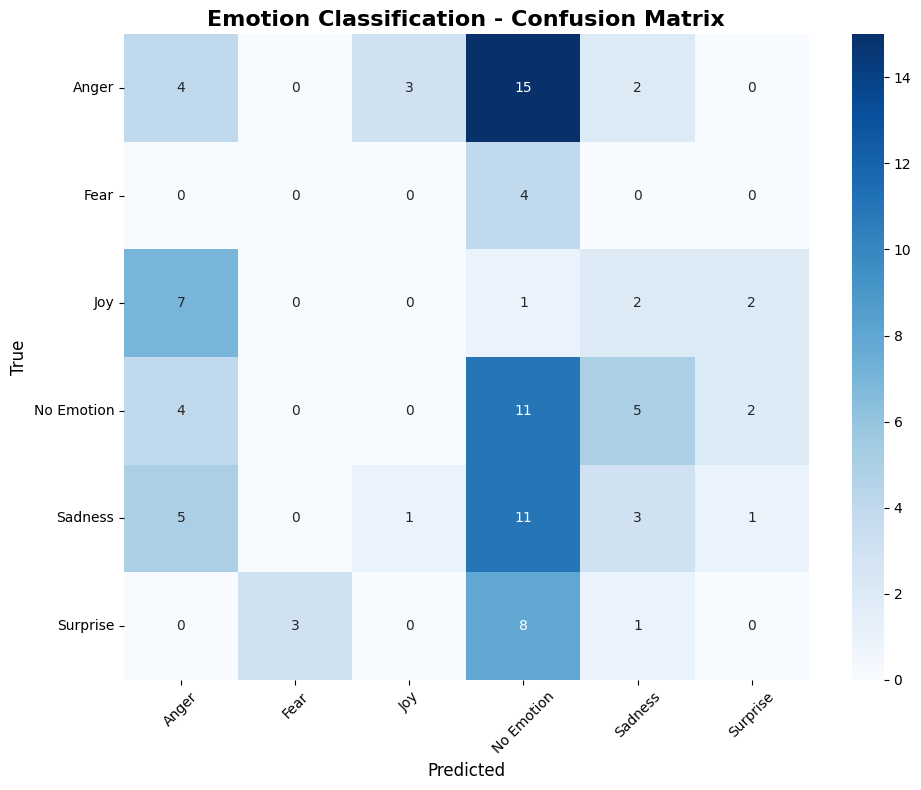

INFO:__main__:ROC curves saved to plots/emotion_roc_curves.png


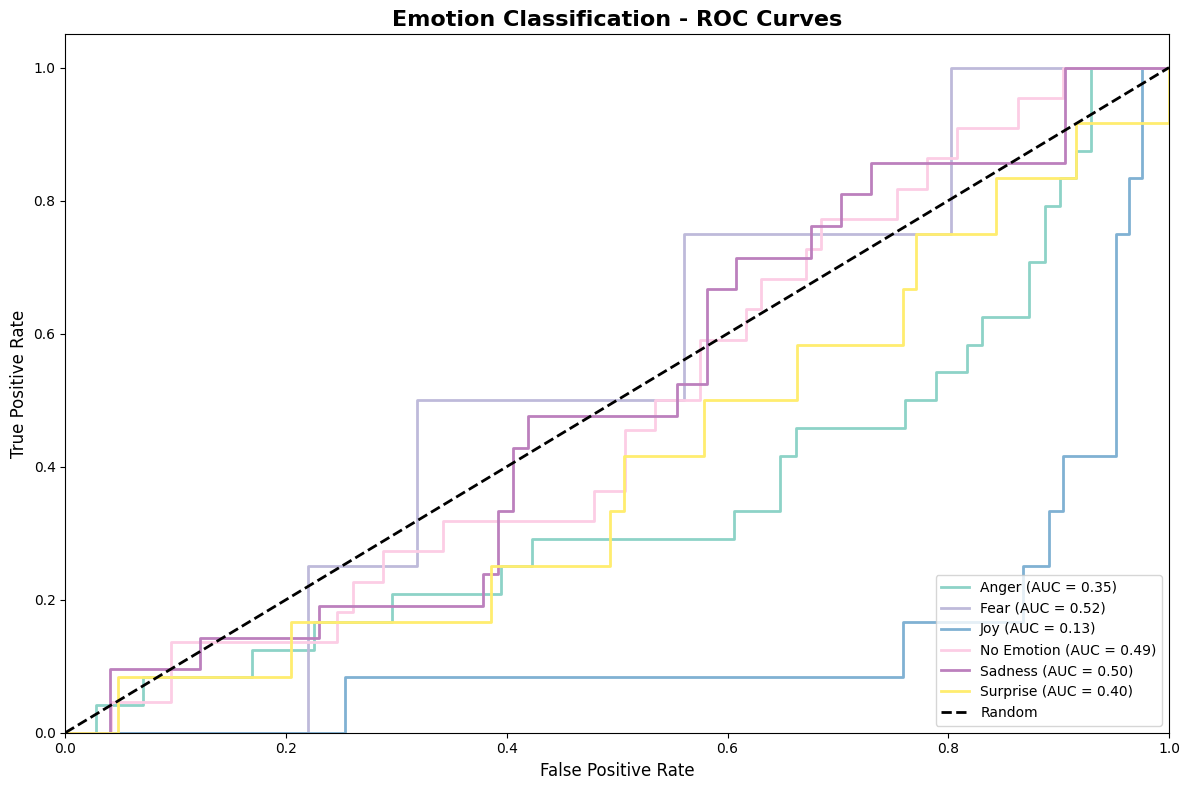

INFO:__main__:PR curves saved to plots/emotion_pr_curves.png


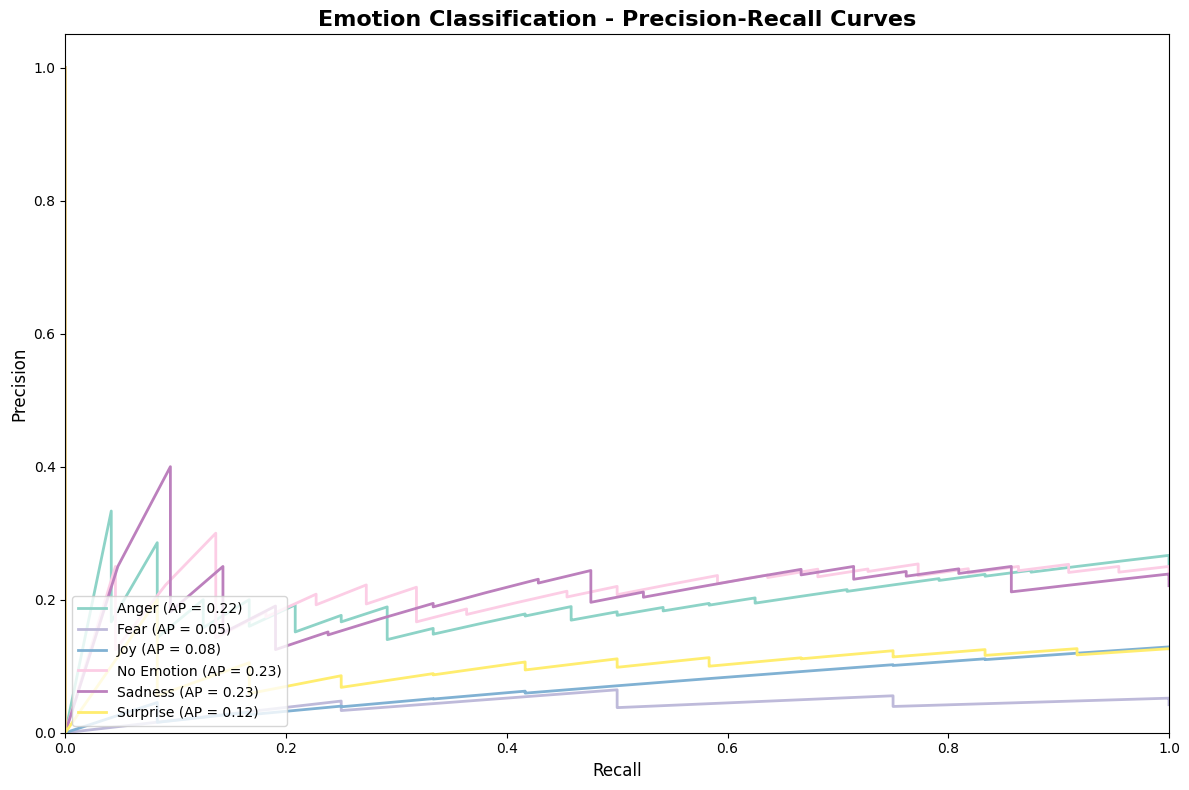

INFO:__main__:Learning curves saved to plots/emotion_learning_curves.png


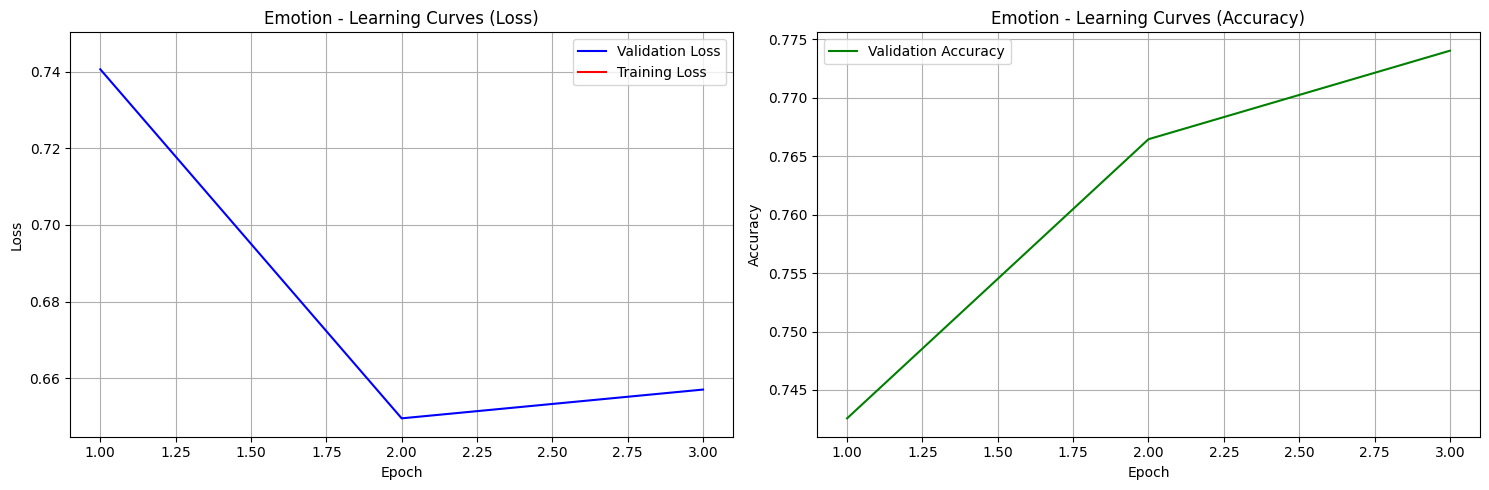

In [10]:
emotion_results = trainer.evaluate_model(
    emotion_model, emotion_texts, emotion_labels,
    'emotion', trainer.emotion_label_encoder
)

trainer.create_confusion_matrix(emotion_results, 'emotion', 'plots/emotion_confusion_matrix.png')
trainer.create_roc_curves(emotion_results, 'emotion', 'plots/emotion_roc_curves.png')
trainer.create_precision_recall_curves(emotion_results, 'emotion', 'plots/emotion_pr_curves.png')
trainer.create_learning_curves(emotion_trainer, 'emotion', 'plots/emotion_learning_curves.png')

In [ ]:
# Save model and tokenizer to a directory
save_directory = "./roberta_emotion_model"
sentiment_model.save_pretrained(save_directory)
trainer.tokenizer.save_pretrained(save_directory) 

### Load model

In [18]:
emotion_model_dir = "./roberta_emotion_model"
emotion_tokenizer = RobertaTokenizer.from_pretrained(emotion_model_dir)
emotion_model = RobertaForSequenceClassification.from_pretrained(emotion_model_dir)
emotion_label_encoder = joblib.load('enc/emotion_label_encoder.pkl')

# Set device and move models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

emotion_model = emotion_model.to(device)
emotion_model.eval()

print("✅ Models moved to device and set to eval mode!")
print("Available emotion classes:", emotion_label_encoder.classes_)

Using device: cuda
✅ Models moved to device and set to eval mode!
Available emotion classes: ['Anger' 'Fear' 'Joy' 'No Emotion' 'Sadness' 'Surprise']


#### Evaluate model

🎭 Evaluating Emotion Model...
🚀 Starting evaluation of Emotion model...
📂 Loading model and tokenizer...
🖥️ Using device: cuda
📊 Loading test data...
📋 Dataset info:
   - Total samples: 95
   - Classes: [np.str_('Anger'), np.str_('Fear'), np.str_('Joy'), np.str_('No Emotion'), np.str_('Sadness'), np.str_('Surprise')]
   - Class distribution:
     Anger: 24
     Fear: 4
     Joy: 12
     No Emotion: 22
     Sadness: 21
     Surprise: 12
🔮 Running inference...


Predicting: 100%|██████████| 95/95 [00:01<00:00, 59.74it/s]


📈 Calculating metrics...

Emotion Model Evaluation Results:
Accuracy: 0.1895
Precision (Macro): 0.1085
Recall (Macro): 0.1349
F1-Score (Macro): 0.1106
F1-Score (Weighted): 0.1557

Detailed Classification Report:
              precision    recall  f1-score   support

       Anger       0.20      0.17      0.18        24
        Fear       0.00      0.00      0.00         4
         Joy       0.00      0.00      0.00        12
  No Emotion       0.22      0.50      0.31        22
     Sadness       0.23      0.14      0.18        21
    Surprise       0.00      0.00      0.00        12

    accuracy                           0.19        95
   macro avg       0.11      0.13      0.11        95
weighted avg       0.15      0.19      0.16        95

💾 Confusion matrix saved to: plots/roberta_emo/emotion_confusion_matrix_eval.png


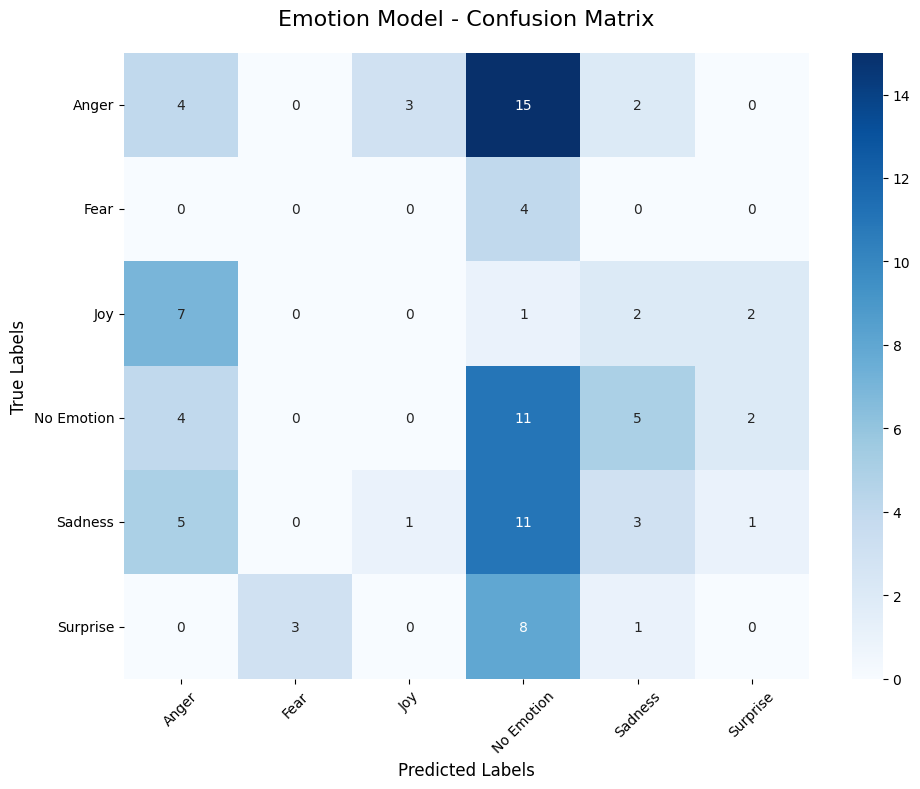

In [27]:
# Evaluate Emotion Model
print("🎭 Evaluating Emotion Model...")
emotion_results = evaluate_roberta_model(
    model_dir="./roberta_emotion_model",
    label_encoder_path="enc/emotion_label_encoder.pkl",
    csv_file="annotated_reddit_posts.csv",
    target_column="emotion",
    model_name="Emotion"
)

# Plot confusion matrix for emotion model
plot_confusion_matrix(emotion_results, save_path="plots/roberta_emo/emotion_confusion_matrix_eval.png")


#### Predict with emotion

In [37]:
def predict_emotion(text):
    preprocessed_text = preprocessor.preprocess_text(text)
    
    # Handle empty text after preprocessing
    if not preprocessed_text or len(preprocessed_text.strip()) == 0:
        return {
            'predicted_label': 'No Emotion',  # Default fallback
            'confidence': 0.0,
            'class_id': -1,
            'all_probabilities': [],
            'preprocessed_text': preprocessed_text,
            'error': 'Text became empty after preprocessing'
        }
    
    # Tokenize the preprocessed text
    inputs = emotion_tokenizer(
        preprocessed_text,  # Use preprocessed text
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )
    
    # Move tensors to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Run inference
    with torch.no_grad():
        outputs = emotion_model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predicted_class_id = logits.argmax(dim=-1).item()
    
    # Map back to original label
    predicted_label = emotion_label_encoder.inverse_transform([predicted_class_id])[0]
    confidence = probabilities[0][predicted_class_id].item()
    
    return {
        'predicted_label': predicted_label,
        'confidence': confidence,
        'class_id': predicted_class_id,
        'all_probabilities': probabilities[0].cpu().numpy(),
        'preprocessed_text': preprocessed_text,  # Show what the model actually saw
        'original_text': text  # Keep original for reference
    }

# Test with various types of input
test_cases = [
    "I absolutely love this product! 😍 It's amazing!",
    "This is terrible... I hate it so much 😠",
    "Check out https://example.com and @username for more info #awesome",
    "My phone just **exploded** while charging! WTF Samsung?!",
    "Meh, it's okay I guess. Nothing special.",
]

print("🎭 EMOTION PREDICTIONS:")
print("="*60)
for text in test_cases:
    result = predict_emotion(text)
    print(f"Original: {text}")
    print(f"Preprocessed: {result['preprocessed_text']}")
    print(f"Emotion: {result['predicted_label']} (confidence: {result['confidence']:.4f})")
    print("-" * 40)

🎭 EMOTION PREDICTIONS:
Original: I absolutely love this product! 😍 It's amazing!
Preprocessed: username love product ! username eye amazing !
Emotion: Fear (confidence: 0.9986)
----------------------------------------
Original: This is terrible... I hate it so much 😠
Preprocessed: username hate so much username
Emotion: Anger (confidence: 0.9975)
----------------------------------------
Original: Check out https://example.com and @username for more info #awesome
Preprocessed: check more info awesome
Emotion: Fear (confidence: 0.9981)
----------------------------------------
Original: My phone just **exploded** while charging! WTF Samsung?!
Preprocessed: phone username username ! wtf samsung ? !
Emotion: Anger (confidence: 0.9976)
----------------------------------------
Original: Meh, it's okay I guess. Nothing special.
Preprocessed: meh okay guess nothing special
Emotion: Anger (confidence: 0.9977)
----------------------------------------


## Hyperparameter Tuning

In [5]:
# 1. Create the tuner for the emotion task
emotion_tuner = HyperparameterTuner(
    data_path="annotated_reddit_posts.csv",  # path to your CSV
    task_type="emotion",                     # 'emotion' column in your CSV
    n_trials=30,                             # number of Optuna trials (adjust as needed)
    cv_folds=3                               # number of cross-validation folds
)

# 2. Run the hyperparameter search
emotion_study = emotion_tuner.tune()

INFO:__main__:Loaded 95 samples for emotion task
INFO:__main__:Classes: [np.str_('Anger'), np.str_('Fear'), np.str_('Joy'), np.str_('No Emotion'), np.str_('Sadness'), np.str_('Surprise')]
INFO:__main__:Number of classes: 6
INFO:__main__:Starting hyperparameter tuning for emotion task
INFO:__main__:Search space:
INFO:__main__:  - Learning rate: [1e-5, 5e-4]
INFO:__main__:  - Batch size: [8, 16, 32]
INFO:__main__:  - Dropout rate: [0.1, 0.5]
INFO:__main__:  - Epochs: [3, 8]
INFO:__main__:  - Warmup ratio: [0.05, 0.2]
INFO:__main__:  - Weight decay: [0.01, 0.3]
[I 2025-07-09 18:05:20,294] A new study created in memory with name: no-name-afe58cd1-f687-46b4-b5f3-b75737a14e53
INFO:__main__:Trial 0: lr=4.33e-05, bs=8, dropout=0.162, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie

{'eval_loss': 1.7389585971832275, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5467, 'eval_samples_per_second': 58.529, 'eval_steps_per_second': 7.316, 'epoch': 1.0}


                                               
 67%|██████▋   | 16/24 [00:09<00:03,  2.17it/s]

{'eval_loss': 1.6987565755844116, 'eval_f1': 0.17573529411764707, 'eval_runtime': 0.5344, 'eval_samples_per_second': 59.883, 'eval_steps_per_second': 7.485, 'epoch': 2.0}


                                               
100%|██████████| 24/24 [00:17<00:00,  2.09it/s]

{'eval_loss': 1.685860276222229, 'eval_f1': 0.1514616935483871, 'eval_runtime': 0.603, 'eval_samples_per_second': 53.07, 'eval_steps_per_second': 6.634, 'epoch': 3.0}


100%|██████████| 24/24 [00:20<00:00,  1.17it/s]


{'train_runtime': 20.3343, 'train_samples_per_second': 9.295, 'train_steps_per_second': 1.18, 'train_loss': 1.7274716695149739, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 11.06it/s]
INFO:__main__:    Fold 1 F1: 0.1757
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
                                              
 33%|███▎      | 8/24 [00:03<00:06,  2.43it/s]

{'eval_loss': 1.7479004859924316, 'eval_f1': 0.16953125000000002, 'eval_runtime': 0.536, 'eval_samples_per_second': 59.7, 'eval_steps_per_second': 7.463, 'epoch': 1.0}


                                               
 67%|██████▋   | 16/24 [00:09<00:03,  2.04it/s]

{'eval_loss': 1.7080869674682617, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5525, 'eval_samples_per_second': 57.92, 'eval_steps_per_second': 7.24, 'epoch': 2.0}


ERROR:__main__:    Fold 2 failed: [enforce fail at inline_container.cc:603] . unexpected pos 987893632 vs 987893520
 67%|██████▋   | 16/24 [00:18<00:09,  1.18s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 8/24 [00:04<00:07,  2.26it/s]ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })


{'eval_loss': 1.7740107774734497, 'eval_f1': 0.10587262200165426, 'eval_runtime': 0.5138, 'eval_samples_per_second': 60.339, 'eval_steps_per_second': 7.786, 'epoch': 1.0}


 33%|███▎      | 8/24 [00:04<00:08,  1.85it/s]
INFO:__main__:Trial 0 completed: Mean F1 = 0.0586 ± 0.0828
[I 2025-07-09 18:06:08,312] Trial 0 finished with value: 0.05857843137254903 and parameters: {'learning_rate': 4.3284502212938785e-05, 'batch_size': 8, 'dropout_rate': 0.1624074561769746, 'num_epochs': 3, 'warmup_ratio': 0.05871254182522992, 'weight_decay': 0.2611910822747312}. Best is trial 0 with value: 0.05857843137254903.
INFO:__main__:Trial 1: lr=1.05e-04, bs=32, dropout=0.433, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `ev

{'eval_loss': 1.7784452438354492, 'eval_f1': 0.1, 'eval_runtime': 3.9687, 'eval_samples_per_second': 8.063, 'eval_steps_per_second': 0.252, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: [enforce fail at inline_container.cc:603] . unexpected pos 52096 vs 51988
 25%|██▌       | 2/8 [00:40<02:02, 20.50s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 25%|██▌       | 2/8 [00:40<02:03, 20.57s/it]

{'eval_loss': 1.7785362005233765, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.7881, 'eval_samples_per_second': 40.602, 'eval_steps_per_second': 1.269, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 25%|██▌       | 2/8 [00:41<02:04, 20.74s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 25%|██▌       | 2/8 [00:29<01:29, 14.99s/it]

{'eval_loss': 1.7782388925552368, 'eval_f1': 0.13799283154121864, 'eval_runtime': 0.5287, 'eval_samples_per_second': 58.633, 'eval_steps_per_second': 1.891, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 25%|██▌       | 2/8 [00:30<01:31, 15.20s/it]
INFO:__main__:Trial 1 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 18:08:06,228] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 0.00010502105436744271, 'batch_size': 32, 'dropout_rate': 0.4329770563201687, 'num_epochs': 4, 'warmup_ratio': 0.0772737450810651, 'weight_decay': 0.06318730785749581}. Best is trial 0 with value: 0.05857843137254903.
INFO:__main__:Trial 2: lr=3.29e-05, bs=8, dropout=0.345, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for pr

{'eval_loss': 1.7663613557815552, 'eval_f1': 0.1, 'eval_runtime': 0.543, 'eval_samples_per_second': 58.932, 'eval_steps_per_second': 7.367, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 33%|███▎      | 8/24 [00:04<00:09,  1.78it/s]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 8/24 [00:04<00:06,  2.36it/s]

{'eval_loss': 1.7749277353286743, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5395, 'eval_samples_per_second': 59.31, 'eval_steps_per_second': 7.414, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 33%|███▎      | 8/24 [00:04<00:08,  1.83it/s]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 8/24 [00:04<00:07,  2.28it/s]

{'eval_loss': 1.777310848236084, 'eval_f1': 0.0831918505942275, 'eval_runtime': 0.5283, 'eval_samples_per_second': 58.684, 'eval_steps_per_second': 7.572, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 33%|███▎      | 8/24 [00:04<00:08,  1.83it/s]
INFO:__main__:Trial 2 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 18:08:23,425] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 3.2877474139911175e-05, 'batch_size': 8, 'dropout_rate': 0.34474115788895177, 'num_epochs': 3, 'warmup_ratio': 0.09382169728028272, 'weight_decay': 0.11624493455517058}. Best is trial 0 with value: 0.05857843137254903.
INFO:__main__:Trial 3: lr=5.95e-05, bs=8, dropout=0.337, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for 

{'eval_loss': 1.7515246868133545, 'eval_f1': 0.1, 'eval_runtime': 0.5516, 'eval_samples_per_second': 58.012, 'eval_steps_per_second': 7.251, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 33%|███▎      | 8/24 [00:04<00:08,  1.85it/s]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 8/24 [00:04<00:06,  2.34it/s]

{'eval_loss': 1.7622933387756348, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.569, 'eval_samples_per_second': 56.237, 'eval_steps_per_second': 7.03, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 33%|███▎      | 8/24 [00:04<00:08,  1.82it/s]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 8/24 [00:04<00:07,  2.25it/s]

{'eval_loss': 1.7636041641235352, 'eval_f1': 0.0831918505942275, 'eval_runtime': 0.5205, 'eval_samples_per_second': 59.553, 'eval_steps_per_second': 7.684, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 33%|███▎      | 8/24 [00:04<00:08,  1.80it/s]
INFO:__main__:Trial 3 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 18:08:40,570] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 5.954553793888986e-05, 'batch_size': 8, 'dropout_rate': 0.33696582754481696, 'num_epochs': 3, 'warmup_ratio': 0.14113172778521577, 'weight_decay': 0.059451995869314544}. Best is trial 0 with value: 0.05857843137254903.
INFO:__main__:Trial 4: lr=1.29e-05, bs=16, dropout=0.222, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

{'eval_loss': 1.782122254371643, 'eval_f1': 0.1, 'eval_runtime': 0.5315, 'eval_samples_per_second': 60.208, 'eval_steps_per_second': 3.763, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 33%|███▎      | 4/12 [00:04<00:08,  1.02s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 4/12 [00:03<00:06,  1.26it/s]

{'eval_loss': 1.7826775312423706, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5282, 'eval_samples_per_second': 60.581, 'eval_steps_per_second': 3.786, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 33%|███▎      | 4/12 [00:04<00:08,  1.01s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 4/12 [00:03<00:06,  1.23it/s]

{'eval_loss': 1.7862842082977295, 'eval_f1': 0.18192503591484915, 'eval_runtime': 0.5293, 'eval_samples_per_second': 58.565, 'eval_steps_per_second': 3.778, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 33%|███▎      | 4/12 [00:04<00:08,  1.03s/it]
INFO:__main__:Trial 4 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 18:08:56,805] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 1.289795048085554e-05, 'batch_size': 16, 'dropout_rate': 0.2218455076693483, 'num_epochs': 3, 'warmup_ratio': 0.15263495397682356, 'weight_decay': 0.13764422318448438}. Best is trial 0 with value: 0.05857843137254903.
INFO:__main__:Trial 5: lr=1.61e-05, bs=32, dropout=0.204, epochs=6
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for 

{'eval_loss': 1.7895387411117554, 'eval_f1': 0.10526315789473684, 'eval_runtime': 3.9224, 'eval_samples_per_second': 8.158, 'eval_steps_per_second': 0.255, 'epoch': 1.0}


 33%|███▎      | 4/12 [01:20<02:36, 19.59s/it]

{'eval_loss': 1.7777327299118042, 'eval_f1': 0.1, 'eval_runtime': 3.957, 'eval_samples_per_second': 8.087, 'eval_steps_per_second': 0.253, 'epoch': 2.0}


 50%|█████     | 6/12 [02:04<02:04, 20.68s/it]

{'eval_loss': 1.7664768695831299, 'eval_f1': 0.19493447580645162, 'eval_runtime': 3.9227, 'eval_samples_per_second': 8.158, 'eval_steps_per_second': 0.255, 'epoch': 3.0}


 67%|██████▋   | 8/12 [02:49<01:24, 21.12s/it]

{'eval_loss': 1.7572839260101318, 'eval_f1': 0.221580615942029, 'eval_runtime': 3.9589, 'eval_samples_per_second': 8.083, 'eval_steps_per_second': 0.253, 'epoch': 4.0}


 83%|████████▎ | 10/12 [03:33<00:42, 21.31s/it]

{'eval_loss': 1.7510499954223633, 'eval_f1': 0.22532894736842105, 'eval_runtime': 3.9337, 'eval_samples_per_second': 8.135, 'eval_steps_per_second': 0.254, 'epoch': 5.0}


100%|██████████| 12/12 [04:20<00:00, 21.44s/it]

{'eval_loss': 1.7479095458984375, 'eval_f1': 0.2491421568627451, 'eval_runtime': 3.9453, 'eval_samples_per_second': 8.111, 'eval_steps_per_second': 0.253, 'epoch': 6.0}


100%|██████████| 12/12 [04:22<00:00, 21.44s/it]

{'train_runtime': 262.4934, 'train_samples_per_second': 1.44, 'train_steps_per_second': 0.046, 'train_loss': 1.7754497528076172, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 333.23it/s]
INFO:__main__:    Fold 1 F1: 0.2491
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 17%|█▋        | 2/12 [00:27<02:15, 13.60s/it]

{'eval_loss': 1.7648332118988037, 'eval_f1': 0.1, 'eval_runtime': 0.5557, 'eval_samples_per_second': 57.587, 'eval_steps_per_second': 1.8, 'epoch': 1.0}


 33%|███▎      | 4/12 [01:03<02:01, 15.19s/it]

{'eval_loss': 1.7582823038101196, 'eval_f1': 0.1, 'eval_runtime': 3.9587, 'eval_samples_per_second': 8.083, 'eval_steps_per_second': 0.253, 'epoch': 2.0}


 50%|█████     | 6/12 [01:48<01:53, 18.96s/it]

{'eval_loss': 1.753106951713562, 'eval_f1': 0.1, 'eval_runtime': 4.2547, 'eval_samples_per_second': 7.521, 'eval_steps_per_second': 0.235, 'epoch': 3.0}


 50%|█████     | 6/12 [01:50<01:53, 18.96s/it]

{'train_runtime': 110.5914, 'train_samples_per_second': 3.418, 'train_steps_per_second': 0.109, 'train_loss': 1.7486257553100586, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 333.46it/s]
INFO:__main__:    Fold 2 F1: 0.1000
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 17%|█▋        | 2/12 [00:54<03:42, 22.27s/it]

{'eval_loss': 1.8060824871063232, 'eval_f1': 0.035595105672969966, 'eval_runtime': 13.2595, 'eval_samples_per_second': 2.338, 'eval_steps_per_second': 0.075, 'epoch': 1.0}


 33%|███▎      | 4/12 [02:06<04:02, 30.35s/it]

{'eval_loss': 1.7942454814910889, 'eval_f1': 0.030360531309297913, 'eval_runtime': 14.0234, 'eval_samples_per_second': 2.211, 'eval_steps_per_second': 0.071, 'epoch': 2.0}


 50%|█████     | 6/12 [03:15<03:15, 32.51s/it]

{'eval_loss': 1.7852140665054321, 'eval_f1': 0.1879032258064516, 'eval_runtime': 12.2477, 'eval_samples_per_second': 2.531, 'eval_steps_per_second': 0.082, 'epoch': 3.0}


 67%|██████▋   | 8/12 [04:21<02:07, 31.94s/it]

{'eval_loss': 1.778559923171997, 'eval_f1': 0.12871600253004428, 'eval_runtime': 12.1973, 'eval_samples_per_second': 2.542, 'eval_steps_per_second': 0.082, 'epoch': 4.0}


 83%|████████▎ | 10/12 [05:25<01:03, 31.51s/it]

{'eval_loss': 1.7743501663208008, 'eval_f1': 0.14782524459943816, 'eval_runtime': 11.991, 'eval_samples_per_second': 2.585, 'eval_steps_per_second': 0.083, 'epoch': 5.0}


 83%|████████▎ | 10/12 [05:28<01:05, 32.82s/it]


{'train_runtime': 327.9762, 'train_samples_per_second': 1.171, 'train_steps_per_second': 0.037, 'train_loss': 1.7969047546386718, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 332.80it/s]
INFO:__main__:    Fold 3 F1: 0.1879
INFO:__main__:Trial 5 completed: Mean F1 = 0.1790 ± 0.0612
[I 2025-07-09 18:21:03,915] Trial 5 finished with value: 0.1790151275563989 and parameters: {'learning_rate': 1.6119044727609182e-05, 'batch_size': 32, 'dropout_rate': 0.20351199264000677, 'num_epochs': 6, 'warmup_ratio': 0.09675666141341166, 'weight_decay': 0.16081972614156514}. Best is trial 5 with value: 0.1790151275563989.
INFO:__main__:Trial 6: lr=8.49e-05, bs=16, dropout=0.476, epochs=8
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\trai

{'eval_loss': 1.7785241603851318, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5367, 'eval_samples_per_second': 59.629, 'eval_steps_per_second': 3.727, 'epoch': 1.0}


 25%|██▌       | 8/32 [00:09<00:25,  1.05s/it]

{'eval_loss': 1.7568011283874512, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5122, 'eval_samples_per_second': 62.479, 'eval_steps_per_second': 3.905, 'epoch': 2.0}


 38%|███▊      | 12/32 [00:14<00:21,  1.10s/it]

{'eval_loss': 1.740480661392212, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.52, 'eval_samples_per_second': 61.54, 'eval_steps_per_second': 3.846, 'epoch': 3.0}


 38%|███▊      | 12/32 [00:17<00:21,  1.10s/it]

{'train_runtime': 17.6386, 'train_samples_per_second': 28.574, 'train_steps_per_second': 1.814, 'train_loss': 1.7976368268330891, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]
INFO:__main__:    Fold 1 F1: 0.0785
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 4/32 [00:03<00:21,  1.29it/s]

{'eval_loss': 1.7989270687103271, 'eval_f1': 0.027777777777777776, 'eval_runtime': 0.5135, 'eval_samples_per_second': 62.322, 'eval_steps_per_second': 3.895, 'epoch': 1.0}


 25%|██▌       | 8/32 [00:09<00:24,  1.03s/it]

{'eval_loss': 1.7764387130737305, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5087, 'eval_samples_per_second': 62.9, 'eval_steps_per_second': 3.931, 'epoch': 2.0}


 38%|███▊      | 12/32 [00:14<00:21,  1.07s/it]

{'eval_loss': 1.7613544464111328, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5283, 'eval_samples_per_second': 60.569, 'eval_steps_per_second': 3.786, 'epoch': 3.0}


 50%|█████     | 16/32 [00:20<00:17,  1.10s/it]

{'eval_loss': 1.7490066289901733, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.525, 'eval_samples_per_second': 60.949, 'eval_steps_per_second': 3.809, 'epoch': 4.0}


 50%|█████     | 16/32 [00:22<00:17,  1.10s/it]

{'train_runtime': 22.6486, 'train_samples_per_second': 22.253, 'train_steps_per_second': 1.413, 'train_loss': 1.798082709312439, 'epoch': 4.0}


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]
INFO:__main__:    Fold 2 F1: 0.0785
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 4/32 [00:03<00:22,  1.25it/s]

{'eval_loss': 1.7956972122192383, 'eval_f1': 0.029493087557603687, 'eval_runtime': 0.5156, 'eval_samples_per_second': 60.119, 'eval_steps_per_second': 3.879, 'epoch': 1.0}


 25%|██▌       | 8/32 [00:09<00:25,  1.06s/it]

{'eval_loss': 1.7659817934036255, 'eval_f1': 0.029493087557603687, 'eval_runtime': 0.5046, 'eval_samples_per_second': 61.431, 'eval_steps_per_second': 3.963, 'epoch': 2.0}


 38%|███▊      | 12/32 [00:15<00:23,  1.15s/it]

{'eval_loss': 1.744128942489624, 'eval_f1': 0.06451612903225806, 'eval_runtime': 0.5025, 'eval_samples_per_second': 61.696, 'eval_steps_per_second': 3.98, 'epoch': 3.0}


 50%|█████     | 16/32 [00:21<00:18,  1.15s/it]

{'eval_loss': 1.7276887893676758, 'eval_f1': 0.10587262200165426, 'eval_runtime': 0.5038, 'eval_samples_per_second': 61.531, 'eval_steps_per_second': 3.97, 'epoch': 4.0}


 62%|██████▎   | 20/32 [00:26<00:13,  1.16s/it]

{'eval_loss': 1.7154362201690674, 'eval_f1': 0.10587262200165426, 'eval_runtime': 0.4922, 'eval_samples_per_second': 62.983, 'eval_steps_per_second': 4.063, 'epoch': 5.0}


 75%|███████▌  | 24/32 [00:32<00:09,  1.16s/it]

{'eval_loss': 1.708004117012024, 'eval_f1': 0.10587262200165426, 'eval_runtime': 0.5148, 'eval_samples_per_second': 60.217, 'eval_steps_per_second': 3.885, 'epoch': 6.0}


 75%|███████▌  | 24/32 [00:35<00:09,  1.16s/it]

{'train_runtime': 35.2111, 'train_samples_per_second': 14.541, 'train_steps_per_second': 0.909, 'train_loss': 1.7587440808614094, 'epoch': 6.0}


100%|██████████| 2/2 [00:00<00:00,  8.86it/s]
INFO:__main__:    Fold 3 F1: 0.1059
INFO:__main__:Trial 6 completed: Mean F1 = 0.0876 ± 0.0129
[I 2025-07-09 18:22:26,579] Trial 6 finished with value: 0.08764130135097876 and parameters: {'learning_rate': 8.488762161408708e-05, 'batch_size': 16, 'dropout_rate': 0.4757995766256756, 'num_epochs': 8, 'warmup_ratio': 0.1396849968216628, 'weight_decay': 0.2773435281567039}. Best is trial 5 with value: 0.1790151275563989.
INFO:__main__:Trial 7: lr=1.41e-05, bs=32, dropout=0.255, epochs=4
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training

{'eval_loss': 1.7619531154632568, 'eval_f1': 0.1, 'eval_runtime': 4.1749, 'eval_samples_per_second': 7.665, 'eval_steps_per_second': 0.24, 'epoch': 1.0}


 50%|█████     | 4/8 [01:31<01:28, 22.09s/it]

{'eval_loss': 1.7560205459594727, 'eval_f1': 0.1, 'eval_runtime': 4.3931, 'eval_samples_per_second': 7.284, 'eval_steps_per_second': 0.228, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:19<00:45, 22.81s/it]

{'eval_loss': 1.7514526844024658, 'eval_f1': 0.1, 'eval_runtime': 4.4176, 'eval_samples_per_second': 7.244, 'eval_steps_per_second': 0.226, 'epoch': 3.0}


 75%|███████▌  | 6/8 [02:22<00:45, 22.81s/it]

{'train_runtime': 142.2016, 'train_samples_per_second': 1.772, 'train_steps_per_second': 0.056, 'train_loss': 1.7575262387593586, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 333.52it/s]
INFO:__main__:    Fold 1 F1: 0.1000
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 25%|██▌       | 2/8 [00:32<01:36, 16.11s/it]

{'eval_loss': 1.8042569160461426, 'eval_f1': 0.03333333333333333, 'eval_runtime': 0.5806, 'eval_samples_per_second': 55.112, 'eval_steps_per_second': 1.722, 'epoch': 1.0}


 50%|█████     | 4/8 [01:09<01:09, 17.38s/it]

{'eval_loss': 1.7963333129882812, 'eval_f1': 0.027777777777777776, 'eval_runtime': 0.5961, 'eval_samples_per_second': 53.678, 'eval_steps_per_second': 1.677, 'epoch': 2.0}


 75%|███████▌  | 6/8 [01:44<00:34, 17.38s/it]

{'eval_loss': 1.791455864906311, 'eval_f1': 0.03225806451612903, 'eval_runtime': 0.5735, 'eval_samples_per_second': 55.795, 'eval_steps_per_second': 1.744, 'epoch': 3.0}


 75%|███████▌  | 6/8 [01:47<00:35, 17.86s/it]


{'train_runtime': 106.9654, 'train_samples_per_second': 2.356, 'train_steps_per_second': 0.075, 'train_loss': 1.7977863947550456, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 333.07it/s]
INFO:__main__:    Fold 2 F1: 0.0333
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 25%|██▌       | 2/8 [00:45<01:47, 17.98s/it]

{'eval_loss': 1.806822657585144, 'eval_f1': 0.03686635944700461, 'eval_runtime': 11.305, 'eval_samples_per_second': 2.742, 'eval_steps_per_second': 0.088, 'epoch': 1.0}


 50%|█████     | 4/8 [01:43<01:37, 24.50s/it]

{'eval_loss': 1.7978551387786865, 'eval_f1': 0.029493087557603687, 'eval_runtime': 11.4697, 'eval_samples_per_second': 2.703, 'eval_steps_per_second': 0.087, 'epoch': 2.0}


 75%|███████▌  | 6/8 [02:42<00:53, 26.68s/it]

{'eval_loss': 1.7924888134002686, 'eval_f1': 0.03128054740957967, 'eval_runtime': 11.5144, 'eval_samples_per_second': 2.692, 'eval_steps_per_second': 0.087, 'epoch': 3.0}


 75%|███████▌  | 6/8 [02:44<00:53, 26.68s/it]

{'train_runtime': 164.689, 'train_samples_per_second': 1.554, 'train_steps_per_second': 0.049, 'train_loss': 1.810636043548584, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 250.00it/s]
INFO:__main__:    Fold 3 F1: 0.0369
INFO:__main__:Trial 7 completed: Mean F1 = 0.0567 ± 0.0306
[I 2025-07-09 18:29:43,272] Trial 7 finished with value: 0.056733230926779316 and parameters: {'learning_rate': 1.4136637008121852e-05, 'batch_size': 32, 'dropout_rate': 0.25547091587579285, 'num_epochs': 4, 'warmup_ratio': 0.17431062637278943, 'weight_decay': 0.11345846474114088}. Best is trial 5 with value: 0.1790151275563989.
INFO:__main__:Trial 8: lr=3.00e-05, bs=32, dropout=0.130, epochs=8
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\tr

{'eval_loss': 1.8012648820877075, 'eval_f1': 0.030303030303030304, 'eval_runtime': 3.818, 'eval_samples_per_second': 8.381, 'eval_steps_per_second': 0.262, 'epoch': 1.0}


 25%|██▌       | 4/16 [01:16<03:42, 18.58s/it]

{'eval_loss': 1.773909330368042, 'eval_f1': 0.18055555555555555, 'eval_runtime': 3.8319, 'eval_samples_per_second': 8.351, 'eval_steps_per_second': 0.261, 'epoch': 2.0}


 38%|███▊      | 6/16 [01:57<03:13, 19.32s/it]

{'eval_loss': 1.7387789487838745, 'eval_f1': 0.19901315789473684, 'eval_runtime': 3.7806, 'eval_samples_per_second': 8.464, 'eval_steps_per_second': 0.265, 'epoch': 3.0}


 50%|█████     | 8/16 [02:37<02:36, 19.57s/it]

{'eval_loss': 1.7032630443572998, 'eval_f1': 0.17083333333333334, 'eval_runtime': 3.776, 'eval_samples_per_second': 8.475, 'eval_steps_per_second': 0.265, 'epoch': 4.0}


 62%|██████▎   | 10/16 [03:18<01:57, 19.61s/it]

{'eval_loss': 1.6772770881652832, 'eval_f1': 0.23566017316017315, 'eval_runtime': 3.7727, 'eval_samples_per_second': 8.482, 'eval_steps_per_second': 0.265, 'epoch': 5.0}


 75%|███████▌  | 12/16 [03:59<01:18, 19.65s/it]

{'eval_loss': 1.6588042974472046, 'eval_f1': 0.2881944444444444, 'eval_runtime': 3.8128, 'eval_samples_per_second': 8.393, 'eval_steps_per_second': 0.262, 'epoch': 6.0}


 88%|████████▊ | 14/16 [04:39<00:39, 19.68s/it]

{'eval_loss': 1.6475929021835327, 'eval_f1': 0.27856691919191917, 'eval_runtime': 3.772, 'eval_samples_per_second': 8.484, 'eval_steps_per_second': 0.265, 'epoch': 7.0}


100%|██████████| 16/16 [05:22<00:00, 19.73s/it]

{'eval_loss': 1.6430184841156006, 'eval_f1': 0.27856691919191917, 'eval_runtime': 3.7374, 'eval_samples_per_second': 8.562, 'eval_steps_per_second': 0.268, 'epoch': 8.0}


100%|██████████| 16/16 [05:25<00:00, 19.73s/it]

{'train_runtime': 325.4068, 'train_samples_per_second': 1.549, 'train_steps_per_second': 0.049, 'train_loss': 1.7165299654006958, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 249.75it/s]
INFO:__main__:    Fold 1 F1: 0.2882
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:25<02:57, 12.71s/it]

{'eval_loss': 1.8130133152008057, 'eval_f1': 0.027777777777777776, 'eval_runtime': 0.5536, 'eval_samples_per_second': 57.804, 'eval_steps_per_second': 1.806, 'epoch': 1.0}


 25%|██▌       | 4/16 [00:55<02:47, 13.99s/it]

{'eval_loss': 1.7885146141052246, 'eval_f1': 0.0606518817204301, 'eval_runtime': 0.5331, 'eval_samples_per_second': 60.03, 'eval_steps_per_second': 1.876, 'epoch': 2.0}


 38%|███▊      | 6/16 [01:25<02:23, 14.37s/it]

{'eval_loss': 1.7577531337738037, 'eval_f1': 0.075, 'eval_runtime': 0.5406, 'eval_samples_per_second': 59.189, 'eval_steps_per_second': 1.85, 'epoch': 3.0}


 50%|█████     | 8/16 [01:55<01:56, 14.58s/it]

{'eval_loss': 1.7258377075195312, 'eval_f1': 0.15876436781609193, 'eval_runtime': 0.5318, 'eval_samples_per_second': 60.173, 'eval_steps_per_second': 1.88, 'epoch': 4.0}


 62%|██████▎   | 10/16 [02:25<01:27, 14.62s/it]

{'eval_loss': 1.7104758024215698, 'eval_f1': 0.13098659003831417, 'eval_runtime': 0.54, 'eval_samples_per_second': 59.255, 'eval_steps_per_second': 1.852, 'epoch': 5.0}


 75%|███████▌  | 12/16 [02:55<00:58, 14.63s/it]

{'eval_loss': 1.7084406614303589, 'eval_f1': 0.13098659003831417, 'eval_runtime': 0.5462, 'eval_samples_per_second': 58.585, 'eval_steps_per_second': 1.831, 'epoch': 6.0}


 75%|███████▌  | 12/16 [02:58<00:59, 14.85s/it]

{'train_runtime': 178.0048, 'train_samples_per_second': 2.831, 'train_steps_per_second': 0.09, 'train_loss': 1.7404026985168457, 'epoch': 6.0}



100%|██████████| 1/1 [00:00<00:00, 83.33it/s]
INFO:__main__:    Fold 2 F1: 0.1588
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:36<03:43, 15.99s/it]

{'eval_loss': 1.7584865093231201, 'eval_f1': 0.10587262200165426, 'eval_runtime': 5.1166, 'eval_samples_per_second': 6.059, 'eval_steps_per_second': 0.195, 'epoch': 1.0}


 25%|██▌       | 4/16 [02:01<06:37, 33.13s/it]

{'eval_loss': 1.7410690784454346, 'eval_f1': 0.10587262200165426, 'eval_runtime': 5.3708, 'eval_samples_per_second': 5.772, 'eval_steps_per_second': 0.186, 'epoch': 2.0}


 38%|███▊      | 6/16 [02:51<04:42, 28.28s/it]

{'eval_loss': 1.718334674835205, 'eval_f1': 0.19021852237252862, 'eval_runtime': 4.5824, 'eval_samples_per_second': 6.765, 'eval_steps_per_second': 0.218, 'epoch': 3.0}


 50%|█████     | 8/16 [03:41<03:30, 26.27s/it]

{'eval_loss': 1.6894752979278564, 'eval_f1': 0.15412186379928314, 'eval_runtime': 4.549, 'eval_samples_per_second': 6.815, 'eval_steps_per_second': 0.22, 'epoch': 4.0}


 62%|██████▎   | 10/16 [04:31<02:31, 25.26s/it]

{'eval_loss': 1.6655464172363281, 'eval_f1': 0.17520114294307843, 'eval_runtime': 4.5152, 'eval_samples_per_second': 6.866, 'eval_steps_per_second': 0.221, 'epoch': 5.0}


 62%|██████▎   | 10/16 [04:34<02:31, 25.26s/it]

{'train_runtime': 274.0944, 'train_samples_per_second': 1.868, 'train_steps_per_second': 0.058, 'train_loss': 1.7322233200073243, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 333.60it/s]
INFO:__main__:    Fold 3 F1: 0.1902
INFO:__main__:Trial 8 completed: Mean F1 = 0.2124 ± 0.0551
[I 2025-07-09 18:42:55,824] Trial 8 finished with value: 0.2123924448776883 and parameters: {'learning_rate': 3.001230180898045e-05, 'batch_size': 32, 'dropout_rate': 0.12982025747190834, 'num_epochs': 8, 'warmup_ratio': 0.16583671539449862, 'weight_decay': 0.06762754764491}. Best is trial 8 with value: 0.2123924448776883.
INFO:__main__:Trial 9: lr=1.02e-05, bs=8, dropout=0.409, epochs=3
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_

{'eval_loss': 1.7824326753616333, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.6057, 'eval_samples_per_second': 52.834, 'eval_steps_per_second': 6.604, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:10<00:03,  2.12it/s]

{'eval_loss': 1.7790597677230835, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.523, 'eval_samples_per_second': 61.189, 'eval_steps_per_second': 7.649, 'epoch': 2.0}


100%|██████████| 24/24 [00:17<00:00,  2.13it/s]

{'eval_loss': 1.7776479721069336, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.6215, 'eval_samples_per_second': 51.49, 'eval_steps_per_second': 6.436, 'epoch': 3.0}


100%|██████████| 24/24 [00:20<00:00,  2.13it/s]

{'train_runtime': 20.3149, 'train_samples_per_second': 9.304, 'train_steps_per_second': 1.181, 'train_loss': 1.792091687520345, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 10.06it/s]
INFO:__main__:    Fold 1 F1: 0.0785
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 8/24 [00:03<00:06,  2.43it/s]

{'eval_loss': 1.8028314113616943, 'eval_f1': 0.03333333333333333, 'eval_runtime': 0.53, 'eval_samples_per_second': 60.383, 'eval_steps_per_second': 7.548, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:09<00:03,  2.13it/s]

{'eval_loss': 1.799241542816162, 'eval_f1': 0.027777777777777776, 'eval_runtime': 0.5302, 'eval_samples_per_second': 60.356, 'eval_steps_per_second': 7.544, 'epoch': 2.0}


100%|██████████| 24/24 [00:17<00:00,  2.09it/s]

{'eval_loss': 1.7982070446014404, 'eval_f1': 0.027777777777777776, 'eval_runtime': 0.6192, 'eval_samples_per_second': 51.679, 'eval_steps_per_second': 6.46, 'epoch': 3.0}


100%|██████████| 24/24 [00:20<00:00,  2.09it/s]

{'train_runtime': 20.1609, 'train_samples_per_second': 9.375, 'train_steps_per_second': 1.19, 'train_loss': 1.8308491706848145, 'epoch': 3.0}


100%|██████████| 4/4 [00:00<00:00, 11.12it/s]
INFO:__main__:    Fold 2 F1: 0.0333
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 8/24 [00:03<00:06,  2.32it/s]

{'eval_loss': 1.8052185773849487, 'eval_f1': 0.035595105672969966, 'eval_runtime': 0.5157, 'eval_samples_per_second': 60.111, 'eval_steps_per_second': 7.756, 'epoch': 1.0}


 67%|██████▋   | 16/24 [00:09<00:03,  2.06it/s]

{'eval_loss': 1.80131995677948, 'eval_f1': 0.030360531309297913, 'eval_runtime': 0.5175, 'eval_samples_per_second': 59.909, 'eval_steps_per_second': 7.73, 'epoch': 2.0}


100%|██████████| 24/24 [00:17<00:00,  2.02it/s]

{'eval_loss': 1.8001116514205933, 'eval_f1': 0.029493087557603687, 'eval_runtime': 0.5906, 'eval_samples_per_second': 52.485, 'eval_steps_per_second': 6.772, 'epoch': 3.0}


100%|██████████| 24/24 [00:20<00:00,  1.18it/s]

{'train_runtime': 20.1416, 'train_samples_per_second': 9.533, 'train_steps_per_second': 1.192, 'train_loss': 1.7857297261555989, 'epoch': 3.0}



100%|██████████| 4/4 [00:00<00:00, 10.63it/s]
INFO:__main__:    Fold 3 F1: 0.0356
INFO:__main__:Trial 9 completed: Mean F1 = 0.0492 ± 0.0208
[I 2025-07-09 18:44:03,030] Trial 9 finished with value: 0.049151360010648106 and parameters: {'learning_rate': 1.0218376758008082e-05, 'batch_size': 8, 'dropout_rate': 0.4085081386743783, 'num_epochs': 3, 'warmup_ratio': 0.1037698592816409, 'weight_decay': 0.04360202726228762}. Best is trial 8 with value: 0.2123924448776883.
INFO:__main__:Trial 10: lr=4.03e-04, bs=32, dropout=0.103, epochs=8
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\trai

{'eval_loss': 1.751961350440979, 'eval_f1': 0.32748803827751194, 'eval_runtime': 0.5089, 'eval_samples_per_second': 62.879, 'eval_steps_per_second': 1.965, 'epoch': 1.0}


 25%|██▌       | 4/16 [00:59<02:59, 14.93s/it]

{'eval_loss': 1.7401646375656128, 'eval_f1': 0.0805921052631579, 'eval_runtime': 0.5256, 'eval_samples_per_second': 60.884, 'eval_steps_per_second': 1.903, 'epoch': 2.0}


 38%|███▊      | 6/16 [01:30<02:32, 15.29s/it]

{'eval_loss': 1.6650761365890503, 'eval_f1': 0.1, 'eval_runtime': 0.5179, 'eval_samples_per_second': 61.792, 'eval_steps_per_second': 1.931, 'epoch': 3.0}


 38%|███▊      | 6/16 [01:33<02:32, 15.29s/it]

{'train_runtime': 93.2272, 'train_samples_per_second': 5.406, 'train_steps_per_second': 0.172, 'train_loss': 1.7422221501668294, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 198.90it/s]
INFO:__main__:    Fold 1 F1: 0.3275
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:34<03:41, 15.84s/it]

{'eval_loss': 1.7676966190338135, 'eval_f1': 0.1, 'eval_runtime': 3.9959, 'eval_samples_per_second': 8.008, 'eval_steps_per_second': 0.25, 'epoch': 1.0}


 25%|██▌       | 4/16 [01:15<03:39, 18.33s/it]

{'eval_loss': 1.7414051294326782, 'eval_f1': 0.07852564102564102, 'eval_runtime': 4.0579, 'eval_samples_per_second': 7.886, 'eval_steps_per_second': 0.246, 'epoch': 2.0}


 38%|███▊      | 6/16 [01:56<03:11, 19.19s/it]

{'eval_loss': 1.702589988708496, 'eval_f1': 0.21791187739463602, 'eval_runtime': 4.0415, 'eval_samples_per_second': 7.918, 'eval_steps_per_second': 0.247, 'epoch': 3.0}


 50%|█████     | 8/16 [02:38<02:37, 19.72s/it]

{'eval_loss': 1.7037118673324585, 'eval_f1': 0.19560810810810814, 'eval_runtime': 4.0079, 'eval_samples_per_second': 7.984, 'eval_steps_per_second': 0.25, 'epoch': 4.0}


 62%|██████▎   | 10/16 [03:19<01:58, 19.76s/it]

{'eval_loss': 1.7385494709014893, 'eval_f1': 0.1, 'eval_runtime': 4.0425, 'eval_samples_per_second': 7.916, 'eval_steps_per_second': 0.247, 'epoch': 5.0}


 62%|██████▎   | 10/16 [03:22<02:01, 20.21s/it]

{'train_runtime': 201.9483, 'train_samples_per_second': 2.496, 'train_steps_per_second': 0.079, 'train_loss': 1.7151006698608398, 'epoch': 5.0}



100%|██████████| 1/1 [00:00<00:00, 249.82it/s]
INFO:__main__:    Fold 2 F1: 0.2179
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:25<02:55, 12.52s/it]

{'eval_loss': 1.7261781692504883, 'eval_f1': 0.0831918505942275, 'eval_runtime': 0.5041, 'eval_samples_per_second': 61.5, 'eval_steps_per_second': 1.984, 'epoch': 1.0}


 25%|██▌       | 4/16 [00:55<02:50, 14.24s/it]

{'eval_loss': 1.7042958736419678, 'eval_f1': 0.13352977667493796, 'eval_runtime': 0.4941, 'eval_samples_per_second': 62.737, 'eval_steps_per_second': 2.024, 'epoch': 2.0}


 38%|███▊      | 6/16 [01:26<02:26, 14.70s/it]

{'eval_loss': 1.6667696237564087, 'eval_f1': 0.10587262200165426, 'eval_runtime': 0.4927, 'eval_samples_per_second': 62.921, 'eval_steps_per_second': 2.03, 'epoch': 3.0}


 50%|█████     | 8/16 [01:57<01:59, 14.99s/it]

{'eval_loss': 1.6892595291137695, 'eval_f1': 0.16332055041732463, 'eval_runtime': 0.5074, 'eval_samples_per_second': 61.097, 'eval_steps_per_second': 1.971, 'epoch': 4.0}


 62%|██████▎   | 10/16 [02:28<01:30, 15.13s/it]

{'eval_loss': 1.651179313659668, 'eval_f1': 0.08369659982563209, 'eval_runtime': 0.4868, 'eval_samples_per_second': 63.682, 'eval_steps_per_second': 2.054, 'epoch': 5.0}


 75%|███████▌  | 12/16 [02:58<01:00, 15.16s/it]

{'eval_loss': 1.6351557970046997, 'eval_f1': 0.219554061385487, 'eval_runtime': 0.5021, 'eval_samples_per_second': 61.747, 'eval_steps_per_second': 1.992, 'epoch': 6.0}


 88%|████████▊ | 14/16 [03:29<00:30, 15.22s/it]

{'eval_loss': 1.6161611080169678, 'eval_f1': 0.2185364154803883, 'eval_runtime': 0.5122, 'eval_samples_per_second': 60.52, 'eval_steps_per_second': 1.952, 'epoch': 7.0}


100%|██████████| 16/16 [04:03<00:00, 15.27s/it]

{'eval_loss': 1.63548743724823, 'eval_f1': 0.23526881720430107, 'eval_runtime': 0.5962, 'eval_samples_per_second': 51.996, 'eval_steps_per_second': 1.677, 'epoch': 8.0}


100%|██████████| 16/16 [04:05<00:00, 15.27s/it]

{'train_runtime': 245.7838, 'train_samples_per_second': 2.083, 'train_steps_per_second': 0.065, 'train_loss': 1.680232048034668, 'epoch': 8.0}


100%|██████████| 1/1 [00:00<00:00, 333.94it/s]
INFO:__main__:    Fold 3 F1: 0.2353
INFO:__main__:Trial 10 completed: Mean F1 = 0.2602 ± 0.0481
[I 2025-07-09 18:53:15,480] Trial 10 finished with value: 0.26022291095881633 and parameters: {'learning_rate': 0.00040342112732689046, 'batch_size': 32, 'dropout_rate': 0.10301892772651727, 'num_epochs': 8, 'warmup_ratio': 0.19689280812412632, 'weight_decay': 0.2101716513350521}. Best is trial 10 with value: 0.26022291095881633.
INFO:__main__:Trial 11: lr=4.58e-04, bs=32, dropout=0.114, epochs=8
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers

{'eval_loss': 1.7499313354492188, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5396, 'eval_samples_per_second': 59.298, 'eval_steps_per_second': 1.853, 'epoch': 1.0}


 25%|██▌       | 4/16 [00:54<02:44, 13.74s/it]

{'eval_loss': 1.6803324222564697, 'eval_f1': 0.10256410256410256, 'eval_runtime': 0.5164, 'eval_samples_per_second': 61.962, 'eval_steps_per_second': 1.936, 'epoch': 2.0}


 38%|███▊      | 6/16 [01:23<02:21, 14.10s/it]

{'eval_loss': 1.6753106117248535, 'eval_f1': 0.1, 'eval_runtime': 0.4934, 'eval_samples_per_second': 64.862, 'eval_steps_per_second': 2.027, 'epoch': 3.0}


 50%|█████     | 8/16 [01:53<01:55, 14.38s/it]

{'eval_loss': 1.6663275957107544, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5369, 'eval_samples_per_second': 59.6, 'eval_steps_per_second': 1.863, 'epoch': 4.0}


 50%|█████     | 8/16 [01:56<01:55, 14.38s/it]

{'train_runtime': 116.2753, 'train_samples_per_second': 4.335, 'train_steps_per_second': 0.138, 'train_loss': 1.753048062324524, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 333.41it/s]
INFO:__main__:    Fold 1 F1: 0.1026
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:24<02:52, 12.32s/it]

{'eval_loss': 1.757577657699585, 'eval_f1': 0.1, 'eval_runtime': 0.5084, 'eval_samples_per_second': 62.938, 'eval_steps_per_second': 1.967, 'epoch': 1.0}


 25%|██▌       | 4/16 [00:53<02:44, 13.67s/it]

{'eval_loss': 1.7178593873977661, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.517, 'eval_samples_per_second': 61.901, 'eval_steps_per_second': 1.934, 'epoch': 2.0}


 38%|███▊      | 6/16 [01:24<02:24, 14.40s/it]

{'eval_loss': 1.6769367456436157, 'eval_f1': 0.18495475113122173, 'eval_runtime': 0.5097, 'eval_samples_per_second': 62.779, 'eval_steps_per_second': 1.962, 'epoch': 3.0}


 50%|█████     | 8/16 [01:54<01:55, 14.46s/it]

{'eval_loss': 1.8769865036010742, 'eval_f1': 0.1, 'eval_runtime': 0.5116, 'eval_samples_per_second': 62.55, 'eval_steps_per_second': 1.955, 'epoch': 4.0}


 62%|██████▎   | 10/16 [02:24<01:26, 14.46s/it]

{'eval_loss': 1.7086971998214722, 'eval_f1': 0.1472222222222222, 'eval_runtime': 0.5219, 'eval_samples_per_second': 61.318, 'eval_steps_per_second': 1.916, 'epoch': 5.0}


 62%|██████▎   | 10/16 [02:26<01:26, 14.46s/it]

{'train_runtime': 146.7314, 'train_samples_per_second': 3.435, 'train_steps_per_second': 0.109, 'train_loss': 1.7286514282226562, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 333.36it/s]
INFO:__main__:    Fold 2 F1: 0.1850
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:25<02:55, 12.56s/it]

{'eval_loss': 1.7233043909072876, 'eval_f1': 0.0831918505942275, 'eval_runtime': 0.4637, 'eval_samples_per_second': 66.852, 'eval_steps_per_second': 2.157, 'epoch': 1.0}


 25%|██▌       | 4/16 [00:56<02:52, 14.38s/it]

{'eval_loss': 1.7231336832046509, 'eval_f1': 0.13352977667493796, 'eval_runtime': 0.4754, 'eval_samples_per_second': 65.208, 'eval_steps_per_second': 2.103, 'epoch': 2.0}


 38%|███▊      | 6/16 [01:26<02:28, 14.86s/it]

{'eval_loss': 1.6637991666793823, 'eval_f1': 0.1359898798228969, 'eval_runtime': 0.4961, 'eval_samples_per_second': 62.482, 'eval_steps_per_second': 2.016, 'epoch': 3.0}


 50%|█████     | 8/16 [01:58<02:01, 15.19s/it]

{'eval_loss': 1.6639035940170288, 'eval_f1': 0.10587262200165426, 'eval_runtime': 0.5014, 'eval_samples_per_second': 61.821, 'eval_steps_per_second': 1.994, 'epoch': 4.0}


 62%|██████▎   | 10/16 [02:29<01:31, 15.27s/it]

{'eval_loss': 1.6695715188980103, 'eval_f1': 0.10587262200165426, 'eval_runtime': 0.5017, 'eval_samples_per_second': 61.795, 'eval_steps_per_second': 1.993, 'epoch': 5.0}


 62%|██████▎   | 10/16 [02:31<01:31, 15.27s/it]

{'train_runtime': 151.9723, 'train_samples_per_second': 3.369, 'train_steps_per_second': 0.105, 'train_loss': 1.755375289916992, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 249.97it/s]
INFO:__main__:    Fold 3 F1: 0.1360
INFO:__main__:Trial 11 completed: Mean F1 = 0.1412 ± 0.0338
[I 2025-07-09 19:00:19,141] Trial 11 finished with value: 0.14116957783940706 and parameters: {'learning_rate': 0.0004582492152363402, 'batch_size': 32, 'dropout_rate': 0.11374880414738701, 'num_epochs': 8, 'warmup_ratio': 0.19936077917648606, 'weight_decay': 0.21217521051862737}. Best is trial 10 with value: 0.26022291095881633.
INFO:__main__:Trial 12: lr=4.16e-04, bs=32, dropout=0.107, epochs=7
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers

{'eval_loss': 1.7120472192764282, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5166, 'eval_samples_per_second': 61.94, 'eval_steps_per_second': 1.936, 'epoch': 1.0}


 29%|██▊       | 4/14 [00:54<02:17, 13.70s/it]

{'eval_loss': 1.662113070487976, 'eval_f1': 0.17083333333333334, 'eval_runtime': 0.5196, 'eval_samples_per_second': 61.588, 'eval_steps_per_second': 1.925, 'epoch': 2.0}


 43%|████▎     | 6/14 [01:23<01:53, 14.17s/it]

{'eval_loss': 1.6765453815460205, 'eval_f1': 0.20526315789473684, 'eval_runtime': 0.5212, 'eval_samples_per_second': 61.391, 'eval_steps_per_second': 1.918, 'epoch': 3.0}


 57%|█████▋    | 8/14 [01:53<01:26, 14.36s/it]

{'eval_loss': 1.6711393594741821, 'eval_f1': 0.1, 'eval_runtime': 0.5332, 'eval_samples_per_second': 60.014, 'eval_steps_per_second': 1.875, 'epoch': 4.0}


 71%|███████▏  | 10/14 [02:23<00:57, 14.41s/it]

{'eval_loss': 1.685562014579773, 'eval_f1': 0.1, 'eval_runtime': 0.518, 'eval_samples_per_second': 61.775, 'eval_steps_per_second': 1.93, 'epoch': 5.0}


 71%|███████▏  | 10/14 [02:25<00:58, 14.60s/it]


{'train_runtime': 145.7827, 'train_samples_per_second': 3.025, 'train_steps_per_second': 0.096, 'train_loss': 1.761224365234375, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 333.44it/s]
INFO:__main__:    Fold 1 F1: 0.2053
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:24<02:28, 12.36s/it]

{'eval_loss': 1.7288267612457275, 'eval_f1': 0.1, 'eval_runtime': 0.5158, 'eval_samples_per_second': 62.039, 'eval_steps_per_second': 1.939, 'epoch': 1.0}


 29%|██▊       | 4/14 [00:56<02:17, 13.79s/it]

{'eval_loss': 1.9246376752853394, 'eval_f1': 0.07852564102564102, 'eval_runtime': 2.5573, 'eval_samples_per_second': 12.513, 'eval_steps_per_second': 0.391, 'epoch': 2.0}


 43%|████▎     | 6/14 [01:43<02:28, 18.62s/it]

{'eval_loss': 1.6886394023895264, 'eval_f1': 0.10256410256410256, 'eval_runtime': 4.4296, 'eval_samples_per_second': 7.224, 'eval_steps_per_second': 0.226, 'epoch': 3.0}


 57%|█████▋    | 8/14 [02:31<02:05, 20.98s/it]

{'eval_loss': 1.7228248119354248, 'eval_f1': 0.15554298642533937, 'eval_runtime': 4.4552, 'eval_samples_per_second': 7.183, 'eval_steps_per_second': 0.224, 'epoch': 4.0}


 71%|███████▏  | 10/14 [03:16<01:25, 21.41s/it]

{'eval_loss': 1.70867121219635, 'eval_f1': 0.1, 'eval_runtime': 4.1955, 'eval_samples_per_second': 7.627, 'eval_steps_per_second': 0.238, 'epoch': 5.0}


 86%|████████▌ | 12/14 [04:00<00:43, 21.53s/it]

{'eval_loss': 1.7031866312026978, 'eval_f1': 0.1, 'eval_runtime': 4.2318, 'eval_samples_per_second': 7.562, 'eval_steps_per_second': 0.236, 'epoch': 6.0}


 86%|████████▌ | 12/14 [04:03<00:43, 21.53s/it]

{'train_runtime': 243.3115, 'train_samples_per_second': 1.812, 'train_steps_per_second': 0.058, 'train_loss': 1.708166281382243, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 333.33it/s]
INFO:__main__:    Fold 2 F1: 0.1555
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:35<03:14, 16.19s/it]

{'eval_loss': 1.716052532196045, 'eval_f1': 0.10587262200165426, 'eval_runtime': 3.7403, 'eval_samples_per_second': 8.288, 'eval_steps_per_second': 0.267, 'epoch': 1.0}


 29%|██▊       | 4/14 [01:17<03:09, 18.97s/it]

{'eval_loss': 1.713409662246704, 'eval_f1': 0.19259962049335863, 'eval_runtime': 3.756, 'eval_samples_per_second': 8.253, 'eval_steps_per_second': 0.266, 'epoch': 2.0}


 43%|████▎     | 6/14 [01:59<02:38, 19.84s/it]

{'eval_loss': 1.6894491910934448, 'eval_f1': 0.10587262200165426, 'eval_runtime': 3.7778, 'eval_samples_per_second': 8.206, 'eval_steps_per_second': 0.265, 'epoch': 3.0}


 57%|█████▋    | 8/14 [03:22<02:49, 28.21s/it]

{'eval_loss': 1.6347566843032837, 'eval_f1': 0.23325062034739455, 'eval_runtime': 17.9211, 'eval_samples_per_second': 1.73, 'eval_steps_per_second': 0.056, 'epoch': 4.0}


 71%|███████▏  | 10/14 [05:07<02:40, 40.08s/it]

{'eval_loss': 1.6251832246780396, 'eval_f1': 0.20161290322580644, 'eval_runtime': 17.5282, 'eval_samples_per_second': 1.769, 'eval_steps_per_second': 0.057, 'epoch': 5.0}


 86%|████████▌ | 12/14 [06:51<01:30, 45.07s/it]

{'eval_loss': 1.623002052307129, 'eval_f1': 0.15415632754342432, 'eval_runtime': 19.7143, 'eval_samples_per_second': 1.572, 'eval_steps_per_second': 0.051, 'epoch': 6.0}


 86%|████████▌ | 12/14 [06:53<01:08, 34.47s/it]


{'train_runtime': 413.5502, 'train_samples_per_second': 1.083, 'train_steps_per_second': 0.034, 'train_loss': 1.7068328857421875, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]
INFO:__main__:    Fold 3 F1: 0.2333
INFO:__main__:Trial 12 completed: Mean F1 = 0.1980 ± 0.0321
[I 2025-07-09 19:14:13,520] Trial 12 finished with value: 0.19801892155582357 and parameters: {'learning_rate': 0.00041582181971836196, 'batch_size': 32, 'dropout_rate': 0.10665233549314655, 'num_epochs': 7, 'warmup_ratio': 0.1992385407391199, 'weight_decay': 0.20098018609371326}. Best is trial 10 with value: 0.26022291095881633.
INFO:__main__:Trial 13: lr=1.88e-04, bs=32, dropout=0.159, epochs=7
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers

{'eval_loss': 1.7391386032104492, 'eval_f1': 0.21955128205128205, 'eval_runtime': 5.3183, 'eval_samples_per_second': 6.017, 'eval_steps_per_second': 0.188, 'epoch': 1.0}


 29%|██▊       | 4/14 [01:50<04:25, 26.55s/it]

{'eval_loss': 1.6464909315109253, 'eval_f1': 0.1938813813813814, 'eval_runtime': 4.406, 'eval_samples_per_second': 7.263, 'eval_steps_per_second': 0.227, 'epoch': 2.0}


 43%|████▎     | 6/14 [02:36<03:14, 24.29s/it]

{'eval_loss': 1.6305959224700928, 'eval_f1': 0.16129032258064516, 'eval_runtime': 4.451, 'eval_samples_per_second': 7.189, 'eval_steps_per_second': 0.225, 'epoch': 3.0}


 43%|████▎     | 6/14 [02:39<03:14, 24.29s/it]

{'train_runtime': 159.3927, 'train_samples_per_second': 2.767, 'train_steps_per_second': 0.088, 'train_loss': 1.7258717219034831, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00, 499.44it/s]
INFO:__main__:    Fold 1 F1: 0.2196
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:36<03:17, 16.47s/it]

{'eval_loss': 1.7825422286987305, 'eval_f1': 0.1, 'eval_runtime': 3.8649, 'eval_samples_per_second': 8.28, 'eval_steps_per_second': 0.259, 'epoch': 1.0}


 29%|██▊       | 4/14 [01:16<03:05, 18.55s/it]

{'eval_loss': 1.7096872329711914, 'eval_f1': 0.1, 'eval_runtime': 3.897, 'eval_samples_per_second': 8.211, 'eval_steps_per_second': 0.257, 'epoch': 2.0}


 43%|████▎     | 6/14 [01:56<02:32, 19.05s/it]

{'eval_loss': 1.707290768623352, 'eval_f1': 0.27, 'eval_runtime': 3.8836, 'eval_samples_per_second': 8.24, 'eval_steps_per_second': 0.257, 'epoch': 3.0}


 57%|█████▋    | 8/14 [02:37<01:56, 19.41s/it]

{'eval_loss': 1.7293808460235596, 'eval_f1': 0.2019675925925926, 'eval_runtime': 3.8833, 'eval_samples_per_second': 8.24, 'eval_steps_per_second': 0.258, 'epoch': 4.0}


 71%|███████▏  | 10/14 [03:17<01:18, 19.51s/it]

{'eval_loss': 1.69407320022583, 'eval_f1': 0.19493447580645162, 'eval_runtime': 3.8622, 'eval_samples_per_second': 8.285, 'eval_steps_per_second': 0.259, 'epoch': 5.0}


 71%|███████▏  | 10/14 [03:20<01:20, 20.00s/it]


{'train_runtime': 199.9291, 'train_samples_per_second': 2.206, 'train_steps_per_second': 0.07, 'train_loss': 1.709719467163086, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 499.98it/s]
INFO:__main__:    Fold 2 F1: 0.2700
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:34<03:09, 15.80s/it]

{'eval_loss': 1.7477754354476929, 'eval_f1': 0.0831918505942275, 'eval_runtime': 3.7518, 'eval_samples_per_second': 8.263, 'eval_steps_per_second': 0.267, 'epoch': 1.0}


 29%|██▊       | 4/14 [01:15<03:07, 18.79s/it]

{'eval_loss': 1.652207374572754, 'eval_f1': 0.18989387869843277, 'eval_runtime': 3.7295, 'eval_samples_per_second': 8.312, 'eval_steps_per_second': 0.268, 'epoch': 2.0}


 43%|████▎     | 6/14 [02:07<03:00, 22.58s/it]

{'eval_loss': 1.7562569379806519, 'eval_f1': 0.16511035653650255, 'eval_runtime': 5.0846, 'eval_samples_per_second': 6.097, 'eval_steps_per_second': 0.197, 'epoch': 3.0}


 57%|█████▋    | 8/14 [03:11<02:43, 27.21s/it]

{'eval_loss': 1.6275519132614136, 'eval_f1': 0.2913978494623656, 'eval_runtime': 5.1546, 'eval_samples_per_second': 6.014, 'eval_steps_per_second': 0.194, 'epoch': 4.0}


 71%|███████▏  | 10/14 [04:05<01:47, 26.88s/it]

{'eval_loss': 1.6320570707321167, 'eval_f1': 0.20487012368870303, 'eval_runtime': 4.9425, 'eval_samples_per_second': 6.272, 'eval_steps_per_second': 0.202, 'epoch': 5.0}


 86%|████████▌ | 12/14 [05:04<00:55, 27.80s/it]

{'eval_loss': 1.6899337768554688, 'eval_f1': 0.19319390287132224, 'eval_runtime': 4.7927, 'eval_samples_per_second': 6.468, 'eval_steps_per_second': 0.209, 'epoch': 6.0}


 86%|████████▌ | 12/14 [05:07<00:55, 27.80s/it]

{'train_runtime': 307.9151, 'train_samples_per_second': 1.455, 'train_steps_per_second': 0.045, 'train_loss': 1.6430079142252605, 'epoch': 6.0}


100%|██████████| 1/1 [00:00<00:00, 284.82it/s]
INFO:__main__:    Fold 3 F1: 0.2914
INFO:__main__:Trial 13 completed: Mean F1 = 0.2603 ± 0.0301
[I 2025-07-09 19:25:39,430] Trial 13 finished with value: 0.26031637717121586 and parameters: {'learning_rate': 0.00018843871051154592, 'batch_size': 32, 'dropout_rate': 0.15859725997693935, 'num_epochs': 7, 'warmup_ratio': 0.16826426457074994, 'weight_decay': 0.21559177659152684}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 14: lr=2.05e-04, bs=32, dropout=0.178, epochs=7
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformer

{'eval_loss': 1.7399873733520508, 'eval_f1': 0.19722222222222222, 'eval_runtime': 5.4492, 'eval_samples_per_second': 5.872, 'eval_steps_per_second': 0.184, 'epoch': 1.0}


 29%|██▊       | 4/14 [01:48<04:21, 26.13s/it]

{'eval_loss': 1.6573677062988281, 'eval_f1': 0.22398989898989896, 'eval_runtime': 4.6492, 'eval_samples_per_second': 6.883, 'eval_steps_per_second': 0.215, 'epoch': 2.0}


 43%|████▎     | 6/14 [02:51<03:51, 28.92s/it]

{'eval_loss': 1.6315423250198364, 'eval_f1': 0.1305239898989899, 'eval_runtime': 5.0379, 'eval_samples_per_second': 6.352, 'eval_steps_per_second': 0.198, 'epoch': 3.0}


 57%|█████▋    | 8/14 [03:47<02:45, 27.61s/it]

{'eval_loss': 1.6461713314056396, 'eval_f1': 0.12916666666666668, 'eval_runtime': 4.6116, 'eval_samples_per_second': 6.939, 'eval_steps_per_second': 0.217, 'epoch': 4.0}


 57%|█████▋    | 8/14 [03:49<02:45, 27.61s/it]

{'train_runtime': 229.5619, 'train_samples_per_second': 1.921, 'train_steps_per_second': 0.061, 'train_loss': 1.7262647151947021, 'epoch': 4.0}


100%|██████████| 1/1 [00:00<00:00, 333.30it/s]
INFO:__main__:    Fold 1 F1: 0.2240
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:39<03:36, 18.07s/it]

{'eval_loss': 1.7818479537963867, 'eval_f1': 0.027777777777777776, 'eval_runtime': 4.2577, 'eval_samples_per_second': 7.516, 'eval_steps_per_second': 0.235, 'epoch': 1.0}


 29%|██▊       | 4/14 [01:28<03:41, 22.14s/it]

{'eval_loss': 1.7094120979309082, 'eval_f1': 0.1, 'eval_runtime': 4.5157, 'eval_samples_per_second': 7.086, 'eval_steps_per_second': 0.221, 'epoch': 2.0}


 43%|████▎     | 6/14 [02:25<03:20, 25.01s/it]

{'eval_loss': 1.688677430152893, 'eval_f1': 0.1723901098901099, 'eval_runtime': 5.5057, 'eval_samples_per_second': 5.812, 'eval_steps_per_second': 0.182, 'epoch': 3.0}


 57%|█████▋    | 8/14 [03:23<02:41, 26.94s/it]

{'eval_loss': 1.6845024824142456, 'eval_f1': 0.15088383838383837, 'eval_runtime': 5.1871, 'eval_samples_per_second': 6.169, 'eval_steps_per_second': 0.193, 'epoch': 4.0}


 71%|███████▏  | 10/14 [04:21<01:46, 26.58s/it]

{'eval_loss': 1.663541555404663, 'eval_f1': 0.18495475113122173, 'eval_runtime': 8.8339, 'eval_samples_per_second': 3.622, 'eval_steps_per_second': 0.113, 'epoch': 5.0}


 86%|████████▌ | 12/14 [05:17<00:54, 27.13s/it]

{'eval_loss': 1.6433639526367188, 'eval_f1': 0.2204861111111111, 'eval_runtime': 6.2068, 'eval_samples_per_second': 5.156, 'eval_steps_per_second': 0.161, 'epoch': 6.0}


100%|██████████| 14/14 [06:13<00:00, 26.83s/it]

{'eval_loss': 1.6329072713851929, 'eval_f1': 0.1961996336996337, 'eval_runtime': 4.8418, 'eval_samples_per_second': 6.609, 'eval_steps_per_second': 0.207, 'epoch': 7.0}


100%|██████████| 14/14 [06:16<00:00, 26.83s/it]

{'train_runtime': 376.5151, 'train_samples_per_second': 1.171, 'train_steps_per_second': 0.037, 'train_loss': 1.684798104422433, 'epoch': 7.0}


100%|██████████| 1/1 [00:00<00:00, 333.04it/s]
INFO:__main__:    Fold 2 F1: 0.2205
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:44<04:03, 20.30s/it]

{'eval_loss': 1.7706061601638794, 'eval_f1': 0.0831918505942275, 'eval_runtime': 4.6476, 'eval_samples_per_second': 6.67, 'eval_steps_per_second': 0.215, 'epoch': 1.0}


 29%|██▊       | 4/14 [01:43<04:13, 25.38s/it]

{'eval_loss': 1.7026480436325073, 'eval_f1': 0.10587262200165426, 'eval_runtime': 6.8295, 'eval_samples_per_second': 4.539, 'eval_steps_per_second': 0.146, 'epoch': 2.0}


 43%|████▎     | 6/14 [02:46<03:44, 28.06s/it]

{'eval_loss': 1.6457715034484863, 'eval_f1': 0.22574357039552287, 'eval_runtime': 8.6878, 'eval_samples_per_second': 3.568, 'eval_steps_per_second': 0.115, 'epoch': 3.0}


 57%|█████▋    | 8/14 [04:13<03:30, 35.04s/it]

{'eval_loss': 1.634846568107605, 'eval_f1': 0.10587262200165426, 'eval_runtime': 13.3199, 'eval_samples_per_second': 2.327, 'eval_steps_per_second': 0.075, 'epoch': 4.0}


 71%|███████▏  | 10/14 [05:52<02:45, 41.34s/it]

{'eval_loss': 1.6268622875213623, 'eval_f1': 0.21115786192925043, 'eval_runtime': 14.8718, 'eval_samples_per_second': 2.084, 'eval_steps_per_second': 0.067, 'epoch': 5.0}


 71%|███████▏  | 10/14 [05:54<02:45, 41.34s/it]

{'train_runtime': 354.7458, 'train_samples_per_second': 1.263, 'train_steps_per_second': 0.039, 'train_loss': 1.712021255493164, 'epoch': 5.0}


100%|██████████| 1/1 [00:00<00:00, 250.51it/s]
INFO:__main__:    Fold 3 F1: 0.2257
INFO:__main__:Trial 14 completed: Mean F1 = 0.2234 ± 0.0022
[I 2025-07-09 19:42:11,962] Trial 14 finished with value: 0.22340652683217765 and parameters: {'learning_rate': 0.00020486876181579884, 'batch_size': 32, 'dropout_rate': 0.17839432791833792, 'num_epochs': 7, 'warmup_ratio': 0.17866984406716108, 'weight_decay': 0.22688077098601836}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 15: lr=2.19e-04, bs=32, dropout=0.265, epochs=6
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformer

{'eval_loss': 1.7517242431640625, 'eval_f1': 0.11990489130434782, 'eval_runtime': 4.3273, 'eval_samples_per_second': 7.395, 'eval_steps_per_second': 0.231, 'epoch': 1.0}


 33%|███▎      | 4/12 [01:21<02:38, 19.76s/it]

{'eval_loss': 1.6671829223632812, 'eval_f1': 0.1, 'eval_runtime': 4.4509, 'eval_samples_per_second': 7.19, 'eval_steps_per_second': 0.225, 'epoch': 2.0}


 50%|█████     | 6/12 [02:08<02:07, 21.19s/it]

{'eval_loss': 1.6694376468658447, 'eval_f1': 0.17597853535353536, 'eval_runtime': 5.1691, 'eval_samples_per_second': 6.191, 'eval_steps_per_second': 0.193, 'epoch': 3.0}


ERROR:__main__:    Fold 1 failed: [enforce fail at inline_container.cc:603] . unexpected pos 969018880 vs 969018768
 50%|█████     | 6/12 [02:10<02:10, 21.72s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 17%|█▋        | 2/12 [00:32<02:41, 16.14s/it]

{'eval_loss': 1.7897292375564575, 'eval_f1': 0.040178571428571425, 'eval_runtime': 0.6724, 'eval_samples_per_second': 47.589, 'eval_steps_per_second': 1.487, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: [enforce fail at inline_container.cc:603] . unexpected pos 470626048 vs 470625936
 17%|█▋        | 2/12 [00:33<02:48, 16.86s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 17%|█▋        | 2/12 [00:39<02:54, 17.49s/it]

{'eval_loss': 1.7582393884658813, 'eval_f1': 0.14193548387096774, 'eval_runtime': 3.9736, 'eval_samples_per_second': 7.802, 'eval_steps_per_second': 0.252, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 17%|█▋        | 2/12 [00:39<03:18, 19.83s/it]
INFO:__main__:Trial 15 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 19:45:41,253] Trial 15 finished with value: 0.0 and parameters: {'learning_rate': 0.00021926155262006172, 'batch_size': 32, 'dropout_rate': 0.26545577461146186, 'num_epochs': 6, 'warmup_ratio': 0.12456280904162789, 'weight_decay': 0.2989733865740448}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 16: lr=2.21e-04, bs=16, dropout=0.156, epochs=7
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it

{'eval_loss': 1.6940244436264038, 'eval_f1': 0.23055555555555554, 'eval_runtime': 0.539, 'eval_samples_per_second': 59.373, 'eval_steps_per_second': 3.711, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 4/28 [00:07<00:43,  1.82s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 4/28 [00:03<00:18,  1.28it/s]

{'eval_loss': 1.724922776222229, 'eval_f1': 0.11955705705705705, 'eval_runtime': 0.5305, 'eval_samples_per_second': 60.324, 'eval_steps_per_second': 3.77, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 4/28 [00:04<00:24,  1.01s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 4/28 [00:03<00:18,  1.28it/s]

{'eval_loss': 1.732386589050293, 'eval_f1': 0.0831918505942275, 'eval_runtime': 0.4932, 'eval_samples_per_second': 62.851, 'eval_steps_per_second': 4.055, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 4/28 [00:04<00:24,  1.00s/it]
INFO:__main__:Trial 16 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 19:46:00,772] Trial 16 finished with value: 0.0 and parameters: {'learning_rate': 0.00022133298034401853, 'batch_size': 16, 'dropout_rate': 0.15552513502103524, 'num_epochs': 7, 'warmup_ratio': 0.18444439214576905, 'weight_decay': 0.18582974427302634}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 17: lr=1.43e-04, bs=32, dropout=0.228, epochs=7
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use i

{'eval_loss': 1.7723584175109863, 'eval_f1': 0.1, 'eval_runtime': 0.5187, 'eval_samples_per_second': 61.697, 'eval_steps_per_second': 1.928, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 2/14 [00:28<02:49, 14.16s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:34<03:10, 15.84s/it]

{'eval_loss': 1.7753608226776123, 'eval_f1': 0.07852564102564102, 'eval_runtime': 3.7146, 'eval_samples_per_second': 8.615, 'eval_steps_per_second': 0.269, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 2/14 [00:35<03:30, 17.57s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:25<02:35, 12.93s/it]

{'eval_loss': 1.7754287719726562, 'eval_f1': 0.13799283154121864, 'eval_runtime': 0.5133, 'eval_samples_per_second': 60.389, 'eval_steps_per_second': 1.948, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 2/14 [00:26<02:38, 13.20s/it]
INFO:__main__:Trial 17 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 19:47:36,141] Trial 17 finished with value: 0.0 and parameters: {'learning_rate': 0.00014301089345959453, 'batch_size': 32, 'dropout_rate': 0.2283400714479269, 'num_epochs': 7, 'warmup_ratio': 0.15754614803609, 'weight_decay': 0.24044715559250585}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 18: lr=3.49e-04, bs=32, dropout=0.303, epochs=5
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it fo

{'eval_loss': 1.7423019409179688, 'eval_f1': 0.1, 'eval_runtime': 0.5233, 'eval_samples_per_second': 61.153, 'eval_steps_per_second': 1.911, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 20%|██        | 2/10 [00:26<01:46, 13.30s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 2/10 [00:26<01:44, 13.01s/it]

{'eval_loss': 1.7592685222625732, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.543, 'eval_samples_per_second': 58.934, 'eval_steps_per_second': 1.842, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 20%|██        | 2/10 [00:26<01:46, 13.26s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 2/10 [00:35<02:12, 16.54s/it]

{'eval_loss': 1.7498083114624023, 'eval_f1': 0.16426799007444168, 'eval_runtime': 3.8061, 'eval_samples_per_second': 8.145, 'eval_steps_per_second': 0.263, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 20%|██        | 2/10 [00:36<02:24, 18.08s/it]
INFO:__main__:Trial 18 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 19:49:11,586] Trial 18 finished with value: 0.0 and parameters: {'learning_rate': 0.0003487790282552209, 'batch_size': 32, 'dropout_rate': 0.30328699317204705, 'num_epochs': 5, 'warmup_ratio': 0.18674141738773392, 'weight_decay': 0.17414562979590886}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 19: lr=2.93e-04, bs=16, dropout=0.100, epochs=6
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it

{'eval_loss': 1.765810489654541, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5345, 'eval_samples_per_second': 59.874, 'eval_steps_per_second': 3.742, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 17%|█▋        | 4/24 [00:04<00:20,  1.03s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 17%|█▋        | 4/24 [00:03<00:15,  1.29it/s]

{'eval_loss': 1.839672327041626, 'eval_f1': 0.1, 'eval_runtime': 0.525, 'eval_samples_per_second': 60.954, 'eval_steps_per_second': 3.81, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 17%|█▋        | 4/24 [00:04<00:20,  1.01s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 17%|█▋        | 4/24 [00:03<00:16,  1.24it/s]

{'eval_loss': 1.6949859857559204, 'eval_f1': 0.0831918505942275, 'eval_runtime': 0.5046, 'eval_samples_per_second': 61.437, 'eval_steps_per_second': 3.964, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 17%|█▋        | 4/24 [00:04<00:20,  1.03s/it]
INFO:__main__:Trial 19 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 19:49:29,175] Trial 19 finished with value: 0.0 and parameters: {'learning_rate': 0.0002926236033282458, 'batch_size': 16, 'dropout_rate': 0.10034112928958691, 'num_epochs': 6, 'warmup_ratio': 0.12224845552440619, 'weight_decay': 0.2506266652897917}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 20: lr=1.36e-04, bs=32, dropout=0.189, epochs=8
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it 

{'eval_loss': 1.7717781066894531, 'eval_f1': 0.1, 'eval_runtime': 3.9205, 'eval_samples_per_second': 8.162, 'eval_steps_per_second': 0.255, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 12%|█▎        | 2/16 [00:38<04:27, 19.11s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:26<03:07, 13.42s/it]

{'eval_loss': 1.7745939493179321, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5475, 'eval_samples_per_second': 58.447, 'eval_steps_per_second': 1.826, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 12%|█▎        | 2/16 [00:27<03:11, 13.65s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:31<03:15, 13.95s/it]

{'eval_loss': 1.775566816329956, 'eval_f1': 0.0831918505942275, 'eval_runtime': 3.9976, 'eval_samples_per_second': 7.755, 'eval_steps_per_second': 0.25, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 12%|█▎        | 2/16 [00:31<03:42, 15.89s/it]
INFO:__main__:Trial 20 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 19:51:11,798] Trial 20 finished with value: 0.0 and parameters: {'learning_rate': 0.00013578098854174082, 'batch_size': 32, 'dropout_rate': 0.18936703980358466, 'num_epochs': 8, 'warmup_ratio': 0.14134374205994069, 'weight_decay': 0.016871669336691347}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 21: lr=2.19e-04, bs=32, dropout=0.162, epochs=7
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use 

{'eval_loss': 1.7539138793945312, 'eval_f1': 0.1, 'eval_runtime': 0.5289, 'eval_samples_per_second': 60.508, 'eval_steps_per_second': 1.891, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 2/14 [00:27<02:44, 13.73s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:27<02:44, 13.68s/it]

{'eval_loss': 1.7622820138931274, 'eval_f1': 0.205506993006993, 'eval_runtime': 0.5476, 'eval_samples_per_second': 58.44, 'eval_steps_per_second': 1.826, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 2/14 [00:27<02:46, 13.85s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:36<03:18, 16.53s/it]

{'eval_loss': 1.7631539106369019, 'eval_f1': 0.0831918505942275, 'eval_runtime': 3.7427, 'eval_samples_per_second': 8.283, 'eval_steps_per_second': 0.267, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 2/14 [00:36<03:38, 18.17s/it]
INFO:__main__:Trial 21 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 19:52:48,824] Trial 21 finished with value: 0.0 and parameters: {'learning_rate': 0.00021857825159644797, 'batch_size': 32, 'dropout_rate': 0.16176503706288933, 'num_epochs': 7, 'warmup_ratio': 0.17925494819960694, 'weight_decay': 0.22339118975387742}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 22: lr=1.58e-04, bs=32, dropout=0.149, epochs=7
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use i

{'eval_loss': 1.7627942562103271, 'eval_f1': 0.13645833333333335, 'eval_runtime': 0.5888, 'eval_samples_per_second': 54.349, 'eval_steps_per_second': 1.698, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 2/14 [00:27<02:44, 13.72s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:29<02:56, 14.75s/it]

{'eval_loss': 1.7690221071243286, 'eval_f1': 0.19147877984084882, 'eval_runtime': 0.5215, 'eval_samples_per_second': 61.364, 'eval_steps_per_second': 1.918, 'epoch': 1.0}


ERROR:__main__:    Fold 2 failed: [enforce fail at inline_container.cc:603] . unexpected pos 52096 vs 51988
 14%|█▍        | 2/14 [00:30<03:02, 15.20s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:36<03:22, 16.91s/it]

{'eval_loss': 1.7691340446472168, 'eval_f1': 0.08544027898866609, 'eval_runtime': 3.6809, 'eval_samples_per_second': 8.422, 'eval_steps_per_second': 0.272, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 2/14 [00:36<03:39, 18.30s/it]
INFO:__main__:Trial 22 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 19:54:28,748] Trial 22 finished with value: 0.0 and parameters: {'learning_rate': 0.00015788228933738516, 'batch_size': 32, 'dropout_rate': 0.1486178883357264, 'num_epochs': 7, 'warmup_ratio': 0.17019756180772866, 'weight_decay': 0.22638010984381768}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 23: lr=3.06e-04, bs=32, dropout=0.183, epochs=8
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it

{'eval_loss': 1.757026195526123, 'eval_f1': 0.1, 'eval_runtime': 0.5573, 'eval_samples_per_second': 57.423, 'eval_steps_per_second': 1.794, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 12%|█▎        | 2/16 [00:28<03:19, 14.24s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:43<04:41, 20.08s/it]ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is

{'eval_loss': 1.7616537809371948, 'eval_f1': 0.205506993006993, 'eval_runtime': 4.3117, 'eval_samples_per_second': 7.422, 'eval_steps_per_second': 0.232, 'epoch': 1.0}


 12%|█▎        | 2/16 [00:43<05:03, 21.66s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:31<03:39, 15.65s/it]ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })


{'eval_loss': 1.763057827949524, 'eval_f1': 0.0831918505942275, 'eval_runtime': 0.6184, 'eval_samples_per_second': 50.126, 'eval_steps_per_second': 1.617, 'epoch': 1.0}


 12%|█▎        | 2/16 [00:31<03:41, 15.82s/it]
INFO:__main__:Trial 23 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 19:56:16,664] Trial 23 finished with value: 0.0 and parameters: {'learning_rate': 0.00030644792787580614, 'batch_size': 32, 'dropout_rate': 0.1825802688270066, 'num_epochs': 8, 'warmup_ratio': 0.1880415585652948, 'weight_decay': 0.19534325633898023}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 24: lr=4.83e-04, bs=32, dropout=0.138, epochs=6
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_st

{'eval_loss': 1.692118525505066, 'eval_f1': 0.25504032258064513, 'eval_runtime': 0.5463, 'eval_samples_per_second': 58.578, 'eval_steps_per_second': 1.831, 'epoch': 1.0}


ERROR:__main__:    Fold 1 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 17%|█▋        | 2/12 [00:28<02:20, 14.07s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 17%|█▋        | 2/12 [00:27<02:18, 13.83s/it]ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is

{'eval_loss': 1.7188475131988525, 'eval_f1': 0.1, 'eval_runtime': 0.5452, 'eval_samples_per_second': 58.697, 'eval_steps_per_second': 1.834, 'epoch': 1.0}


 17%|█▋        | 2/12 [00:27<02:19, 13.95s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 17%|█▋        | 2/12 [00:27<02:17, 13.74s/it]

{'eval_loss': 1.7009937763214111, 'eval_f1': 0.0878136200716846, 'eval_runtime': 0.5136, 'eval_samples_per_second': 60.36, 'eval_steps_per_second': 1.947, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 17%|█▋        | 2/12 [00:27<02:18, 13.85s/it]
INFO:__main__:Trial 24 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 19:57:45,140] Trial 24 finished with value: 0.0 and parameters: {'learning_rate': 0.0004832259207239242, 'batch_size': 32, 'dropout_rate': 0.13790606408875286, 'num_epochs': 6, 'warmup_ratio': 0.1642921577144462, 'weight_decay': 0.1461102073225686}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 25: lr=1.80e-04, bs=32, dropout=0.263, epochs=7
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

{'eval_loss': 1.7692302465438843, 'eval_f1': 0.1, 'eval_runtime': 3.9536, 'eval_samples_per_second': 8.094, 'eval_steps_per_second': 0.253, 'epoch': 1.0}


 14%|█▍        | 2/14 [00:36<03:41, 18.46s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:26<02:36, 13.05s/it]ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })


{'eval_loss': 1.773647665977478, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5411, 'eval_samples_per_second': 59.136, 'eval_steps_per_second': 1.848, 'epoch': 1.0}


 14%|█▍        | 2/14 [00:26<02:38, 13.24s/it]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 2/14 [00:25<02:34, 12.88s/it]

{'eval_loss': 1.7736790180206299, 'eval_f1': 0.13799283154121864, 'eval_runtime': 0.5085, 'eval_samples_per_second': 60.965, 'eval_steps_per_second': 1.967, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 14%|█▍        | 2/14 [00:26<02:36, 13.07s/it]
INFO:__main__:Trial 25 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 19:59:18,713] Trial 25 finished with value: 0.0 and parameters: {'learning_rate': 0.00017979324255783445, 'batch_size': 32, 'dropout_rate': 0.26271529827614126, 'num_epochs': 7, 'warmup_ratio': 0.19977568471048368, 'weight_decay': 0.2720175815483347}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 26: lr=1.06e-04, bs=32, dropout=0.227, epochs=5
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it

{'eval_loss': 1.7707221508026123, 'eval_f1': 0.1, 'eval_runtime': 0.5309, 'eval_samples_per_second': 60.278, 'eval_steps_per_second': 1.884, 'epoch': 1.0}


 20%|██        | 2/10 [00:26<01:44, 13.11s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 2/10 [00:25<01:43, 12.91s/it]


{'eval_loss': 1.774064540863037, 'eval_f1': 0.1352796052631579, 'eval_runtime': 0.5427, 'eval_samples_per_second': 58.96, 'eval_steps_per_second': 1.843, 'epoch': 1.0}


INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 2/10 [00:46<02:29, 18.64s/it]

{'eval_loss': 1.7732510566711426, 'eval_f1': 0.13799283154121864, 'eval_runtime': 11.3027, 'eval_samples_per_second': 2.743, 'eval_steps_per_second': 0.088, 'epoch': 1.0}


 40%|████      | 4/10 [01:45<02:30, 25.08s/it]

{'eval_loss': 1.702149510383606, 'eval_f1': 0.10587262200165426, 'eval_runtime': 11.3121, 'eval_samples_per_second': 2.74, 'eval_steps_per_second': 0.088, 'epoch': 2.0}


ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })
 40%|████      | 4/10 [01:45<02:38, 26.34s/it]
INFO:__main__:Trial 26 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 20:02:00,183] Trial 26 finished with value: 0.0 and parameters: {'learning_rate': 0.00010556944686638888, 'batch_size': 32, 'dropout_rate': 0.2265169267746095, 'num_epochs': 5, 'warmup_ratio': 0.15269172368655531, 'weight_decay': 0.235478343898087}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 27: lr=2.68e-04, bs=32, dropout=0.187, epochs=8
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

{'eval_loss': 1.7992256879806519, 'eval_f1': 0.027777777777777776, 'eval_runtime': 3.8666, 'eval_samples_per_second': 8.276, 'eval_steps_per_second': 0.259, 'epoch': 1.0}


 12%|█▎        | 2/16 [00:35<04:06, 17.64s/it]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:25<03:01, 12.93s/it]


{'eval_loss': 1.7656351327896118, 'eval_f1': 0.16157670454545453, 'eval_runtime': 0.5226, 'eval_samples_per_second': 61.236, 'eval_steps_per_second': 1.914, 'epoch': 1.0}


INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 2/16 [00:26<03:04, 13.16s/it]

{'eval_loss': 1.7672091722488403, 'eval_f1': 0.0831918505942275, 'eval_runtime': 0.5217, 'eval_samples_per_second': 59.425, 'eval_steps_per_second': 1.917, 'epoch': 1.0}


ERROR:__main__:    Fold 3 failed: [enforce fail at inline_container.cc:603] . unexpected pos 52096 vs 51988
 12%|█▎        | 2/16 [00:26<03:07, 13.41s/it]
INFO:__main__:Trial 27 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 20:03:32,998] Trial 27 finished with value: 0.0 and parameters: {'learning_rate': 0.00026840467334980644, 'batch_size': 32, 'dropout_rate': 0.18666642698648053, 'num_epochs': 8, 'warmup_ratio': 0.1876764352726849, 'weight_decay': 0.1732209417556911}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 28: lr=6.60e-05, bs=8, dropout=0.129, epochs=7
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixi

{'eval_loss': 1.7367204427719116, 'eval_f1': 0.07852564102564102, 'eval_runtime': 0.5304, 'eval_samples_per_second': 60.328, 'eval_steps_per_second': 7.541, 'epoch': 1.0}


 14%|█▍        | 8/56 [00:04<00:24,  1.94it/s]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 8/56 [00:03<00:19,  2.46it/s]ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })


{'eval_loss': 1.7456949949264526, 'eval_f1': 0.14685314685314688, 'eval_runtime': 0.5271, 'eval_samples_per_second': 60.708, 'eval_steps_per_second': 7.588, 'epoch': 1.0}


 14%|█▍        | 8/56 [00:04<00:24,  1.97it/s]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 14%|█▍        | 8/56 [00:03<00:20,  2.33it/s]ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })


{'eval_loss': 1.7436552047729492, 'eval_f1': 0.0831918505942275, 'eval_runtime': 0.5157, 'eval_samples_per_second': 60.107, 'eval_steps_per_second': 7.756, 'epoch': 1.0}


 14%|█▍        | 8/56 [00:04<00:24,  1.94it/s]
INFO:__main__:Trial 28 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 20:03:48,359] Trial 28 finished with value: 0.0 and parameters: {'learning_rate': 6.602526202114962e-05, 'batch_size': 8, 'dropout_rate': 0.1292475878884701, 'num_epochs': 7, 'warmup_ratio': 0.1757046842385932, 'weight_decay': 0.20741158694793566}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Trial 29: lr=3.71e-04, bs=16, dropout=0.170, epochs=6
INFO:__main__:  Fold 1/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_stra

{'eval_loss': 1.6671539545059204, 'eval_f1': 0.1, 'eval_runtime': 0.5221, 'eval_samples_per_second': 61.286, 'eval_steps_per_second': 3.83, 'epoch': 1.0}


 17%|█▋        | 4/24 [00:03<00:19,  1.05it/s]
INFO:__main__:  Fold 2/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 17%|█▋        | 4/24 [00:03<00:15,  1.30it/s]ERROR:__main__:    Fold 2 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })


{'eval_loss': 1.798673391342163, 'eval_f1': 0.1, 'eval_runtime': 0.5359, 'eval_samples_per_second': 59.713, 'eval_steps_per_second': 3.732, 'epoch': 1.0}


 17%|█▋        | 4/24 [00:03<00:19,  1.05it/s]
INFO:__main__:  Fold 3/3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hankaixin\Desktop\multitask\env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 17%|█▋        | 4/24 [00:03<00:15,  1.25it/s]ERROR:__main__:    Fold 3 failed: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })


{'eval_loss': 1.7057788372039795, 'eval_f1': 0.0831918505942275, 'eval_runtime': 0.5224, 'eval_samples_per_second': 59.343, 'eval_steps_per_second': 3.829, 'epoch': 1.0}


 17%|█▋        | 4/24 [00:03<00:19,  1.03it/s]
INFO:__main__:Trial 29 completed: Mean F1 = 0.0000 ± 0.0000
[I 2025-07-09 20:04:02,893] Trial 29 finished with value: 0.0 and parameters: {'learning_rate': 0.00037097867093689225, 'batch_size': 16, 'dropout_rate': 0.16976717717929532, 'num_epochs': 6, 'warmup_ratio': 0.16206313991163757, 'weight_decay': 0.2553311237088122}. Best is trial 13 with value: 0.26031637717121586.
INFO:__main__:Saving optimization results...
INFO:__main__:Best score: 0.2603
INFO:__main__:Best parameters: {'learning_rate': 0.00018843871051154592, 'batch_size': 32, 'dropout_rate': 0.15859725997693935, 'num_epochs': 7, 'warmup_ratio': 0.16826426457074994, 'weight_decay': 0.21559177659152684}
INFO:__main__:Results saved to hyperparameter_tuning_emotion_20250709_180520/


In [8]:
# 3. Get the best hyperparameters found by Optuna
emotion_best_params = emotion_study.best_params

# 4. Train the final model with the best hyperparameters
emotion_model, emotion_tokenizer, emotion_encoder = train_final_model(
    emotion_best_params,
    "annotated_reddit_posts.csv",
    "emotion",
    "./roberta_emotion_model_optimized"
)

INFO:__main__:Training final emotion model with best hyperparameters...
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 21/21 [10:03<00:00, 28.75s/it]


{'train_runtime': 603.8366, 'train_samples_per_second': 1.101, 'train_steps_per_second': 0.035, 'train_loss': 1.7153429303850447, 'epoch': 7.0}


INFO:__main__:Final emotion model saved to ./roberta_emotion_model_optimized


In [9]:
print(emotion_best_params)

{'learning_rate': 0.00018843871051154592, 'batch_size': 32, 'dropout_rate': 0.15859725997693935, 'num_epochs': 7, 'warmup_ratio': 0.16826426457074994, 'weight_decay': 0.21559177659152684}
